In [1]:
# Import libraries
import os
import sys
import requests
import sqlalchemy
from sqlalchemy.sql import text

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

from utils.database import get_db
import utils.models as models

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# from config import ACCOUNT_NUMBER, ACCOUNT_PASSWORD, CONSUMER_ID, REDIRECT_URI

# Create connection to Database and extraction of required data

In [2]:
# create connection to the database
db = get_db()

In [3]:
# Define requested ticker ID:
ticker_id = 246

In [4]:
# set the presentation format of float numbers within the dataframe

pd.set_option('display.float_format', lambda x: '%.3f' % x)


### Fetch "daily multipliers" table from database

In [5]:
query = db.query(models.FullDailyMultipliers)
df_daily_multipliers = pd.read_sql(query.statement, query.session.bind)
df_daily_multipliers.head()
# len(df_daily_multipliers.index)
df_daily_multipliers[df_daily_multipliers.isna().any(axis=1)]

,id,date,stock_id,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y
73,74,2013-03-31,1,NaN,NaN,NaN,NaN,13.372
138,139,2013-06-30,1,NaN,NaN,NaN,NaN,4.769
1023,1024,2016-12-31,1,NaN,NaN,NaN,NaN,1.616
1212,1213,2017-09-30,1,NaN,NaN,NaN,NaN,2.706
1276,1277,2017-12-31,1,NaN,NaN,NaN,NaN,-0.474
...,...,...,...,...,...,...,...,...
1214116,1214117,2018-03-31,503,NaN,NaN,NaN,NaN,0.954
1214181,1214182,2018-06-30,503,NaN,NaN,NaN,NaN,0.738
1214245,1214246,2018-09-30,503,NaN,NaN,NaN,NaN,2.227
1214370,1214371,2019-03-31,503,NaN,NaN,NaN,NaN,-3.510


In [6]:
# Choose the stock_id we want to check (ticker_id)
daily_multipliers = df_daily_multipliers.loc[df_daily_multipliers['stock_id'] == ticker_id]

# Delete all dates > 2.1.13
daily_multipliers = daily_multipliers.query('"2013-01-01" < date').copy().reset_index(drop=True)


daily_multipliers.head()
# df_daily_multipliers[df_daily_multipliers.isna().any(axis=1)]

,id,date,stock_id,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y
0,587071,2013-01-02,246,212105000000.000,234962000000.000,12.910,11.173,1.201
1,587072,2013-01-03,246,210939000000.000,233796000000.000,12.839,11.111,1.194
2,587073,2013-01-04,246,209556000000.000,232413000000.000,12.755,11.039,1.186
3,587074,2013-01-07,246,208638000000.000,231495000000.000,12.699,10.990,1.181
4,587075,2013-01-08,246,208346000000.000,231203000000.000,12.681,10.975,1.179


### Fetch "end of day prices" table from database

In [7]:

query = db.query(models.EndOfDayPrices)
df_end_of_day_prices = pd.read_sql(query.statement, query.session.bind)
df_end_of_day_prices.head()

# len(df_end_of_day_prices.head().index)


,id,stock_id,date,close_price
0,1,1,2012-01-03,83.490
1,2,1,2012-01-04,84.180
2,3,1,2012-01-05,83.800
3,4,1,2012-01-06,83.370
4,5,1,2012-01-09,83.870


### Select specific stock from end of day prices table (Apple Stock)

In [8]:
# Choose the stock_id we want to check (ticker_id)
end_of_day_prices = df_end_of_day_prices.loc[df_end_of_day_prices['stock_id'] == ticker_id]

# Delete all dates > 2.1.13
end_of_day_prices = end_of_day_prices.query('"2013-01-01" < date').copy().reset_index(drop=True)


end_of_day_prices.head()
end_of_day_prices[end_of_day_prices.isna().any(axis=1)]

,id,stock_id,date,close_price


### Fetch "pfree cash flow multiplier" table from database

In [9]:
# fetch the end of day prices table from database

query = db.query(models.PFreeCashFlowMultiplier)
df_pfree_cash_flow = pd.read_sql(query.statement, query.session.bind)
# df_pfree_cash_flow.head()

# Choose the stock_id we want to check (ticker_id)
pfree_cash_flow = df_pfree_cash_flow.loc[df_pfree_cash_flow['stock_id'] == ticker_id]

# Delete all dates > 2.1.13
pfree_cash_flow = pfree_cash_flow.query('"2013-01-01" < date').copy().reset_index(drop=True)


pfree_cash_flow.shape
pfree_cash_flow[pfree_cash_flow.isna().any(axis=1)]


,id,stock_id,date,year,quarter,pfree_cash_flow_ratio
2267,675043,246,2022-01-03,2022,1,NaN
2268,675044,246,2022-01-04,2022,1,NaN
2269,675045,246,2022-01-05,2022,1,NaN
2270,675046,246,2022-01-06,2022,1,NaN
2271,675047,246,2022-01-07,2022,1,NaN
...,...,...,...,...,...,...
2490,675266,246,2022-11-21,2022,4,NaN
2491,675267,246,2022-11-22,2022,4,NaN
2492,675268,246,2022-11-23,2022,4,NaN
2493,675269,246,2022-11-25,2022,4,NaN


### Fetch "graham number" table from database

In [10]:
# fetch the end of day prices table from database

query = db.query(models.GrahamNumber)
df_graham_number = pd.read_sql(query.statement, query.session.bind)
# df_pfree_cash_flow.head()

# Choose the stock_id we want to check (ticker_id)
graham_number = df_graham_number.loc[df_graham_number['stock_id'] == ticker_id]

# filter year =< 2012
graham_number = graham_number.query('2012 < year').copy().reset_index(drop=True)

# df_graham_number.dtypes
graham_number.shape

graham_number[graham_number.isna().any(axis=1)]


,id,stock_id,year,quarter,graham_value
0,10063,246,2022,1,NaN
1,10064,246,2022,2,NaN
2,10065,246,2022,3,NaN


### Fetch "overview data" table from database

In [11]:
# fetch the overview data table from database

overview = models.QuarterlyOverview
query = db.query(overview.stock_id, overview.year, overview.quarter, overview.currentRatio )
df_overview_data = pd.read_sql(query.statement, query.session.bind)
# df_pfree_cash_flow.head()

# Choose the stock_id we want to check (ticker_id)
overview_data = df_overview_data.loc[df_overview_data['stock_id'] == ticker_id]

# filter year =< 2012
overview_data = overview_data.query('2012 < year').copy().reset_index(drop=True)

# df_graham_number.dtypes
# overview_data.shape

overview_data

overview_data[overview_data.isna().any(axis=1)]

,stock_id,year,quarter,currentRatio
4,246,2021,0,NaN
9,246,2020,0,NaN
14,246,2019,0,NaN
19,246,2018,0,NaN
24,246,2017,0,NaN
29,246,2016,0,NaN
34,246,2015,0,NaN
39,246,2014,0,NaN
44,246,2013,0,NaN


# Preprocessing of the data

# Join all five dataframes

In [12]:
# First, combine the two dataframes: "end of day prices" and "daily multipliers" into one joined dataframe (using outer join to maintain all rows)
joined_dataframe = pd.merge(end_of_day_prices, daily_multipliers, on='date', how='inner')

# Create 2 new columns for "date_plus_3m" & "market_cap_plus_3m"
day_gap = 60
date_plus_3m = joined_dataframe.loc[day_gap:,'date'].values
market_cap_plus_3m = joined_dataframe.loc[day_gap:,'market_cap'].values


joined_dataframe.drop(joined_dataframe.tail(day_gap).index, inplace = True)
joined_dataframe['date_plus_3m'] = date_plus_3m
joined_dataframe['market_cap_plus_3m'] = market_cap_plus_3m

# Rename columns
joined_dataframe.rename(columns = {'id_x': 'id', 'stock_id_x':'stock_id'}, inplace=True)

# Setting the index column to column 'id'
joined_dataframe['id'] = joined_dataframe.index

# Dropping redundant columns
joined_dataframe = joined_dataframe.drop(['stock_id_y', 'id_y'], axis=1)

# Rename dataframe for clarity purposes
multiplier_with_closing_prices = joined_dataframe

multiplier_with_closing_prices

# Check for Nan values in joined dataframe
multiplier_with_closing_prices[multiplier_with_closing_prices.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m


In [13]:
# Second, join the two dataframes: "multiplier_with_closing_prices" and "pfree_cash_flow" into one joined dataframe (using outer join to maintain all rows)

joined_dataframe = pd.merge(multiplier_with_closing_prices, pfree_cash_flow, on='date', how='left')

# Rename columns
joined_dataframe.rename(columns = {'id_x': 'id', 'stock_id_x':'stock_id'}, inplace=True)

# Convert "date" column's type from object to datetime and "stock id" to int
joined_dataframe['date'] = pd.to_datetime(joined_dataframe['date'])
joined_dataframe['stock_id'] = joined_dataframe['stock_id'].astype('int')

# Handle Nan values that were formed due to the left join of the two dataframes
joined_dataframe["pfree_cash_flow_ratio"] = joined_dataframe["pfree_cash_flow_ratio"].interpolate(axis=0, limit_area='inside', limit=5)

joined_dataframe["year"] = joined_dataframe["date"].dt.year
joined_dataframe['quarter'] = joined_dataframe['date'].dt.quarter

# Setting the index column to column 'id'
joined_dataframe['id'] = joined_dataframe.index

# Dropping redundant columns
joined_dataframe = joined_dataframe.drop(['stock_id_y', 'id_y'], axis=1)

# Rename dataframe for clarity purposes
multiplier_with_closing_prices_and_cash_flow = joined_dataframe

# multiplier_with_closing_prices_and_cash_flow

# multiplier_with_closing_prices_and_cash_flow.head()
multiplier_with_closing_prices_and_cash_flow[multiplier_with_closing_prices_and_cash_flow.isna().any(axis=1)]



,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio
2267,2267,246,2022-01-03,136.040,122001000000.000,170184000000.000,21.223,6.422,0.299,2022-03-30,118826000000.000,2022,1,NaN
2268,2268,246,2022-01-04,138.020,123776000000.000,171959000000.000,21.532,6.516,0.303,2022-03-31,116928000000.000,2022,1,NaN
2269,2269,246,2022-01-05,138.220,123956000000.000,172139000000.000,21.563,6.525,0.303,2022-04-01,117045000000.000,2022,1,NaN
2270,2270,246,2022-01-06,135.340,121373000000.000,169556000000.000,21.114,6.389,0.297,2022-04-04,117153000000.000,2022,1,NaN
2271,2271,246,2022-01-07,134.830,120916000000.000,169099000000.000,21.034,6.365,0.296,2022-04-05,115912000000.000,2022,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,246,2022-08-26,130.380,117757000000.000,163878000000.000,20.961,6.021,5.170,2022-11-21,132617000000.000,2022,3,NaN
2431,2431,246,2022-08-29,130.310,117693000000.000,163814000000.000,20.950,6.018,5.168,2022-11-22,134805000000.000,2022,3,NaN
2432,2432,246,2022-08-30,129.580,117034000000.000,163155000000.000,20.833,5.984,5.139,2022-11-23,134489000000.000,2022,3,NaN
2433,2433,246,2022-08-31,128.450,116014000000.000,162135000000.000,20.651,5.932,5.094,2022-11-25,134145000000.000,2022,3,NaN


In [14]:
# Next, merge the dataframe - "graham number", which has quarterly data with the previously joined dataframe,

joined_dataframe = pd.merge(multiplier_with_closing_prices_and_cash_flow, graham_number, on=['year', 'quarter'], how='left')

# Rename columns
joined_dataframe.rename(columns = {'id_x': 'id', 'stock_id_x':'stock_id'}, inplace=True)

# Dropping redundant columns
joined_dataframe = joined_dataframe.drop(['stock_id_y', 'id_y'], axis=1)

# Rename dataframe for clarity purposes
four_joined_dataframes = joined_dataframe

# four_joined_dataframes.head()

four_joined_dataframes[four_joined_dataframes.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value
2267,2267,246,2022-01-03,136.040,122001000000.000,170184000000.000,21.223,6.422,0.299,2022-03-30,118826000000.000,2022,1,NaN,NaN
2268,2268,246,2022-01-04,138.020,123776000000.000,171959000000.000,21.532,6.516,0.303,2022-03-31,116928000000.000,2022,1,NaN,NaN
2269,2269,246,2022-01-05,138.220,123956000000.000,172139000000.000,21.563,6.525,0.303,2022-04-01,117045000000.000,2022,1,NaN,NaN
2270,2270,246,2022-01-06,135.340,121373000000.000,169556000000.000,21.114,6.389,0.297,2022-04-04,117153000000.000,2022,1,NaN,NaN
2271,2271,246,2022-01-07,134.830,120916000000.000,169099000000.000,21.034,6.365,0.296,2022-04-05,115912000000.000,2022,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,246,2022-08-26,130.380,117757000000.000,163878000000.000,20.961,6.021,5.170,2022-11-21,132617000000.000,2022,3,NaN,NaN
2431,2431,246,2022-08-29,130.310,117693000000.000,163814000000.000,20.950,6.018,5.168,2022-11-22,134805000000.000,2022,3,NaN,NaN
2432,2432,246,2022-08-30,129.580,117034000000.000,163155000000.000,20.833,5.984,5.139,2022-11-23,134489000000.000,2022,3,NaN,NaN
2433,2433,246,2022-08-31,128.450,116014000000.000,162135000000.000,20.651,5.932,5.094,2022-11-25,134145000000.000,2022,3,NaN,NaN


In [15]:
# Finally, merge the remaining dataframe - "overview", which has quarterly data with the previously joined dataframe,


joined_dataframe = pd.merge(four_joined_dataframes, overview_data, on=['stock_id', 'year', 'quarter'], how='left')

# Rename dataframe for clarity purposes
final_joined_dataframe = joined_dataframe

# final_joined_dataframe.head()
final_joined_dataframe[final_joined_dataframe.isna().any(axis=1)]

# final_joined_dataframe

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value,currentRatio
2267,2267,246,2022-01-03,136.040,122001000000.000,170184000000.000,21.223,6.422,0.299,2022-03-30,118826000000.000,2022,1,NaN,NaN,0.920
2268,2268,246,2022-01-04,138.020,123776000000.000,171959000000.000,21.532,6.516,0.303,2022-03-31,116928000000.000,2022,1,NaN,NaN,0.920
2269,2269,246,2022-01-05,138.220,123956000000.000,172139000000.000,21.563,6.525,0.303,2022-04-01,117045000000.000,2022,1,NaN,NaN,0.920
2270,2270,246,2022-01-06,135.340,121373000000.000,169556000000.000,21.114,6.389,0.297,2022-04-04,117153000000.000,2022,1,NaN,NaN,0.920
2271,2271,246,2022-01-07,134.830,120916000000.000,169099000000.000,21.034,6.365,0.296,2022-04-05,115912000000.000,2022,1,NaN,NaN,0.920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,246,2022-08-26,130.380,117757000000.000,163878000000.000,20.961,6.021,5.170,2022-11-21,132617000000.000,2022,3,NaN,NaN,0.952
2431,2431,246,2022-08-29,130.310,117693000000.000,163814000000.000,20.950,6.018,5.168,2022-11-22,134805000000.000,2022,3,NaN,NaN,0.952
2432,2432,246,2022-08-30,129.580,117034000000.000,163155000000.000,20.833,5.984,5.139,2022-11-23,134489000000.000,2022,3,NaN,NaN,0.952
2433,2433,246,2022-08-31,128.450,116014000000.000,162135000000.000,20.651,5.932,5.094,2022-11-25,134145000000.000,2022,3,NaN,NaN,0.952


In [16]:
# create a new column - "diff_in_market_cap_perc" where:
# 1. calculates the change in market cap value 3 months apart and presents the difference in percentage

col1 = final_joined_dataframe['market_cap']
col2 = final_joined_dataframe['market_cap_plus_3m']

final_joined_dataframe['diff_in_mc'] = col2.sub(col1, axis=0)
final_joined_dataframe['diff_in_mc_perc'] = ((col2.sub(col1, axis=0)).div(col1)).mul(100)

# final_joined_dataframe.shape
final_joined_dataframe.head(200)

# final_joined_dataframe[final_joined_dataframe.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value,currentRatio,diff_in_mc,diff_in_mc_perc
0,0,246,2013-01-02,196.350,212105000000.000,234962000000.000,12.910,11.173,1.201,2013-04-01,226290000000.000,2013,1,15.954,76.126,1.162,14185000000.000,6.688
1,1,246,2013-01-03,195.270,210939000000.000,233796000000.000,12.839,11.111,1.194,2013-04-02,228400000000.000,2013,1,15.866,76.126,1.162,17461000000.000,8.278
2,2,246,2013-01-04,193.990,209556000000.000,232413000000.000,12.755,11.039,1.186,2013-04-03,226589000000.000,2013,1,15.762,76.126,1.162,17033000000.000,8.128
3,3,246,2013-01-07,193.140,208638000000.000,231495000000.000,12.699,10.990,1.181,2013-04-04,225150000000.000,2013,1,15.693,76.126,1.162,16512000000.000,7.914
4,4,246,2013-01-08,192.870,208346000000.000,231203000000.000,12.681,10.975,1.179,2013-04-05,223126000000.000,2013,1,15.671,76.126,1.162,14780000000.000,7.094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,246,2013-10-10,184.770,193501000000.000,219609000000.000,12.182,9.671,1.204,2014-01-07,196938000000.000,2013,4,14.627,84.251,1.279,3437000000.000,1.776
196,196,246,2013-10-11,186.160,194956000000.000,221064000000.000,12.274,9.744,1.213,2014-01-08,195132000000.000,2013,4,14.737,84.251,1.279,176000000.000,0.090
197,197,246,2013-10-14,186.970,195805000000.000,221913000000.000,12.327,9.786,1.218,2014-01-09,194519000000.000,2013,4,14.801,84.251,1.279,-1286000000.000,-0.657
198,198,246,2013-10-15,184.660,193386000000.000,219494000000.000,12.175,9.665,1.203,2014-01-10,194395000000.000,2013,4,14.618,84.251,1.279,1009000000.000,0.522


# 1. Optimizing the random forest model

In [17]:
# Define requested model and label thresholds:

label_threshold_lst = [1, 5, 10, 15, 20]

model_threshold_lst = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


In [18]:
# First, convert "date_plus_3m" columns type from 'string' to 'datetime'
final_joined_dataframe['date_plus_3m'] = pd.to_datetime(final_joined_dataframe['date_plus_3m'])

# Split the data to 60% train, 20% validation, 20% test
train = final_joined_dataframe.query('"2013-01-01" < date <= "2017-03-30"').copy()
validation = final_joined_dataframe.query('"2017-03-30" < date <= "2018-08-29"').copy()
test = final_joined_dataframe.query('"2018-08-29" < date <= "2020-02-01"').copy()


# Set the x (=features)
X_Cols = ['enterprise_val','pe_ratio','pb_ratio','trailing_peg_1_y', 'pfree_cash_flow_ratio', 'graham_value', 'currentRatio']

# Split X to train and test
X_train, X_validation = train[X_Cols], validation[X_Cols]


In [19]:
train.shape

(1069, 18)

In [20]:
validation.shape

(357, 18)

In [21]:
test.shape

(357, 18)

In [22]:
# Model optimization using ParameterGrid() - ~percentage~ of profit

profit_with_params_dict = {}
# y_pred_dict_per_model = {} # Saving the prediction of each model so we could show all ROC curves

rf_clf_full_params = {
                'n_estimators':[51,101,151], # The number of trees in the forest
                'criterion':["gini", "entropy"], # The function to measure the quality of a split.
                'max_depth':[5, 7, 9, 11],    # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
                'max_features':[3, 5, 7, 8], # The number of features to consider when looking for the best split results
                'random_state':[711]
                 }


# classifier = RandomForestClassifier
params = rf_clf_full_params
all_rf_params_permutations = list(ParameterGrid(params))
# print(len(list(ParameterGrid(params))))
# print(list(ParameterGrid(params)))

# Loop through different model parameters in order to find the optimized set of parameters for the requested stock, testing on a validation set:
for label_thresh in tqdm(label_threshold_lst, desc="label threshold"):
    # final_joined_dataframe['label'] = (final_joined_dataframe["diff_in_mc_perc"] > label_thresh).astype(int)    # create the label column  according to the first two parameters - label and model threshold
    train['label'] = (train["diff_in_mc_perc"] > label_thresh).astype(int)
    validation['label'] = (validation["diff_in_mc_perc"] > label_thresh).astype(int)
    Y_Cols = ['label']
    y_train, y_validation = train[Y_Cols].values.ravel(), validation[Y_Cols].values.ravel()  # this changes according to the tested label threshold, therefor inserted into the for loop
    for model_thresh in tqdm(model_threshold_lst, desc="model threshold"):
        for params in tqdm(all_rf_params_permutations, desc="model params"):
            rand_frst_clf = RandomForestClassifier(**params)  # run through the different classifier's parameters options
            rand_frst_clf.fit(X_train, y_train)   # fit (train) the data to the model
            y_pred_proba = rand_frst_clf.predict_proba(X_validation)[:,1] # Make predictions (validation)
            y_pred = y_pred_proba > model_thresh
            validation['prediction'] = y_pred.astype(int)
            validation['profit_percentage'] = validation['diff_in_mc_perc'] * validation['prediction']
            profit_perc_sum = round(validation['profit_percentage'].sum(), 3)
            profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)
            print('profit_perc_sum', profit_perc_sum, 'profit_perc_mean', profit_perc_mean, 'denominator', validation[validation['prediction']==1].shape[0])
            profit_with_params_dict[profit_perc_mean] = [label_thresh, model_thresh, params]

profit_keys_lst = list(profit_with_params_dict.keys())
profit_keys_lst_not_null = [i for i in profit_keys_lst if not pd.isna(i)]
profit_keys_lst_not_null.sort(reverse=True)
max_profit_perc_in_sorted_dict = {i: profit_with_params_dict[i] for i in profit_keys_lst_not_null[:5]}

print(max_profit_perc_in_sorted_dict)

model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:11,  8.26it/s]

profit_perc_sum -331.938 profit_perc_mean -1.173 denominator 283




model params:   2%|▏         | 2/96 [00:00<00:19,  4.81it/s]

profit_perc_sum -267.17 profit_perc_mean -0.979 denominator 273




model params:   3%|▎         | 3/96 [00:00<00:29,  3.16it/s]



profit_perc_sum -328.244 profit_perc_mean -1.177 denominator 279
profit_perc_sum -1091.565 profit_perc_mean -7.797 denominator 140


model params:   4%|▍         | 4/96 [00:01<00:24,  3.68it/s]

model params:   5%|▌         | 5/96 [00:01<00:28,  3.22it/s]

profit_perc_sum -910.967 profit_perc_mean -7.591 denominator 120




model params:   6%|▋         | 6/96 [00:02<00:36,  2.43it/s]

profit_perc_sum -844.79 profit_perc_mean -7.611 denominator 111




model params:   7%|▋         | 7/96 [00:02<00:31,  2.85it/s]

profit_perc_sum -891.779 profit_perc_mean -8.413 denominator 106




model params:   8%|▊         | 8/96 [00:02<00:33,  2.59it/s]

profit_perc_sum -891.779 profit_perc_mean -8.413 denominator 106




model params:   9%|▉         | 9/96 [00:03<00:40,  2.14it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104
profit_perc_sum -891.779 profit_perc_mean -8.413 denominator 106




model params:  10%|█         | 10/96 [00:03<00:33,  2.59it/s]

model params:  11%|█▏        | 11/96 [00:03<00:34,  2.49it/s]

profit_perc_sum -891.779 profit_perc_mean -8.413 denominator 106




model params:  12%|█▎        | 12/96 [00:04<00:40,  2.05it/s]

model params:  14%|█▎        | 13/96 [00:04<00:32,  2.57it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104
profit_perc_sum -621.718 profit_perc_mean -1.949 denominator 319




model params:  15%|█▍        | 14/96 [00:05<00:29,  2.73it/s]

profit_perc_sum -316.799 profit_perc_mean -1.131 denominator 280




model params:  16%|█▌        | 15/96 [00:05<00:31,  2.54it/s]

profit_perc_sum -345.447 profit_perc_mean -1.549 denominator 223




model params:  17%|█▋        | 16/96 [00:05<00:27,  2.86it/s]

profit_perc_sum -1191.93 profit_perc_mean -7.894 denominator 151




model params:  18%|█▊        | 17/96 [00:06<00:32,  2.44it/s]

profit_perc_sum -943.522 profit_perc_mean -7.798 denominator 121




model params:  19%|█▉        | 18/96 [00:07<00:42,  1.85it/s]

profit_perc_sum -1082.74 profit_perc_mean -7.789 denominator 139




model params:  20%|█▉        | 19/96 [00:07<00:38,  2.03it/s]

profit_perc_sum -1037.546 profit_perc_mean -8.367 denominator 124




model params:  21%|██        | 20/96 [00:08<00:42,  1.78it/s]

profit_perc_sum -1046.974 profit_perc_mean -8.309 denominator 126




model params:  22%|██▏       | 21/96 [00:09<00:51,  1.47it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  23%|██▎       | 22/96 [00:09<00:41,  1.79it/s]

profit_perc_sum -1037.546 profit_perc_mean -8.367 denominator 124




model params:  24%|██▍       | 23/96 [00:10<00:39,  1.86it/s]

profit_perc_sum -1046.974 profit_perc_mean -8.309 denominator 126




model params:  25%|██▌       | 24/96 [00:10<00:41,  1.73it/s]

model params:  26%|██▌       | 25/96 [00:10<00:31,  2.23it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104
profit_perc_sum -285.994 profit_perc_mean -1.04 denominator 275




model params:  27%|██▋       | 26/96 [00:11<00:28,  2.46it/s]

profit_perc_sum -232.876 profit_perc_mean -1.12 denominator 208




model params:  28%|██▊       | 27/96 [00:11<00:29,  2.36it/s]

profit_perc_sum -333.511 profit_perc_mean -1.509 denominator 221




model params:  29%|██▉       | 28/96 [00:11<00:24,  2.73it/s]

profit_perc_sum -1036.457 profit_perc_mean -5.856 denominator 177




model params:  30%|███       | 29/96 [00:12<00:26,  2.55it/s]

profit_perc_sum -1082.279 profit_perc_mean -7.676 denominator 141




model params:  31%|███▏      | 30/96 [00:12<00:30,  2.18it/s]

profit_perc_sum -1082.262 profit_perc_mean -7.786 denominator 139




model params:  32%|███▏      | 31/96 [00:13<00:25,  2.50it/s]

profit_perc_sum -1266.496 profit_perc_mean -8.171 denominator 155




model params:  33%|███▎      | 32/96 [00:13<00:27,  2.30it/s]

profit_perc_sum -1144.525 profit_perc_mean -8.175 denominator 140




model params:  34%|███▍      | 33/96 [00:14<00:33,  1.90it/s]

profit_perc_sum -1046.974 profit_perc_mean -8.309 denominator 126




model params:  35%|███▌      | 34/96 [00:14<00:27,  2.26it/s]

profit_perc_sum -1266.496 profit_perc_mean -8.171 denominator 155




model params:  36%|███▋      | 35/96 [00:15<00:28,  2.16it/s]

profit_perc_sum -1144.525 profit_perc_mean -8.175 denominator 140




model params:  38%|███▊      | 36/96 [00:16<00:32,  1.82it/s]

model params:  39%|███▊      | 37/96 [00:16<00:25,  2.31it/s]

profit_perc_sum -1046.974 profit_perc_mean -8.309 denominator 126
profit_perc_sum -339.884 profit_perc_mean -1.218 denominator 279




model params:  40%|███▉      | 38/96 [00:16<00:23,  2.52it/s]

profit_perc_sum -304.276 profit_perc_mean -1.396 denominator 218




model params:  41%|████      | 39/96 [00:16<00:23,  2.41it/s]

profit_perc_sum -278.673 profit_perc_mean -1.284 denominator 217




model params:  42%|████▏     | 40/96 [00:17<00:19,  2.80it/s]

profit_perc_sum -774.755 profit_perc_mean -7.826 denominator 99




model params:  43%|████▎     | 41/96 [00:17<00:20,  2.64it/s]

profit_perc_sum -863.93 profit_perc_mean -7.854 denominator 110




model params:  44%|████▍     | 42/96 [00:18<00:24,  2.21it/s]

profit_perc_sum -890.239 profit_perc_mean -7.809 denominator 114




model params:  45%|████▍     | 43/96 [00:18<00:21,  2.49it/s]

profit_perc_sum -1207.169 profit_perc_mean -8.212 denominator 147




model params:  46%|████▌     | 44/96 [00:19<00:23,  2.23it/s]

profit_perc_sum -1106.222 profit_perc_mean -8.075 denominator 137




model params:  47%|████▋     | 45/96 [00:19<00:28,  1.82it/s]

profit_perc_sum -1049.943 profit_perc_mean -8.139 denominator 129




model params:  48%|████▊     | 46/96 [00:20<00:23,  2.13it/s]

profit_perc_sum -1207.169 profit_perc_mean -8.212 denominator 147




model params:  49%|████▉     | 47/96 [00:20<00:23,  2.04it/s]

profit_perc_sum -1106.222 profit_perc_mean -8.075 denominator 137




model params:  50%|█████     | 48/96 [00:21<00:27,  1.72it/s]

model params:  51%|█████     | 49/96 [00:21<00:21,  2.21it/s]

profit_perc_sum -1049.943 profit_perc_mean -8.139 denominator 129
profit_perc_sum 67.839 profit_perc_mean 0.298 denominator 228




model params:  52%|█████▏    | 50/96 [00:21<00:18,  2.46it/s]

profit_perc_sum 58.928 profit_perc_mean 0.257 denominator 229




model params:  53%|█████▎    | 51/96 [00:22<00:19,  2.31it/s]

profit_perc_sum 67.839 profit_perc_mean 0.298 denominator 228




model params:  54%|█████▍    | 52/96 [00:22<00:16,  2.71it/s]

profit_perc_sum -431.084 profit_perc_mean -8.134 denominator 53




model params:  55%|█████▌    | 53/96 [00:23<00:16,  2.61it/s]

profit_perc_sum -262.714 profit_perc_mean -2.502 denominator 105




model params:  56%|█████▋    | 54/96 [00:23<00:18,  2.22it/s]

profit_perc_sum -387.553 profit_perc_mean -4.08 denominator 95




model params:  57%|█████▋    | 55/96 [00:23<00:16,  2.56it/s]

profit_perc_sum -883.993 profit_perc_mean -8.185 denominator 108




model params:  58%|█████▊    | 56/96 [00:24<00:16,  2.37it/s]

profit_perc_sum -883.993 profit_perc_mean -8.185 denominator 108




model params:  59%|█████▉    | 57/96 [00:25<00:20,  1.95it/s]

profit_perc_sum -866.707 profit_perc_mean -7.808 denominator 111




model params:  60%|██████    | 58/96 [00:25<00:16,  2.30it/s]

profit_perc_sum -883.993 profit_perc_mean -8.185 denominator 108




model params:  61%|██████▏   | 59/96 [00:25<00:16,  2.19it/s]

profit_perc_sum -883.993 profit_perc_mean -8.185 denominator 108




model params:  62%|██████▎   | 60/96 [00:26<00:19,  1.87it/s]

model params:  64%|██████▎   | 61/96 [00:26<00:14,  2.37it/s]

profit_perc_sum -866.707 profit_perc_mean -7.808 denominator 111
profit_perc_sum -817.741 profit_perc_mean -4.237 denominator 193




model params:  65%|██████▍   | 62/96 [00:27<00:13,  2.54it/s]

profit_perc_sum -39.749 profit_perc_mean -0.217 denominator 183




model params:  66%|██████▌   | 63/96 [00:27<00:13,  2.37it/s]

profit_perc_sum -51.508 profit_perc_mean -0.28 denominator 184




model params:  67%|██████▋   | 64/96 [00:27<00:11,  2.74it/s]

profit_perc_sum -120.509 profit_perc_mean -0.809 denominator 149




model params:  68%|██████▊   | 65/96 [00:28<00:12,  2.55it/s]

profit_perc_sum -300.702 profit_perc_mean -2.527 denominator 119




model params:  69%|██████▉   | 66/96 [00:28<00:14,  2.14it/s]

profit_perc_sum -307.124 profit_perc_mean -2.694 denominator 114




model params:  70%|██████▉   | 67/96 [00:29<00:12,  2.41it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  71%|███████   | 68/96 [00:29<00:12,  2.15it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  72%|███████▏  | 69/96 [00:30<00:15,  1.76it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  73%|███████▎  | 70/96 [00:30<00:12,  2.08it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  74%|███████▍  | 71/96 [00:31<00:12,  1.98it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  75%|███████▌  | 72/96 [00:32<00:14,  1.66it/s]



profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104
profit_perc_sum -59.586 profit_perc_mean -0.327 denominator 182


model params:  76%|███████▌  | 73/96 [00:32<00:10,  2.09it/s]

model params:  77%|███████▋  | 74/96 [00:32<00:09,  2.29it/s]

profit_perc_sum 7.414 profit_perc_mean 0.033 denominator 226




model params:  78%|███████▊  | 75/96 [00:33<00:09,  2.18it/s]

profit_perc_sum 18.576 profit_perc_mean 0.108 denominator 172




model params:  79%|███████▉  | 76/96 [00:33<00:07,  2.54it/s]

profit_perc_sum -604.692 profit_perc_mean -5.871 denominator 103




model params:  80%|████████  | 77/96 [00:34<00:08,  2.37it/s]

profit_perc_sum -855.012 profit_perc_mean -8.465 denominator 101




model params:  81%|████████▏ | 78/96 [00:34<00:09,  1.97it/s]

profit_perc_sum -395.669 profit_perc_mean -4.825 denominator 82




model params:  82%|████████▏ | 79/96 [00:35<00:08,  2.10it/s]

profit_perc_sum -816.602 profit_perc_mean -5.104 denominator 160




model params:  83%|████████▎ | 80/96 [00:36<00:09,  1.64it/s]

profit_perc_sum -883.993 profit_perc_mean -8.185 denominator 108




model params:  84%|████████▍ | 81/96 [00:37<00:12,  1.23it/s]

profit_perc_sum -883.993 profit_perc_mean -8.185 denominator 108




model params:  85%|████████▌ | 82/96 [00:37<00:09,  1.42it/s]

profit_perc_sum -816.602 profit_perc_mean -5.104 denominator 160




model params:  86%|████████▋ | 83/96 [00:38<00:09,  1.37it/s]

profit_perc_sum -883.993 profit_perc_mean -8.185 denominator 108




model params:  88%|████████▊ | 84/96 [00:39<00:09,  1.28it/s]

model params:  89%|████████▊ | 85/96 [00:39<00:06,  1.67it/s]

profit_perc_sum -883.993 profit_perc_mean -8.185 denominator 108
profit_perc_sum 31.126 profit_perc_mean 0.134 denominator 233




model params:  90%|████████▉ | 86/96 [00:40<00:05,  1.90it/s]

profit_perc_sum 58.928 profit_perc_mean 0.257 denominator 229




model params:  91%|█████████ | 87/96 [00:40<00:04,  1.90it/s]

profit_perc_sum 67.839 profit_perc_mean 0.298 denominator 228




model params:  92%|█████████▏| 88/96 [00:40<00:03,  2.26it/s]

profit_perc_sum -309.726 profit_perc_mean -2.95 denominator 105




model params:  93%|█████████▎| 89/96 [00:41<00:03,  2.18it/s]

profit_perc_sum -407.356 profit_perc_mean -4.157 denominator 98




model params:  94%|█████████▍| 90/96 [00:42<00:03,  1.83it/s]

profit_perc_sum -362.293 profit_perc_mean -3.264 denominator 111




model params:  95%|█████████▍| 91/96 [00:42<00:02,  2.08it/s]

profit_perc_sum -891.779 profit_perc_mean -8.413 denominator 106




model params:  96%|█████████▌| 92/96 [00:43<00:02,  1.88it/s]

profit_perc_sum -891.779 profit_perc_mean -8.413 denominator 106




model params:  97%|█████████▋| 93/96 [00:43<00:01,  1.54it/s]

profit_perc_sum -891.779 profit_perc_mean -8.413 denominator 106




model params:  98%|█████████▊| 94/96 [00:44<00:01,  1.81it/s]

profit_perc_sum -891.779 profit_perc_mean -8.413 denominator 106




model params:  99%|█████████▉| 95/96 [00:44<00:00,  1.73it/s]

profit_perc_sum -891.779 profit_perc_mean -8.413 denominator 106




model params: 100%|██████████| 96/96 [00:45<00:00,  2.09it/s]

model threshold:  17%|█▋        | 1/6 [00:45<03:49, 45.84s/it]

profit_perc_sum -891.779 profit_perc_mean -8.413 denominator 106




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:12,  7.81it/s]

profit_perc_sum 85.596 profit_perc_mean 0.382 denominator 224




model params:   2%|▏         | 2/96 [00:00<00:19,  4.82it/s]

profit_perc_sum 76.131 profit_perc_mean 0.341 denominator 223




model params:   3%|▎         | 3/96 [00:00<00:27,  3.40it/s]

model params:   4%|▍         | 4/96 [00:00<00:22,  4.08it/s]

profit_perc_sum 454.598 profit_perc_mean 3.552 denominator 128
profit_perc_sum -441.902 profit_perc_mean -8.498 denominator 52




model params:   5%|▌         | 5/96 [00:01<00:26,  3.47it/s]

profit_perc_sum -417.141 profit_perc_mean -8.179 denominator 51




model params:   6%|▋         | 6/96 [00:01<00:32,  2.73it/s]

profit_perc_sum -412.015 profit_perc_mean -8.24 denominator 50




model params:   7%|▋         | 7/96 [00:02<00:28,  3.14it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:   8%|▊         | 8/96 [00:02<00:30,  2.87it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:   9%|▉         | 9/96 [00:03<00:37,  2.34it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  10%|█         | 10/96 [00:03<00:31,  2.77it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  11%|█▏        | 11/96 [00:03<00:31,  2.66it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  12%|█▎        | 12/96 [00:04<00:39,  2.12it/s]

model params:  14%|█▎        | 13/96 [00:04<00:31,  2.66it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104
profit_perc_sum 39.574 profit_perc_mean 0.187 denominator 212




model params:  15%|█▍        | 14/96 [00:04<00:29,  2.83it/s]

profit_perc_sum 11.309 profit_perc_mean 0.065 denominator 174




model params:  16%|█▌        | 15/96 [00:05<00:30,  2.63it/s]

profit_perc_sum -69.133 profit_perc_mean -0.38 denominator 182
profit_perc_sum -821.097 profit_perc_mean -7.895 denominator 104




model params:  17%|█▋        | 16/96 [00:05<00:26,  3.06it/s]

model params:  18%|█▊        | 17/96 [00:05<00:27,  2.89it/s]

profit_perc_sum -794.517 profit_perc_mean -8.191 denominator 97




model params:  19%|█▉        | 18/96 [00:06<00:32,  2.43it/s]

profit_perc_sum -774.101 profit_perc_mean -8.064 denominator 96




model params:  20%|█▉        | 19/96 [00:06<00:27,  2.78it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  21%|██        | 20/96 [00:07<00:29,  2.55it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  22%|██▏       | 21/96 [00:07<00:36,  2.07it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  23%|██▎       | 22/96 [00:08<00:30,  2.44it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  24%|██▍       | 23/96 [00:08<00:31,  2.34it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  25%|██▌       | 24/96 [00:09<00:37,  1.91it/s]

model params:  26%|██▌       | 25/96 [00:09<00:29,  2.40it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104
profit_perc_sum 27.098 profit_perc_mean 0.157 denominator 173




model params:  27%|██▋       | 26/96 [00:09<00:27,  2.57it/s]

profit_perc_sum 5.041 profit_perc_mean 0.029 denominator 171




model params:  28%|██▊       | 27/96 [00:10<00:28,  2.41it/s]

profit_perc_sum -183.053 profit_perc_mean -1.144 denominator 160




model params:  29%|██▉       | 28/96 [00:10<00:24,  2.82it/s]

profit_perc_sum -936.422 profit_perc_mean -7.804 denominator 120




model params:  30%|███       | 29/96 [00:10<00:25,  2.66it/s]

profit_perc_sum -788.731 profit_perc_mean -7.733 denominator 102




model params:  31%|███▏      | 30/96 [00:11<00:29,  2.23it/s]

profit_perc_sum -799.644 profit_perc_mean -8.16 denominator 98




model params:  32%|███▏      | 31/96 [00:11<00:25,  2.54it/s]

profit_perc_sum -1058.053 profit_perc_mean -8.266 denominator 128




model params:  33%|███▎      | 32/96 [00:12<00:27,  2.29it/s]

profit_perc_sum -1046.974 profit_perc_mean -8.309 denominator 126




model params:  34%|███▍      | 33/96 [00:13<00:33,  1.87it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  35%|███▌      | 34/96 [00:13<00:28,  2.16it/s]

profit_perc_sum -1058.053 profit_perc_mean -8.266 denominator 128




model params:  36%|███▋      | 35/96 [00:14<00:31,  1.96it/s]

profit_perc_sum -1046.974 profit_perc_mean -8.309 denominator 126




model params:  38%|███▊      | 36/96 [00:14<00:37,  1.59it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  39%|███▊      | 37/96 [00:15<00:30,  1.94it/s]

profit_perc_sum 420.308 profit_perc_mean 3.113 denominator 135




model params:  40%|███▉      | 38/96 [00:15<00:30,  1.92it/s]

profit_perc_sum 446.665 profit_perc_mean 3.517 denominator 127




model params:  41%|████      | 39/96 [00:16<00:35,  1.62it/s]

profit_perc_sum -221.836 profit_perc_mean -1.328 denominator 167




model params:  42%|████▏     | 40/96 [00:16<00:31,  1.80it/s]

profit_perc_sum -377.082 profit_perc_mean -7.252 denominator 52




model params:  43%|████▎     | 41/96 [00:17<00:33,  1.65it/s]

profit_perc_sum -781.887 profit_perc_mean -8.318 denominator 94




model params:  44%|████▍     | 42/96 [00:18<00:41,  1.31it/s]

profit_perc_sum -781.887 profit_perc_mean -8.318 denominator 94




model params:  45%|████▍     | 43/96 [00:19<00:34,  1.52it/s]

profit_perc_sum -1058.053 profit_perc_mean -8.266 denominator 128




model params:  46%|████▌     | 44/96 [00:19<00:32,  1.58it/s]

profit_perc_sum -1046.974 profit_perc_mean -8.309 denominator 126




model params:  47%|████▋     | 45/96 [00:20<00:33,  1.51it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  48%|████▊     | 46/96 [00:20<00:26,  1.86it/s]

profit_perc_sum -1058.053 profit_perc_mean -8.266 denominator 128




model params:  49%|████▉     | 47/96 [00:21<00:25,  1.92it/s]

profit_perc_sum -1046.974 profit_perc_mean -8.309 denominator 126




model params:  50%|█████     | 48/96 [00:21<00:27,  1.76it/s]

model params:  51%|█████     | 49/96 [00:22<00:20,  2.26it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104
profit_perc_sum 51.325 profit_perc_mean 0.302 denominator 170




model params:  52%|█████▏    | 50/96 [00:22<00:17,  2.56it/s]

profit_perc_sum 81.815 profit_perc_mean 0.364 denominator 225




model params:  53%|█████▎    | 51/96 [00:22<00:17,  2.53it/s]

profit_perc_sum 81.815 profit_perc_mean 0.364 denominator 225
profit_perc_sum -428.054 profit_perc_mean -9.108 denominator 47




model params:  54%|█████▍    | 52/96 [00:22<00:14,  2.99it/s]

model params:  55%|█████▌    | 53/96 [00:23<00:14,  2.88it/s]

profit_perc_sum -417.141 profit_perc_mean -8.179 denominator 51




model params:  56%|█████▋    | 54/96 [00:23<00:16,  2.48it/s]

profit_perc_sum -417.141 profit_perc_mean -8.179 denominator 51




model params:  57%|█████▋    | 55/96 [00:24<00:14,  2.81it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  58%|█████▊    | 56/96 [00:24<00:15,  2.59it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  59%|█████▉    | 57/96 [00:25<00:18,  2.14it/s]

profit_perc_sum -881.628 profit_perc_mean -8.396 denominator 105




model params:  60%|██████    | 58/96 [00:25<00:15,  2.53it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  61%|██████▏   | 59/96 [00:25<00:15,  2.43it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  62%|██████▎   | 60/96 [00:26<00:17,  2.09it/s]

model params:  64%|██████▎   | 61/96 [00:26<00:13,  2.59it/s]

profit_perc_sum -881.628 profit_perc_mean -8.396 denominator 105
profit_perc_sum -628.145 profit_perc_mean -6.828 denominator 92




model params:  65%|██████▍   | 62/96 [00:27<00:12,  2.72it/s]

profit_perc_sum 13.177 profit_perc_mean 0.077 denominator 171




model params:  66%|██████▌   | 63/96 [00:27<00:12,  2.57it/s]

profit_perc_sum 29.229 profit_perc_mean 0.17 denominator 172




model params:  67%|██████▋   | 64/96 [00:27<00:10,  2.94it/s]

profit_perc_sum -286.652 profit_perc_mean -2.493 denominator 115




model params:  68%|██████▊   | 65/96 [00:28<00:11,  2.76it/s]

profit_perc_sum -406.623 profit_perc_mean -5.02 denominator 81




model params:  69%|██████▉   | 66/96 [00:28<00:12,  2.33it/s]

profit_perc_sum -417.141 profit_perc_mean -8.179 denominator 51




model params:  70%|██████▉   | 67/96 [00:28<00:10,  2.68it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  71%|███████   | 68/96 [00:29<00:11,  2.37it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  72%|███████▏  | 69/96 [00:30<00:14,  1.91it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  73%|███████▎  | 70/96 [00:30<00:11,  2.23it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  74%|███████▍  | 71/96 [00:31<00:11,  2.13it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  75%|███████▌  | 72/96 [00:31<00:13,  1.82it/s]

model params:  76%|███████▌  | 73/96 [00:31<00:09,  2.30it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103
profit_perc_sum -300.869 profit_perc_mean -3.669 denominator 82




model params:  77%|███████▋  | 74/96 [00:32<00:08,  2.46it/s]

profit_perc_sum -246.056 profit_perc_mean -2.068 denominator 119




model params:  78%|███████▊  | 75/96 [00:32<00:09,  2.24it/s]

profit_perc_sum -296.057 profit_perc_mean -2.793 denominator 106




model params:  79%|███████▉  | 76/96 [00:33<00:07,  2.55it/s]

profit_perc_sum -428.054 profit_perc_mean -9.108 denominator 47




model params:  80%|████████  | 77/96 [00:33<00:07,  2.43it/s]

profit_perc_sum -434.656 profit_perc_mean -9.055 denominator 48




model params:  81%|████████▏ | 78/96 [00:34<00:08,  2.11it/s]

profit_perc_sum -428.054 profit_perc_mean -9.108 denominator 47




model params:  82%|████████▏ | 79/96 [00:34<00:07,  2.36it/s]

profit_perc_sum -878.501 profit_perc_mean -8.21 denominator 107




model params:  83%|████████▎ | 80/96 [00:34<00:07,  2.18it/s]

profit_perc_sum -878.501 profit_perc_mean -8.21 denominator 107




model params:  84%|████████▍ | 81/96 [00:35<00:08,  1.73it/s]

profit_perc_sum -886.288 profit_perc_mean -8.441 denominator 105




model params:  85%|████████▌ | 82/96 [00:36<00:06,  2.04it/s]

profit_perc_sum -878.501 profit_perc_mean -8.21 denominator 107




model params:  86%|████████▋ | 83/96 [00:36<00:06,  1.93it/s]

profit_perc_sum -878.501 profit_perc_mean -8.21 denominator 107




model params:  88%|████████▊ | 84/96 [00:37<00:07,  1.67it/s]

model params:  89%|████████▊ | 85/96 [00:37<00:05,  2.12it/s]

profit_perc_sum -886.288 profit_perc_mean -8.441 denominator 105
profit_perc_sum 9.528 profit_perc_mean 0.056 denominator 169




model params:  90%|████████▉ | 86/96 [00:37<00:04,  2.37it/s]

profit_perc_sum 81.815 profit_perc_mean 0.364 denominator 225




model params:  91%|█████████ | 87/96 [00:38<00:03,  2.30it/s]

profit_perc_sum 41.877 profit_perc_mean 0.251 denominator 167
profit_perc_sum -431.529 profit_perc_mean -8.631 denominator 50




model params:  92%|█████████▏| 88/96 [00:38<00:02,  2.71it/s]

model params:  93%|█████████▎| 89/96 [00:39<00:02,  2.59it/s]

profit_perc_sum -431.529 profit_perc_mean -8.631 denominator 50




model params:  94%|█████████▍| 90/96 [00:39<00:02,  2.16it/s]

profit_perc_sum -424.927 profit_perc_mean -8.672 denominator 49




model params:  95%|█████████▍| 91/96 [00:40<00:02,  2.38it/s]

profit_perc_sum -886.288 profit_perc_mean -8.441 denominator 105




model params:  96%|█████████▌| 92/96 [00:40<00:01,  2.11it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  97%|█████████▋| 93/96 [00:41<00:01,  1.73it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  98%|█████████▊| 94/96 [00:41<00:00,  2.03it/s]

profit_perc_sum -886.288 profit_perc_mean -8.441 denominator 105




model params:  99%|█████████▉| 95/96 [00:42<00:00,  1.92it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params: 100%|██████████| 96/96 [00:43<00:00,  2.22it/s]

model threshold:  33%|███▎      | 2/6 [01:29<02:57, 44.28s/it]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:11,  8.48it/s]

profit_perc_sum -296.076 profit_perc_mean -2.961 denominator 100




model params:   2%|▏         | 2/96 [00:00<00:19,  4.92it/s]

profit_perc_sum 126.63 profit_perc_mean 1.809 denominator 70




model params:   3%|▎         | 3/96 [00:00<00:26,  3.53it/s]

model params:   4%|▍         | 4/96 [00:00<00:21,  4.20it/s]

profit_perc_sum 229.631 profit_perc_mean 2.551 denominator 90
profit_perc_sum -422.927 profit_perc_mean -9.194 denominator 46




model params:   5%|▌         | 5/96 [00:01<00:24,  3.79it/s]

profit_perc_sum -402.511 profit_perc_mean -8.945 denominator 45




model params:   6%|▋         | 6/96 [00:01<00:29,  3.02it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:   7%|▋         | 7/96 [00:01<00:26,  3.41it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:   8%|▊         | 8/96 [00:02<00:28,  3.08it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:   9%|▉         | 9/96 [00:02<00:34,  2.54it/s]



profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104
profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104


model params:  10%|█         | 10/96 [00:03<00:28,  3.01it/s]

model params:  11%|█▏        | 11/96 [00:03<00:28,  2.96it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  12%|█▎        | 12/96 [00:04<00:38,  2.20it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104
profit_perc_sum 321.704 profit_perc_mean 3.876 denominator 83




model params:  14%|█▎        | 13/96 [00:04<00:31,  2.66it/s]

model params:  15%|█▍        | 14/96 [00:04<00:30,  2.67it/s]

profit_perc_sum 283.341 profit_perc_mean 2.862 denominator 99




model params:  16%|█▌        | 15/96 [00:05<00:34,  2.32it/s]

profit_perc_sum 123.894 profit_perc_mean 1.849 denominator 67




model params:  17%|█▋        | 16/96 [00:05<00:30,  2.63it/s]

profit_perc_sum -410.297 profit_perc_mean -9.542 denominator 43




model params:  18%|█▊        | 17/96 [00:05<00:32,  2.42it/s]

profit_perc_sum -345.129 profit_perc_mean -7.043 denominator 49




model params:  19%|█▉        | 18/96 [00:06<00:41,  1.89it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  20%|█▉        | 19/96 [00:07<00:36,  2.13it/s]

profit_perc_sum -352.033 profit_perc_mean -7.49 denominator 47




model params:  21%|██        | 20/96 [00:07<00:36,  2.08it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  22%|██▏       | 21/96 [00:08<00:40,  1.87it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  23%|██▎       | 22/96 [00:08<00:33,  2.24it/s]

profit_perc_sum -352.033 profit_perc_mean -7.49 denominator 47




model params:  24%|██▍       | 23/96 [00:09<00:33,  2.18it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  25%|██▌       | 24/96 [00:09<00:37,  1.91it/s]

model params:  26%|██▌       | 25/96 [00:09<00:29,  2.40it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104
profit_perc_sum 497.249 profit_perc_mean 4.44 denominator 112




model params:  27%|██▋       | 26/96 [00:10<00:26,  2.60it/s]

profit_perc_sum 269.959 profit_perc_mean 3.648 denominator 74




model params:  28%|██▊       | 27/96 [00:10<00:28,  2.44it/s]

profit_perc_sum 162.848 profit_perc_mean 2.431 denominator 67
profit_perc_sum -757.867 profit_perc_mean -8.421 denominator 90




model params:  29%|██▉       | 28/96 [00:10<00:23,  2.90it/s]

model params:  30%|███       | 29/96 [00:11<00:23,  2.85it/s]

profit_perc_sum -757.867 profit_perc_mean -8.421 denominator 90




model params:  31%|███▏      | 30/96 [00:11<00:26,  2.46it/s]

profit_perc_sum -474.954 profit_perc_mean -9.134 denominator 52




model params:  32%|███▏      | 31/96 [00:12<00:23,  2.71it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  33%|███▎      | 32/96 [00:12<00:25,  2.51it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  34%|███▍      | 33/96 [00:13<00:30,  2.06it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  35%|███▌      | 34/96 [00:13<00:25,  2.41it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  36%|███▋      | 35/96 [00:13<00:26,  2.33it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  38%|███▊      | 36/96 [00:14<00:29,  2.00it/s]

model params:  39%|███▊      | 37/96 [00:14<00:23,  2.54it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104
profit_perc_sum 215.299 profit_perc_mean 3.417 denominator 63




model params:  40%|███▉      | 38/96 [00:14<00:20,  2.80it/s]

profit_perc_sum 158.749 profit_perc_mean 2.062 denominator 77




model params:  41%|████      | 39/96 [00:15<00:21,  2.64it/s]

profit_perc_sum 209.3 profit_perc_mean 3.171 denominator 66
profit_perc_sum -353.062 profit_perc_mean -7.355 denominator 48




model params:  42%|████▏     | 40/96 [00:15<00:18,  3.10it/s]

model params:  43%|████▎     | 41/96 [00:15<00:18,  2.97it/s]

profit_perc_sum -337.341 profit_perc_mean -6.747 denominator 50




model params:  44%|████▍     | 42/96 [00:16<00:21,  2.48it/s]

profit_perc_sum -149.706 profit_perc_mean -7.129 denominator 21




model params:  45%|████▍     | 43/96 [00:16<00:18,  2.82it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  46%|████▌     | 44/96 [00:17<00:20,  2.48it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  47%|████▋     | 45/96 [00:17<00:25,  2.01it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  48%|████▊     | 46/96 [00:18<00:20,  2.38it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  49%|████▉     | 47/96 [00:18<00:21,  2.29it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  50%|█████     | 48/96 [00:19<00:24,  1.92it/s]

model params:  51%|█████     | 49/96 [00:19<00:19,  2.44it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104
profit_perc_sum 432.098 profit_perc_mean 3.485 denominator 124




model params:  52%|█████▏    | 50/96 [00:19<00:17,  2.67it/s]

profit_perc_sum 57.481 profit_perc_mean 0.34 denominator 169




model params:  53%|█████▎    | 51/96 [00:20<00:17,  2.62it/s]

profit_perc_sum 462.385 profit_perc_mean 3.584 denominator 129
profit_perc_sum -11.648 profit_perc_mean -5.824 denominator 2




model params:  54%|█████▍    | 52/96 [00:20<00:14,  3.06it/s]

model params:  55%|█████▌    | 53/96 [00:20<00:14,  2.96it/s]

profit_perc_sum -403.165 profit_perc_mean -8.399 denominator 48




model params:  56%|█████▋    | 54/96 [00:21<00:16,  2.50it/s]

profit_perc_sum -399.384 profit_perc_mean -8.498 denominator 47
profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  57%|█████▋    | 55/96 [00:21<00:14,  2.91it/s]

model params:  58%|█████▊    | 56/96 [00:22<00:15,  2.61it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  59%|█████▉    | 57/96 [00:22<00:18,  2.07it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  60%|██████    | 58/96 [00:23<00:15,  2.44it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  61%|██████▏   | 59/96 [00:23<00:15,  2.34it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  62%|██████▎   | 60/96 [00:24<00:17,  2.01it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103
profit_perc_sum -459.979 profit_perc_mean -8.679 denominator 53




model params:  64%|██████▎   | 61/96 [00:24<00:14,  2.49it/s]

model params:  65%|██████▍   | 62/96 [00:24<00:12,  2.70it/s]

profit_perc_sum 201.267 profit_perc_mean 2.516 denominator 80




model params:  66%|██████▌   | 63/96 [00:25<00:12,  2.54it/s]

profit_perc_sum 140.989 profit_perc_mean 2.35 denominator 60
profit_perc_sum 26.685 profit_perc_mean 0.721 denominator 37




model params:  67%|██████▋   | 64/96 [00:25<00:10,  2.96it/s]

model params:  68%|██████▊   | 65/96 [00:25<00:10,  2.82it/s]

profit_perc_sum -399.384 profit_perc_mean -8.498 denominator 47




model params:  69%|██████▉   | 66/96 [00:26<00:12,  2.33it/s]

profit_perc_sum -59.623 profit_perc_mean -5.42 denominator 11




model params:  70%|██████▉   | 67/96 [00:26<00:11,  2.63it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  71%|███████   | 68/96 [00:27<00:11,  2.36it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  72%|███████▏  | 69/96 [00:27<00:14,  1.90it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  73%|███████▎  | 70/96 [00:28<00:11,  2.22it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  74%|███████▍  | 71/96 [00:28<00:11,  2.11it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  75%|███████▌  | 72/96 [00:29<00:13,  1.80it/s]

model params:  76%|███████▌  | 73/96 [00:29<00:10,  2.27it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103
profit_perc_sum -12.621 profit_perc_mean -6.31 denominator 2




model params:  77%|███████▋  | 74/96 [00:29<00:08,  2.47it/s]

profit_perc_sum 19.599 profit_perc_mean 1.4 denominator 14




model params:  78%|███████▊  | 75/96 [00:30<00:08,  2.34it/s]

profit_perc_sum -385.142 profit_perc_mean -9.394 denominator 41




model params:  79%|███████▉  | 76/96 [00:30<00:07,  2.75it/s]

profit_perc_sum -435.987 profit_perc_mean -9.478 denominator 46




model params:  80%|████████  | 77/96 [00:31<00:07,  2.58it/s]

profit_perc_sum -428.054 profit_perc_mean -9.108 denominator 47




model params:  81%|████████▏ | 78/96 [00:31<00:08,  2.20it/s]

profit_perc_sum -422.927 profit_perc_mean -9.194 denominator 46




model params:  82%|████████▏ | 79/96 [00:31<00:06,  2.51it/s]

profit_perc_sum -878.501 profit_perc_mean -8.21 denominator 107




model params:  83%|████████▎ | 80/96 [00:32<00:07,  2.21it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  84%|████████▍ | 81/96 [00:33<00:08,  1.78it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  85%|████████▌ | 82/96 [00:33<00:06,  2.07it/s]

profit_perc_sum -878.501 profit_perc_mean -8.21 denominator 107




model params:  86%|████████▋ | 83/96 [00:34<00:06,  1.99it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  88%|████████▊ | 84/96 [00:34<00:07,  1.69it/s]

model params:  89%|████████▊ | 85/96 [00:35<00:05,  2.15it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103
profit_perc_sum 25.64 profit_perc_mean 0.16 denominator 160




model params:  90%|████████▉ | 86/96 [00:35<00:04,  2.37it/s]

profit_perc_sum -327.827 profit_perc_mean -4.098 denominator 80




model params:  91%|█████████ | 87/96 [00:36<00:04,  2.12it/s]

profit_perc_sum 51.1 profit_perc_mean 1.419 denominator 36




model params:  92%|█████████▏| 88/96 [00:36<00:03,  2.46it/s]

profit_perc_sum -422.927 profit_perc_mean -9.194 denominator 46




model params:  93%|█████████▎| 89/96 [00:36<00:03,  2.22it/s]

profit_perc_sum -428.054 profit_perc_mean -9.108 denominator 47




model params:  94%|█████████▍| 90/96 [00:37<00:03,  1.67it/s]

profit_perc_sum -428.054 profit_perc_mean -9.108 denominator 47




model params:  95%|█████████▍| 91/96 [00:38<00:02,  1.89it/s]

profit_perc_sum -487.781 profit_perc_mean -8.869 denominator 55




model params:  96%|█████████▌| 92/96 [00:38<00:02,  1.68it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  97%|█████████▋| 93/96 [00:39<00:02,  1.43it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  98%|█████████▊| 94/96 [00:40<00:01,  1.73it/s]

profit_perc_sum -487.781 profit_perc_mean -8.869 denominator 55




model params:  99%|█████████▉| 95/96 [00:40<00:00,  1.66it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params: 100%|██████████| 96/96 [00:41<00:00,  2.31it/s]

model threshold:  50%|█████     | 3/6 [02:10<02:09, 43.07s/it]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:11,  8.06it/s]

profit_perc_sum 1.279 profit_perc_mean 0.213 denominator 6




model params:   2%|▏         | 2/96 [00:00<00:19,  4.78it/s]

profit_perc_sum 5.421 profit_perc_mean 1.084 denominator 5




model params:   3%|▎         | 3/96 [00:00<00:27,  3.39it/s]

model params:   4%|▍         | 4/96 [00:00<00:22,  4.08it/s]

profit_perc_sum 5.015 profit_perc_mean 0.836 denominator 6
profit_perc_sum -424.393 profit_perc_mean -10.351 denominator 41




model params:   5%|▌         | 5/96 [00:01<00:25,  3.61it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:   6%|▋         | 6/96 [00:01<00:30,  2.92it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1
profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:   7%|▋         | 7/96 [00:01<00:26,  3.40it/s]

model params:   8%|▊         | 8/96 [00:02<00:32,  2.73it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:   9%|▉         | 9/96 [00:03<00:40,  2.15it/s]



profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104
profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104


model params:  10%|█         | 10/96 [00:03<00:32,  2.63it/s]

model params:  11%|█▏        | 11/96 [00:03<00:32,  2.62it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  12%|█▎        | 12/96 [00:04<00:36,  2.30it/s]

model params:  14%|█▎        | 13/96 [00:04<00:28,  2.90it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104
profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  15%|█▍        | 14/96 [00:04<00:26,  3.15it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  16%|█▌        | 15/96 [00:05<00:27,  2.92it/s]

model params:  17%|█▋        | 16/96 [00:05<00:23,  3.42it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1
profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  18%|█▊        | 17/96 [00:05<00:25,  3.13it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  19%|█▉        | 18/96 [00:06<00:29,  2.66it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  20%|█▉        | 19/96 [00:06<00:25,  3.03it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  21%|██        | 20/96 [00:06<00:27,  2.78it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  22%|██▏       | 21/96 [00:07<00:33,  2.27it/s]

profit_perc_sum -23.215 profit_perc_mean -5.804 denominator 4




model params:  23%|██▎       | 22/96 [00:07<00:27,  2.67it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  24%|██▍       | 23/96 [00:08<00:28,  2.55it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  25%|██▌       | 24/96 [00:08<00:32,  2.19it/s]

model params:  26%|██▌       | 25/96 [00:08<00:26,  2.72it/s]

profit_perc_sum -23.215 profit_perc_mean -5.804 denominator 4
profit_perc_sum 200.771 profit_perc_mean 3.937 denominator 51




model params:  27%|██▋       | 26/96 [00:09<00:24,  2.86it/s]

profit_perc_sum 119.502 profit_perc_mean 4.78 denominator 25




model params:  28%|██▊       | 27/96 [00:09<00:26,  2.64it/s]



profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1
profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1


model params:  29%|██▉       | 28/96 [00:09<00:21,  3.11it/s]

model params:  30%|███       | 29/96 [00:10<00:22,  2.99it/s]

profit_perc_sum -12.379 profit_perc_mean -6.19 denominator 2




model params:  31%|███▏      | 30/96 [00:10<00:27,  2.41it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  32%|███▏      | 31/96 [00:11<00:23,  2.73it/s]

profit_perc_sum -19.434 profit_perc_mean -6.478 denominator 3




model params:  33%|███▎      | 32/96 [00:11<00:28,  2.28it/s]

profit_perc_sum -72.748 profit_perc_mean -4.547 denominator 16




model params:  34%|███▍      | 33/96 [00:12<00:35,  1.79it/s]

profit_perc_sum -75.873 profit_perc_mean -6.898 denominator 11




model params:  35%|███▌      | 34/96 [00:12<00:30,  2.01it/s]

profit_perc_sum -19.434 profit_perc_mean -6.478 denominator 3




model params:  36%|███▋      | 35/96 [00:13<00:33,  1.80it/s]

profit_perc_sum -72.748 profit_perc_mean -4.547 denominator 16




model params:  38%|███▊      | 36/96 [00:14<00:40,  1.47it/s]

profit_perc_sum -75.873 profit_perc_mean -6.898 denominator 11




model params:  39%|███▊      | 37/96 [00:14<00:31,  1.85it/s]

profit_perc_sum -2.365 profit_perc_mean -0.788 denominator 3




model params:  40%|███▉      | 38/96 [00:15<00:29,  1.99it/s]

profit_perc_sum 26.835 profit_perc_mean 1.917 denominator 14




model params:  41%|████      | 39/96 [00:15<00:31,  1.82it/s]

profit_perc_sum 1.296 profit_perc_mean 0.324 denominator 4




model params:  42%|████▏     | 40/96 [00:16<00:26,  2.11it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  43%|████▎     | 41/96 [00:16<00:26,  2.05it/s]

profit_perc_sum -12.379 profit_perc_mean -6.19 denominator 2




model params:  44%|████▍     | 42/96 [00:17<00:33,  1.61it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  45%|████▍     | 43/96 [00:18<00:30,  1.71it/s]

profit_perc_sum -469.523 profit_perc_mean -8.095 denominator 58




model params:  46%|████▌     | 44/96 [00:18<00:34,  1.50it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  47%|████▋     | 45/96 [00:19<00:39,  1.28it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  48%|████▊     | 46/96 [00:20<00:32,  1.53it/s]

profit_perc_sum -469.523 profit_perc_mean -8.095 denominator 58




model params:  49%|████▉     | 47/96 [00:20<00:32,  1.51it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  50%|█████     | 48/96 [00:21<00:36,  1.31it/s]

profit_perc_sum -894.906 profit_perc_mean -8.605 denominator 104




model params:  51%|█████     | 49/96 [00:22<00:28,  1.66it/s]

profit_perc_sum 1.519 profit_perc_mean 0.127 denominator 12




model params:  52%|█████▏    | 50/96 [00:22<00:25,  1.81it/s]

profit_perc_sum 227.737 profit_perc_mean 3.733 denominator 61




model params:  53%|█████▎    | 51/96 [00:23<00:26,  1.68it/s]

profit_perc_sum 93.539 profit_perc_mean 2.835 denominator 33




model params:  54%|█████▍    | 52/96 [00:23<00:22,  1.92it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:24<00:23,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:25<00:26,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  57%|█████▋    | 55/96 [00:25<00:21,  1.88it/s]

profit_perc_sum -429.164 profit_perc_mean -9.131 denominator 47




model params:  58%|█████▊    | 56/96 [00:26<00:22,  1.79it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  59%|█████▉    | 57/96 [00:27<00:26,  1.45it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  60%|██████    | 58/96 [00:27<00:23,  1.65it/s]

profit_perc_sum -429.164 profit_perc_mean -9.131 denominator 47




model params:  61%|██████▏   | 59/96 [00:28<00:24,  1.48it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  62%|██████▎   | 60/96 [00:29<00:30,  1.17it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  64%|██████▎   | 61/96 [00:29<00:23,  1.49it/s]

profit_perc_sum -11.648 profit_perc_mean -5.824 denominator 2




model params:  65%|██████▍   | 62/96 [00:30<00:21,  1.59it/s]

profit_perc_sum -7.129 profit_perc_mean -7.129 denominator 1




model params:  66%|██████▌   | 63/96 [00:31<00:22,  1.46it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  67%|██████▋   | 64/96 [00:31<00:18,  1.71it/s]

profit_perc_sum 7.156 profit_perc_mean 1.193 denominator 6




model params:  68%|██████▊   | 65/96 [00:32<00:18,  1.72it/s]

profit_perc_sum 3.126 profit_perc_mean 1.563 denominator 2


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:32<00:19,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  70%|██████▉   | 67/96 [00:33<00:16,  1.75it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  71%|███████   | 68/96 [00:33<00:17,  1.61it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  72%|███████▏  | 69/96 [00:34<00:19,  1.40it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  73%|███████▎  | 70/96 [00:35<00:15,  1.68it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  74%|███████▍  | 71/96 [00:35<00:15,  1.62it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103




model params:  75%|███████▌  | 72/96 [00:36<00:16,  1.44it/s]

profit_perc_sum -889.414 profit_perc_mean -8.635 denominator 103
profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  76%|███████▌  | 73/96 [00:36<00:12,  1.84it/s]

model params:  77%|███████▋  | 74/96 [00:37<00:10,  2.05it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  78%|███████▊  | 75/96 [00:37<00:10,  1.99it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  79%|███████▉  | 76/96 [00:38<00:08,  2.30it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:38<00:08,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:39<00:09,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  82%|████████▏ | 79/96 [00:39<00:08,  2.11it/s]

profit_perc_sum -436.504 profit_perc_mean -9.094 denominator 48




model params:  83%|████████▎ | 80/96 [00:40<00:08,  1.89it/s]

profit_perc_sum -800.935 profit_perc_mean -8.706 denominator 92




model params:  84%|████████▍ | 81/96 [00:41<00:09,  1.50it/s]

profit_perc_sum -701.271 profit_perc_mean -8.877 denominator 79




model params:  85%|████████▌ | 82/96 [00:41<00:08,  1.74it/s]

profit_perc_sum -436.504 profit_perc_mean -9.094 denominator 48




model params:  86%|████████▋ | 83/96 [00:42<00:07,  1.66it/s]

profit_perc_sum -800.935 profit_perc_mean -8.706 denominator 92




model params:  88%|████████▊ | 84/96 [00:43<00:08,  1.42it/s]

profit_perc_sum -701.271 profit_perc_mean -8.877 denominator 79
profit_perc_sum -37.417 profit_perc_mean -5.345 denominator 7




model params:  89%|████████▊ | 85/96 [00:43<00:06,  1.80it/s]

model params:  90%|████████▉ | 86/96 [00:43<00:05,  1.99it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  91%|█████████ | 87/96 [00:44<00:04,  1.95it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  92%|█████████▏| 88/96 [00:44<00:03,  2.23it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  93%|█████████▎| 89/96 [00:45<00:03,  2.07it/s]

profit_perc_sum -408.586 profit_perc_mean -9.502 denominator 43


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:46<00:03,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  95%|█████████▍| 91/96 [00:46<00:02,  1.94it/s]

profit_perc_sum -422.562 profit_perc_mean -9.186 denominator 46




model params:  96%|█████████▌| 92/96 [00:47<00:02,  1.71it/s]

profit_perc_sum -502.431 profit_perc_mean -8.815 denominator 57




model params:  97%|█████████▋| 93/96 [00:48<00:02,  1.44it/s]

profit_perc_sum -502.431 profit_perc_mean -8.815 denominator 57




model params:  98%|█████████▊| 94/96 [00:48<00:01,  1.70it/s]

profit_perc_sum -422.562 profit_perc_mean -9.186 denominator 46




model params:  99%|█████████▉| 95/96 [00:49<00:00,  1.60it/s]

profit_perc_sum -502.431 profit_perc_mean -8.815 denominator 57




model params: 100%|██████████| 96/96 [00:50<00:00,  1.91it/s]

model threshold:  67%|██████▋   | 4/6 [03:00<01:31, 45.87s/it]

profit_perc_sum -502.431 profit_perc_mean -8.815 denominator 57




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:14,  6.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:23,  4.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:31,  2.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:01<00:25,  3.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:28,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:35,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   7%|▋         | 7/96 [00:02<00:30,  2.95it/s]

profit_perc_sum -859.348 profit_perc_mean -8.769 denominator 98




model params:   8%|▊         | 8/96 [00:02<00:32,  2.73it/s]

profit_perc_sum -40.547 profit_perc_mean -8.109 denominator 5




model params:   9%|▉         | 9/96 [00:03<00:39,  2.20it/s]

profit_perc_sum -117.376 profit_perc_mean -6.521 denominator 18




model params:  10%|█         | 10/96 [00:03<00:33,  2.60it/s]

profit_perc_sum -859.348 profit_perc_mean -8.769 denominator 98




model params:  11%|█▏        | 11/96 [00:03<00:34,  2.50it/s]

profit_perc_sum -40.547 profit_perc_mean -8.109 denominator 5




model params:  12%|█▎        | 12/96 [00:04<00:39,  2.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:31,  2.66it/s]

profit_perc_sum -117.376 profit_perc_mean -6.521 denominator 18
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:30,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:32,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:05<00:28,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  18%|█▊        | 17/96 [00:06<00:29,  2.65it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:35,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:07<00:30,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:32,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:39,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:08<00:32,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:09<00:33,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:39,  1.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  26%|██▌       | 25/96 [00:10<00:32,  2.20it/s]

profit_perc_sum 132.132 profit_perc_mean 5.285 denominator 25


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:10<00:31,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:11<00:33,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:11<00:28,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  30%|███       | 29/96 [00:11<00:30,  2.20it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:12<00:35,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:13<00:30,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:13<00:33,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:14<00:38,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:14<00:32,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:15<00:32,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:16<00:37,  1.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:16<00:28,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  40%|███▉      | 38/96 [00:16<00:25,  2.26it/s]

profit_perc_sum 3.126 profit_perc_mean 1.563 denominator 2


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:17<00:25,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:17<00:21,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  43%|████▎     | 41/96 [00:17<00:22,  2.49it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  44%|████▍     | 42/96 [00:18<00:25,  2.09it/s]

profit_perc_sum -5.492 profit_perc_mean -5.492 denominator 1




model params:  45%|████▍     | 43/96 [00:18<00:22,  2.39it/s]

profit_perc_sum -36.766 profit_perc_mean -9.192 denominator 4




model params:  46%|████▌     | 44/96 [00:19<00:23,  2.17it/s]

profit_perc_sum -79.822 profit_perc_mean -7.982 denominator 10




model params:  47%|████▋     | 45/96 [00:20<00:29,  1.73it/s]

profit_perc_sum -3.781 profit_perc_mean -3.781 denominator 1




model params:  48%|████▊     | 46/96 [00:20<00:24,  2.03it/s]

profit_perc_sum -36.766 profit_perc_mean -9.192 denominator 4




model params:  49%|████▉     | 47/96 [00:21<00:25,  1.94it/s]

profit_perc_sum -79.822 profit_perc_mean -7.982 denominator 10




model params:  50%|█████     | 48/96 [00:21<00:28,  1.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:22<00:21,  2.14it/s]

profit_perc_sum -3.781 profit_perc_mean -3.781 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:22<00:19,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:22<00:20,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:23<00:16,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:23<00:17,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:24<00:19,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  57%|█████▋    | 55/96 [00:24<00:16,  2.43it/s]

profit_perc_sum -422.562 profit_perc_mean -9.186 denominator 46




model params:  58%|█████▊    | 56/96 [00:24<00:17,  2.23it/s]

profit_perc_sum -429.164 profit_perc_mean -9.131 denominator 47




model params:  59%|█████▉    | 57/96 [00:25<00:22,  1.77it/s]

profit_perc_sum -429.164 profit_perc_mean -9.131 denominator 47




model params:  60%|██████    | 58/96 [00:26<00:18,  2.08it/s]

profit_perc_sum -422.562 profit_perc_mean -9.186 denominator 46




model params:  61%|██████▏   | 59/96 [00:26<00:18,  2.02it/s]

profit_perc_sum -429.164 profit_perc_mean -9.131 denominator 47




model params:  62%|██████▎   | 60/96 [00:27<00:20,  1.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:27<00:15,  2.21it/s]

profit_perc_sum -429.164 profit_perc_mean -9.131 denominator 47
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:27<00:14,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:28<00:14,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  67%|██████▋   | 64/96 [00:28<00:12,  2.59it/s]

profit_perc_sum 3.126 profit_perc_mean 1.563 denominator 2


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:29<00:12,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:29<00:14,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  70%|██████▉   | 67/96 [00:30<00:12,  2.25it/s]

profit_perc_sum -429.164 profit_perc_mean -9.131 denominator 47




model params:  71%|███████   | 68/96 [00:30<00:14,  2.00it/s]

profit_perc_sum -733.981 profit_perc_mean -8.951 denominator 82




model params:  72%|███████▏  | 69/96 [00:31<00:16,  1.63it/s]

profit_perc_sum -422.562 profit_perc_mean -9.186 denominator 46




model params:  73%|███████▎  | 70/96 [00:31<00:13,  1.91it/s]

profit_perc_sum -429.164 profit_perc_mean -9.131 denominator 47




model params:  74%|███████▍  | 71/96 [00:32<00:13,  1.83it/s]

profit_perc_sum -733.981 profit_perc_mean -8.951 denominator 82




model params:  75%|███████▌  | 72/96 [00:33<00:15,  1.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum -422.562 profit_perc_mean -9.186 denominator 46
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  76%|███████▌  | 73/96 [00:33<00:11,  1.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:33<00:10,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:34<00:10,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:34<00:08,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:35<00:08,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:36<00:10,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  82%|████████▏ | 79/96 [00:36<00:08,  1.99it/s]

profit_perc_sum -429.164 profit_perc_mean -9.131 denominator 47




model params:  83%|████████▎ | 80/96 [00:37<00:08,  1.83it/s]

profit_perc_sum -422.562 profit_perc_mean -9.186 denominator 46




model params:  84%|████████▍ | 81/96 [00:38<00:09,  1.52it/s]

profit_perc_sum -413.748 profit_perc_mean -9.403 denominator 44




model params:  85%|████████▌ | 82/96 [00:38<00:07,  1.75it/s]

profit_perc_sum -429.164 profit_perc_mean -9.131 denominator 47




model params:  86%|████████▋ | 83/96 [00:39<00:08,  1.50it/s]

profit_perc_sum -422.562 profit_perc_mean -9.186 denominator 46




model params:  88%|████████▊ | 84/96 [00:40<00:10,  1.12it/s]

profit_perc_sum -413.748 profit_perc_mean -9.403 denominator 44


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:41<00:07,  1.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:41<00:06,  1.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:42<00:06,  1.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:42<00:04,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:43<00:04,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:44<00:04,  1.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  95%|█████████▍| 91/96 [00:44<00:03,  1.60it/s]

profit_perc_sum -404.805 profit_perc_mean -9.638 denominator 42




model params:  96%|█████████▌| 92/96 [00:45<00:02,  1.44it/s]

profit_perc_sum -422.562 profit_perc_mean -9.186 denominator 46




model params:  97%|█████████▋| 93/96 [00:46<00:02,  1.17it/s]

profit_perc_sum -417.435 profit_perc_mean -9.276 denominator 45




model params:  98%|█████████▊| 94/96 [00:47<00:01,  1.39it/s]

profit_perc_sum -404.805 profit_perc_mean -9.638 denominator 42




model params:  99%|█████████▉| 95/96 [00:48<00:00,  1.32it/s]

profit_perc_sum -422.562 profit_perc_mean -9.186 denominator 46




model params: 100%|██████████| 96/96 [00:49<00:00,  1.95it/s]

model threshold:  83%|████████▎ | 5/6 [03:50<00:47, 47.07s/it]

profit_perc_sum -417.435 profit_perc_mean -9.276 denominator 45




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:14,  6.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:22,  4.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:31,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:01<00:26,  3.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:29,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:36,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:31,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:33,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:40,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:33,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:33,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:39,  2.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:31,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:29,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:31,  2.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:05<00:26,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:29,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:35,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:07<00:32,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:35,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:40,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:08<00:33,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:09<00:34,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:10<00:38,  1.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  26%|██▌       | 25/96 [00:10<00:30,  2.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:10<00:27,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:11<00:29,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:11<00:25,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:11<00:26,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:12<00:31,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:12<00:26,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:13<00:29,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:13<00:34,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:14<00:28,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:14<00:30,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:15<00:34,  1.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:15<00:26,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:16<00:24,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:16<00:26,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:16<00:22,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:17<00:22,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:18<00:26,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:18<00:22,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:18<00:24,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:19<00:28,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:19<00:24,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:20<00:25,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:21<00:29,  1.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  51%|█████     | 49/96 [00:21<00:22,  2.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:21<00:20,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:22<00:20,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:22<00:17,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:23<00:18,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:23<00:20,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  57%|█████▋    | 55/96 [00:24<00:17,  2.35it/s]

profit_perc_sum 7.933 profit_perc_mean 7.933 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:24<00:18,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:25<00:21,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  60%|██████    | 58/96 [00:25<00:17,  2.12it/s]

profit_perc_sum 7.933 profit_perc_mean 7.933 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:26<00:18,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:27<00:22,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:27<00:17,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:27<00:16,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:28<00:17,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:28<00:14,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:29<00:15,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:30<00:17,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  70%|██████▉   | 67/96 [00:30<00:14,  2.00it/s]

profit_perc_sum -358.734 profit_perc_mean -9.198 denominator 39


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:31<00:16,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:32<00:19,  1.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  73%|███████▎  | 70/96 [00:32<00:15,  1.63it/s]

profit_perc_sum -358.734 profit_perc_mean -9.198 denominator 39


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:33<00:15,  1.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:34<00:16,  1.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  76%|███████▌  | 73/96 [00:34<00:12,  1.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:34<00:10,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:35<00:10,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:35<00:08,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:35<00:08,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:36<00:10,  1.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:37<00:08,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:37<00:09,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:38<00:10,  1.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:39<00:08,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:39<00:07,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:40<00:08,  1.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  89%|████████▊ | 85/96 [00:41<00:06,  1.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:41<00:05,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:42<00:04,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:42<00:03,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:42<00:03,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:43<00:03,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:43<00:02,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:44<00:02,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:45<00:02,  1.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:46<00:01,  1.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:47<00:00,  1.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:48<00:00,  1.97it/s]

label threshold:  20%|██        | 1/5 [04:38<18:34, 278.73s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:22,  4.15it/s]

profit_perc_sum 448.495 profit_perc_mean 3.588 denominator 125




model params:   2%|▏         | 2/96 [00:00<00:33,  2.81it/s]

profit_perc_sum 519.302 profit_perc_mean 2.951 denominator 176




model params:   3%|▎         | 3/96 [00:01<00:44,  2.08it/s]

profit_perc_sum 519.302 profit_perc_mean 2.951 denominator 176




model params:   4%|▍         | 4/96 [00:01<00:35,  2.61it/s]

profit_perc_sum 410.223 profit_perc_mean 2.869 denominator 143




model params:   5%|▌         | 5/96 [00:01<00:35,  2.56it/s]

profit_perc_sum 429.975 profit_perc_mean 3.049 denominator 141




model params:   6%|▋         | 6/96 [00:02<00:42,  2.10it/s]

profit_perc_sum 480.375 profit_perc_mean 2.965 denominator 162




model params:   7%|▋         | 7/96 [00:02<00:36,  2.44it/s]

profit_perc_sum 498.686 profit_perc_mean 3.004 denominator 166




model params:   8%|▊         | 8/96 [00:03<00:38,  2.30it/s]

profit_perc_sum 498.175 profit_perc_mean 2.768 denominator 180




model params:   9%|▉         | 9/96 [00:03<00:43,  2.00it/s]

profit_perc_sum 490.389 profit_perc_mean 2.755 denominator 178




model params:  10%|█         | 10/96 [00:04<00:36,  2.37it/s]

profit_perc_sum 498.686 profit_perc_mean 3.004 denominator 166




model params:  11%|█▏        | 11/96 [00:04<00:36,  2.32it/s]

profit_perc_sum 498.175 profit_perc_mean 2.768 denominator 180




model params:  12%|█▎        | 12/96 [00:05<00:41,  2.03it/s]

model params:  14%|█▎        | 13/96 [00:05<00:32,  2.53it/s]

profit_perc_sum 490.389 profit_perc_mean 2.755 denominator 178
profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  15%|█▍        | 14/96 [00:05<00:30,  2.71it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  16%|█▌        | 15/96 [00:06<00:32,  2.53it/s]

profit_perc_sum 495.752 profit_perc_mean 2.785 denominator 178




model params:  17%|█▋        | 16/96 [00:06<00:27,  2.88it/s]

profit_perc_sum 348.569 profit_perc_mean 3.873 denominator 90




model params:  18%|█▊        | 17/96 [00:06<00:29,  2.64it/s]

profit_perc_sum 347.86 profit_perc_mean 3.781 denominator 92




model params:  19%|█▉        | 18/96 [00:07<00:35,  2.20it/s]

profit_perc_sum 409.1 profit_perc_mean 3.823 denominator 107




model params:  20%|█▉        | 19/96 [00:07<00:30,  2.50it/s]

profit_perc_sum 442.039 profit_perc_mean 2.947 denominator 150




model params:  21%|██        | 20/96 [00:08<00:34,  2.19it/s]

profit_perc_sum 478.851 profit_perc_mean 2.784 denominator 172




model params:  22%|██▏       | 21/96 [00:09<00:40,  1.87it/s]

profit_perc_sum 483.245 profit_perc_mean 2.746 denominator 176




model params:  23%|██▎       | 22/96 [00:09<00:33,  2.23it/s]

profit_perc_sum 442.039 profit_perc_mean 2.947 denominator 150




model params:  24%|██▍       | 23/96 [00:09<00:34,  2.14it/s]

profit_perc_sum 478.851 profit_perc_mean 2.784 denominator 172




model params:  25%|██▌       | 24/96 [00:10<00:39,  1.84it/s]

model params:  26%|██▌       | 25/96 [00:10<00:30,  2.31it/s]

profit_perc_sum 483.245 profit_perc_mean 2.746 denominator 176
profit_perc_sum 486.761 profit_perc_mean 3.005 denominator 162




model params:  27%|██▋       | 26/96 [00:11<00:27,  2.53it/s]

profit_perc_sum 493.197 profit_perc_mean 3.063 denominator 161




model params:  28%|██▊       | 27/96 [00:11<00:29,  2.30it/s]

profit_perc_sum 487.206 profit_perc_mean 2.953 denominator 165




model params:  29%|██▉       | 28/96 [00:11<00:25,  2.63it/s]

profit_perc_sum 465.604 profit_perc_mean 4.901 denominator 95




model params:  30%|███       | 29/96 [00:12<00:27,  2.48it/s]

profit_perc_sum 478.774 profit_perc_mean 3.03 denominator 158




model params:  31%|███▏      | 30/96 [00:13<00:31,  2.10it/s]

profit_perc_sum 499.802 profit_perc_mean 3.011 denominator 166




model params:  32%|███▏      | 31/96 [00:13<00:27,  2.40it/s]

profit_perc_sum 477.627 profit_perc_mean 2.948 denominator 162




model params:  33%|███▎      | 32/96 [00:13<00:28,  2.25it/s]

profit_perc_sum 390.673 profit_perc_mean 2.96 denominator 132




model params:  34%|███▍      | 33/96 [00:14<00:33,  1.86it/s]

profit_perc_sum 433.609 profit_perc_mean 2.744 denominator 158




model params:  35%|███▌      | 34/96 [00:14<00:28,  2.21it/s]

profit_perc_sum 477.627 profit_perc_mean 2.948 denominator 162




model params:  36%|███▋      | 35/96 [00:15<00:28,  2.14it/s]

profit_perc_sum 390.673 profit_perc_mean 2.96 denominator 132




model params:  38%|███▊      | 36/96 [00:16<00:32,  1.83it/s]

model params:  39%|███▊      | 37/96 [00:16<00:25,  2.30it/s]

profit_perc_sum 433.609 profit_perc_mean 2.744 denominator 158
profit_perc_sum 515.903 profit_perc_mean 2.965 denominator 174




model params:  40%|███▉      | 38/96 [00:16<00:23,  2.49it/s]

profit_perc_sum 511.73 profit_perc_mean 2.993 denominator 171




model params:  41%|████      | 39/96 [00:17<00:24,  2.37it/s]

profit_perc_sum 510.918 profit_perc_mean 2.953 denominator 173




model params:  42%|████▏     | 40/96 [00:17<00:20,  2.73it/s]

profit_perc_sum 444.371 profit_perc_mean 3.584 denominator 124




model params:  43%|████▎     | 41/96 [00:17<00:21,  2.62it/s]

profit_perc_sum 510.918 profit_perc_mean 2.953 denominator 173




model params:  44%|████▍     | 42/96 [00:18<00:24,  2.19it/s]

profit_perc_sum 510.918 profit_perc_mean 2.953 denominator 173




model params:  45%|████▍     | 43/96 [00:18<00:21,  2.49it/s]

profit_perc_sum 420.715 profit_perc_mean 3.313 denominator 127




model params:  46%|████▌     | 44/96 [00:19<00:22,  2.27it/s]

profit_perc_sum 417.589 profit_perc_mean 3.341 denominator 125




model params:  47%|████▋     | 45/96 [00:19<00:27,  1.87it/s]

profit_perc_sum 417.589 profit_perc_mean 3.341 denominator 125




model params:  48%|████▊     | 46/96 [00:20<00:22,  2.22it/s]

profit_perc_sum 420.715 profit_perc_mean 3.313 denominator 127




model params:  49%|████▉     | 47/96 [00:20<00:23,  2.13it/s]

profit_perc_sum 417.589 profit_perc_mean 3.341 denominator 125




model params:  50%|█████     | 48/96 [00:21<00:26,  1.83it/s]

model params:  51%|█████     | 49/96 [00:21<00:20,  2.31it/s]

profit_perc_sum 417.589 profit_perc_mean 3.341 denominator 125
profit_perc_sum 521.831 profit_perc_mean 2.948 denominator 177




model params:  52%|█████▏    | 50/96 [00:21<00:18,  2.48it/s]

profit_perc_sum 521.831 profit_perc_mean 2.948 denominator 177




model params:  53%|█████▎    | 51/96 [00:22<00:19,  2.33it/s]

profit_perc_sum 521.831 profit_perc_mean 2.948 denominator 177




model params:  54%|█████▍    | 52/96 [00:22<00:16,  2.69it/s]

profit_perc_sum 203.284 profit_perc_mean 0.92 denominator 221




model params:  55%|█████▌    | 53/96 [00:23<00:16,  2.57it/s]

profit_perc_sum 241.603 profit_perc_mean 1.113 denominator 217




model params:  56%|█████▋    | 54/96 [00:23<00:19,  2.17it/s]

profit_perc_sum 162.13 profit_perc_mean 0.714 denominator 227




model params:  57%|█████▋    | 55/96 [00:23<00:16,  2.50it/s]

profit_perc_sum 142.466 profit_perc_mean 0.619 denominator 230




model params:  58%|█████▊    | 56/96 [00:24<00:17,  2.29it/s]

profit_perc_sum 519.548 profit_perc_mean 2.919 denominator 178




model params:  59%|█████▉    | 57/96 [00:25<00:20,  1.89it/s]

profit_perc_sum 166.486 profit_perc_mean 0.737 denominator 226




model params:  60%|██████    | 58/96 [00:25<00:17,  2.21it/s]

profit_perc_sum 142.466 profit_perc_mean 0.619 denominator 230




model params:  61%|██████▏   | 59/96 [00:25<00:17,  2.15it/s]

profit_perc_sum 519.548 profit_perc_mean 2.919 denominator 178




model params:  62%|██████▎   | 60/96 [00:26<00:19,  1.84it/s]

profit_perc_sum 166.486 profit_perc_mean 0.737 denominator 226
profit_perc_sum 451.918 profit_perc_mean 3.275 denominator 138




model params:  64%|██████▎   | 61/96 [00:26<00:15,  2.30it/s]

model params:  65%|██████▍   | 62/96 [00:27<00:13,  2.48it/s]

profit_perc_sum 523.689 profit_perc_mean 2.976 denominator 176




model params:  66%|██████▌   | 63/96 [00:27<00:14,  2.28it/s]

profit_perc_sum 521.831 profit_perc_mean 2.948 denominator 177




model params:  67%|██████▋   | 64/96 [00:27<00:12,  2.62it/s]

profit_perc_sum 233.817 profit_perc_mean 1.088 denominator 215




model params:  68%|██████▊   | 65/96 [00:28<00:12,  2.39it/s]

profit_perc_sum 233.817 profit_perc_mean 1.088 denominator 215




model params:  69%|██████▉   | 66/96 [00:29<00:15,  1.88it/s]

profit_perc_sum 193.215 profit_perc_mean 0.878 denominator 220




model params:  70%|██████▉   | 67/96 [00:29<00:13,  2.12it/s]

profit_perc_sum 201.001 profit_perc_mean 0.905 denominator 222




model params:  71%|███████   | 68/96 [00:30<00:14,  1.99it/s]

profit_perc_sum 519.548 profit_perc_mean 2.919 denominator 178




model params:  72%|███████▏  | 69/96 [00:30<00:15,  1.71it/s]

profit_perc_sum 235.659 profit_perc_mean 1.086 denominator 217




model params:  73%|███████▎  | 70/96 [00:31<00:12,  2.01it/s]

profit_perc_sum 201.001 profit_perc_mean 0.905 denominator 222




model params:  74%|███████▍  | 71/96 [00:31<00:12,  1.93it/s]

profit_perc_sum 519.548 profit_perc_mean 2.919 denominator 178




model params:  75%|███████▌  | 72/96 [00:32<00:14,  1.60it/s]

model params:  76%|███████▌  | 73/96 [00:32<00:11,  2.04it/s]

profit_perc_sum 235.659 profit_perc_mean 1.086 denominator 217
profit_perc_sum 444.371 profit_perc_mean 3.584 denominator 124




model params:  77%|███████▋  | 74/96 [00:33<00:09,  2.23it/s]

profit_perc_sum 515.903 profit_perc_mean 2.965 denominator 174




model params:  78%|███████▊  | 75/96 [00:33<00:09,  2.10it/s]

profit_perc_sum 523.032 profit_perc_mean 3.023 denominator 173




model params:  79%|███████▉  | 76/96 [00:33<00:08,  2.46it/s]

profit_perc_sum 231.534 profit_perc_mean 1.072 denominator 216




model params:  80%|████████  | 77/96 [00:34<00:08,  2.36it/s]

profit_perc_sum 235.659 profit_perc_mean 1.086 denominator 217




model params:  81%|████████▏ | 78/96 [00:35<00:09,  1.98it/s]

profit_perc_sum 231.534 profit_perc_mean 1.072 denominator 216




model params:  82%|████████▏ | 79/96 [00:35<00:07,  2.28it/s]

profit_perc_sum 166.81 profit_perc_mean 0.748 denominator 223




model params:  83%|████████▎ | 80/96 [00:35<00:07,  2.10it/s]

profit_perc_sum 511.762 profit_perc_mean 2.908 denominator 176




model params:  84%|████████▍ | 81/96 [00:36<00:08,  1.76it/s]

profit_perc_sum 193.215 profit_perc_mean 0.878 denominator 220




model params:  85%|████████▌ | 82/96 [00:37<00:06,  2.03it/s]

profit_perc_sum 166.81 profit_perc_mean 0.748 denominator 223




model params:  86%|████████▋ | 83/96 [00:37<00:06,  1.91it/s]

profit_perc_sum 511.762 profit_perc_mean 2.908 denominator 176




model params:  88%|████████▊ | 84/96 [00:38<00:07,  1.60it/s]

profit_perc_sum 193.215 profit_perc_mean 0.878 denominator 220
profit_perc_sum 434.123 profit_perc_mean 3.079 denominator 141




model params:  89%|████████▊ | 85/96 [00:38<00:05,  2.01it/s]

model params:  90%|████████▉ | 86/96 [00:39<00:04,  2.24it/s]

profit_perc_sum 514.856 profit_perc_mean 2.976 denominator 173




model params:  91%|█████████ | 87/96 [00:39<00:04,  2.16it/s]

profit_perc_sum 515.903 profit_perc_mean 2.965 denominator 174




model params:  92%|█████████▏| 88/96 [00:39<00:03,  2.53it/s]

profit_perc_sum 248.075 profit_perc_mean 1.165 denominator 213




model params:  93%|█████████▎| 89/96 [00:40<00:02,  2.38it/s]

profit_perc_sum 233.817 profit_perc_mean 1.088 denominator 215




model params:  94%|█████████▍| 90/96 [00:40<00:03,  2.00it/s]

profit_perc_sum 233.817 profit_perc_mean 1.088 denominator 215




model params:  95%|█████████▍| 91/96 [00:41<00:02,  2.30it/s]

profit_perc_sum 166.81 profit_perc_mean 0.748 denominator 223




model params:  96%|█████████▌| 92/96 [00:41<00:01,  2.02it/s]

profit_perc_sum 511.762 profit_perc_mean 2.908 denominator 176




model params:  97%|█████████▋| 93/96 [00:42<00:01,  1.54it/s]

profit_perc_sum 193.215 profit_perc_mean 0.878 denominator 220




model params:  98%|█████████▊| 94/96 [00:43<00:01,  1.71it/s]

profit_perc_sum 166.81 profit_perc_mean 0.748 denominator 223




model params:  99%|█████████▉| 95/96 [00:44<00:00,  1.49it/s]

profit_perc_sum 511.762 profit_perc_mean 2.908 denominator 176




model params: 100%|██████████| 96/96 [00:45<00:00,  2.11it/s]

model threshold:  17%|█▋        | 1/6 [00:45<03:47, 45.57s/it]

profit_perc_sum 193.215 profit_perc_mean 0.878 denominator 220




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:20,  4.67it/s]

profit_perc_sum 492.302 profit_perc_mean 4.281 denominator 115




model params:   2%|▏         | 2/96 [00:00<00:35,  2.66it/s]

profit_perc_sum 502.724 profit_perc_mean 4.449 denominator 113




model params:   3%|▎         | 3/96 [00:01<00:49,  1.87it/s]

profit_perc_sum 499.117 profit_perc_mean 4.537 denominator 110


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:40,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   5%|▌         | 5/96 [00:02<00:42,  2.12it/s]

profit_perc_sum 392.854 profit_perc_mean 5.612 denominator 70




model params:   6%|▋         | 6/96 [00:02<00:48,  1.85it/s]

profit_perc_sum 392.854 profit_perc_mean 5.612 denominator 70




model params:   7%|▋         | 7/96 [00:03<00:40,  2.19it/s]

profit_perc_sum 403.719 profit_perc_mean 4.588 denominator 88




model params:   8%|▊         | 8/96 [00:03<00:39,  2.21it/s]

profit_perc_sum 444.635 profit_perc_mean 3.866 denominator 115




model params:   9%|▉         | 9/96 [00:04<00:44,  1.94it/s]

profit_perc_sum 422.379 profit_perc_mean 3.805 denominator 111




model params:  10%|█         | 10/96 [00:04<00:36,  2.34it/s]

profit_perc_sum 403.719 profit_perc_mean 4.588 denominator 88




model params:  11%|█▏        | 11/96 [00:05<00:37,  2.28it/s]

profit_perc_sum 444.635 profit_perc_mean 3.866 denominator 115




model params:  12%|█▎        | 12/96 [00:05<00:42,  1.97it/s]

model params:  14%|█▎        | 13/96 [00:05<00:33,  2.49it/s]

profit_perc_sum 422.379 profit_perc_mean 3.805 denominator 111
profit_perc_sum 449.045 profit_perc_mean 3.871 denominator 116




model params:  15%|█▍        | 14/96 [00:06<00:30,  2.68it/s]

profit_perc_sum 472.195 profit_perc_mean 3.748 denominator 126




model params:  16%|█▌        | 15/96 [00:06<00:33,  2.45it/s]

profit_perc_sum 488.933 profit_perc_mean 3.82 denominator 128




model params:  17%|█▋        | 16/96 [00:06<00:28,  2.84it/s]

profit_perc_sum 168.15 profit_perc_mean 5.605 denominator 30




model params:  18%|█▊        | 17/96 [00:07<00:29,  2.66it/s]

profit_perc_sum 331.964 profit_perc_mean 4.547 denominator 73




model params:  19%|█▉        | 18/96 [00:07<00:35,  2.23it/s]

profit_perc_sum 320.064 profit_perc_mean 4.103 denominator 78




model params:  20%|█▉        | 19/96 [00:08<00:30,  2.53it/s]

profit_perc_sum 463.112 profit_perc_mean 3.735 denominator 124




model params:  21%|██        | 20/96 [00:08<00:34,  2.23it/s]

profit_perc_sum 437.712 profit_perc_mean 3.061 denominator 143




model params:  22%|██▏       | 21/96 [00:09<00:40,  1.83it/s]

profit_perc_sum 509.635 profit_perc_mean 3.034 denominator 168




model params:  23%|██▎       | 22/96 [00:09<00:33,  2.20it/s]

profit_perc_sum 463.112 profit_perc_mean 3.735 denominator 124




model params:  24%|██▍       | 23/96 [00:10<00:34,  2.11it/s]

profit_perc_sum 437.712 profit_perc_mean 3.061 denominator 143




model params:  25%|██▌       | 24/96 [00:10<00:39,  1.82it/s]

model params:  26%|██▌       | 25/96 [00:11<00:30,  2.31it/s]

profit_perc_sum 509.635 profit_perc_mean 3.034 denominator 168
profit_perc_sum 53.202 profit_perc_mean 4.837 denominator 11




model params:  27%|██▋       | 26/96 [00:11<00:27,  2.51it/s]

profit_perc_sum 422.746 profit_perc_mean 4.145 denominator 102




model params:  28%|██▊       | 27/96 [00:12<00:30,  2.28it/s]

profit_perc_sum 400.774 profit_perc_mean 4.356 denominator 92




model params:  29%|██▉       | 28/96 [00:12<00:25,  2.63it/s]

profit_perc_sum 392.854 profit_perc_mean 5.612 denominator 70




model params:  30%|███       | 29/96 [00:12<00:27,  2.43it/s]

profit_perc_sum 387.31 profit_perc_mean 5.455 denominator 71




model params:  31%|███▏      | 30/96 [00:13<00:31,  2.12it/s]

profit_perc_sum 443.179 profit_perc_mean 4.388 denominator 101




model params:  32%|███▏      | 31/96 [00:13<00:26,  2.41it/s]

profit_perc_sum 394.72 profit_perc_mean 3.832 denominator 103




model params:  33%|███▎      | 32/96 [00:14<00:28,  2.24it/s]

profit_perc_sum 360.482 profit_perc_mean 4.743 denominator 76




model params:  34%|███▍      | 33/96 [00:14<00:33,  1.86it/s]

profit_perc_sum 334.501 profit_perc_mean 4.13 denominator 81




model params:  35%|███▌      | 34/96 [00:15<00:28,  2.19it/s]

profit_perc_sum 394.72 profit_perc_mean 3.832 denominator 103




model params:  36%|███▋      | 35/96 [00:15<00:28,  2.12it/s]

profit_perc_sum 360.482 profit_perc_mean 4.743 denominator 76




model params:  38%|███▊      | 36/96 [00:16<00:32,  1.83it/s]

model params:  39%|███▊      | 37/96 [00:16<00:25,  2.31it/s]

profit_perc_sum 334.501 profit_perc_mean 4.13 denominator 81
profit_perc_sum 104.719 profit_perc_mean 1.611 denominator 65




model params:  40%|███▉      | 38/96 [00:16<00:23,  2.50it/s]

profit_perc_sum 367.75 profit_perc_mean 3.605 denominator 102




model params:  41%|████      | 39/96 [00:17<00:24,  2.34it/s]

profit_perc_sum 414.614 profit_perc_mean 3.669 denominator 113




model params:  42%|████▏     | 40/96 [00:17<00:20,  2.71it/s]

profit_perc_sum 448.373 profit_perc_mean 3.706 denominator 121




model params:  43%|████▎     | 41/96 [00:18<00:21,  2.55it/s]

profit_perc_sum 446.638 profit_perc_mean 3.722 denominator 120




model params:  44%|████▍     | 42/96 [00:18<00:25,  2.14it/s]

profit_perc_sum 379.512 profit_perc_mean 4.081 denominator 93




model params:  45%|████▍     | 43/96 [00:18<00:21,  2.47it/s]

profit_perc_sum 397.784 profit_perc_mean 3.9 denominator 102




model params:  46%|████▌     | 44/96 [00:19<00:23,  2.25it/s]

profit_perc_sum 387.591 profit_perc_mean 3.727 denominator 104




model params:  47%|████▋     | 45/96 [00:20<00:27,  1.88it/s]

profit_perc_sum 387.591 profit_perc_mean 3.727 denominator 104




model params:  48%|████▊     | 46/96 [00:20<00:22,  2.24it/s]

profit_perc_sum 397.784 profit_perc_mean 3.9 denominator 102




model params:  49%|████▉     | 47/96 [00:21<00:23,  2.12it/s]

profit_perc_sum 387.591 profit_perc_mean 3.727 denominator 104




model params:  50%|█████     | 48/96 [00:21<00:26,  1.78it/s]

model params:  51%|█████     | 49/96 [00:21<00:20,  2.26it/s]

profit_perc_sum 387.591 profit_perc_mean 3.727 denominator 104
profit_perc_sum 513.889 profit_perc_mean 3.403 denominator 151




model params:  52%|█████▏    | 50/96 [00:22<00:18,  2.46it/s]

profit_perc_sum 520.027 profit_perc_mean 2.972 denominator 175




model params:  53%|█████▎    | 51/96 [00:22<00:19,  2.29it/s]

profit_perc_sum 523.032 profit_perc_mean 3.023 denominator 173




model params:  54%|█████▍    | 52/96 [00:23<00:16,  2.67it/s]

profit_perc_sum 241.603 profit_perc_mean 1.113 denominator 217




model params:  55%|█████▌    | 53/96 [00:23<00:16,  2.56it/s]

profit_perc_sum 521.831 profit_perc_mean 2.948 denominator 177




model params:  56%|█████▋    | 54/96 [00:24<00:19,  2.19it/s]

profit_perc_sum 491.631 profit_perc_mean 2.701 denominator 182




model params:  57%|█████▋    | 55/96 [00:24<00:16,  2.50it/s]

profit_perc_sum 438.772 profit_perc_mean 2.309 denominator 190




model params:  58%|█████▊    | 56/96 [00:24<00:17,  2.27it/s]

profit_perc_sum 519.548 profit_perc_mean 2.919 denominator 178




model params:  59%|█████▉    | 57/96 [00:25<00:20,  1.89it/s]

profit_perc_sum 519.548 profit_perc_mean 2.919 denominator 178




model params:  60%|██████    | 58/96 [00:25<00:16,  2.25it/s]

profit_perc_sum 438.772 profit_perc_mean 2.309 denominator 190




model params:  61%|██████▏   | 59/96 [00:26<00:17,  2.12it/s]

profit_perc_sum 519.548 profit_perc_mean 2.919 denominator 178




model params:  62%|██████▎   | 60/96 [00:27<00:20,  1.73it/s]



profit_perc_sum 519.548 profit_perc_mean 2.919 denominator 178
profit_perc_sum 448.495 profit_perc_mean 3.588 denominator 125


model params:  64%|██████▎   | 61/96 [00:27<00:16,  2.17it/s]

model params:  65%|██████▍   | 62/96 [00:27<00:14,  2.33it/s]

profit_perc_sum 518.981 profit_perc_mean 2.983 denominator 174




model params:  66%|██████▌   | 63/96 [00:28<00:14,  2.21it/s]

profit_perc_sum 515.903 profit_perc_mean 2.965 denominator 174




model params:  67%|██████▋   | 64/96 [00:28<00:12,  2.57it/s]

profit_perc_sum 250.44 profit_perc_mean 1.193 denominator 210




model params:  68%|██████▊   | 65/96 [00:28<00:12,  2.40it/s]

profit_perc_sum 417.55 profit_perc_mean 2.209 denominator 189




model params:  69%|██████▉   | 66/96 [00:29<00:14,  2.04it/s]

profit_perc_sum 459.627 profit_perc_mean 2.512 denominator 183




model params:  70%|██████▉   | 67/96 [00:29<00:12,  2.34it/s]

profit_perc_sum 253.567 profit_perc_mean 1.196 denominator 212




model params:  71%|███████   | 68/96 [00:30<00:13,  2.13it/s]

profit_perc_sum 518.169 profit_perc_mean 2.944 denominator 176




model params:  72%|███████▏  | 69/96 [00:31<00:15,  1.75it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  73%|███████▎  | 70/96 [00:31<00:12,  2.04it/s]

profit_perc_sum 253.567 profit_perc_mean 1.196 denominator 212




model params:  74%|███████▍  | 71/96 [00:32<00:13,  1.92it/s]

profit_perc_sum 518.169 profit_perc_mean 2.944 denominator 176




model params:  75%|███████▌  | 72/96 [00:32<00:14,  1.64it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175
profit_perc_sum 374.736 profit_perc_mean 3.785 denominator 99




model params:  76%|███████▌  | 73/96 [00:33<00:11,  2.08it/s]

model params:  77%|███████▋  | 74/96 [00:33<00:09,  2.28it/s]

profit_perc_sum 396.384 profit_perc_mean 4.004 denominator 99




model params:  78%|███████▊  | 75/96 [00:33<00:09,  2.19it/s]

profit_perc_sum 429.566 profit_perc_mean 5.303 denominator 81




model params:  79%|███████▉  | 76/96 [00:34<00:07,  2.57it/s]

profit_perc_sum 376.112 profit_perc_mean 2.011 denominator 187




model params:  80%|████████  | 77/96 [00:34<00:07,  2.41it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  81%|████████▏ | 78/96 [00:35<00:08,  2.06it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  82%|████████▏ | 79/96 [00:35<00:07,  2.35it/s]

profit_perc_sum 250.44 profit_perc_mean 1.193 denominator 210




model params:  83%|████████▎ | 80/96 [00:36<00:07,  2.14it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  84%|████████▍ | 81/96 [00:37<00:08,  1.68it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  85%|████████▌ | 82/96 [00:37<00:07,  1.97it/s]

profit_perc_sum 250.44 profit_perc_mean 1.193 denominator 210




model params:  86%|████████▋ | 83/96 [00:38<00:06,  1.86it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  88%|████████▊ | 84/96 [00:38<00:07,  1.61it/s]



profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175
profit_perc_sum 449.104 profit_perc_mean 4.536 denominator 99


model params:  89%|████████▊ | 85/96 [00:39<00:05,  2.02it/s]

model params:  90%|████████▉ | 86/96 [00:39<00:04,  2.24it/s]

profit_perc_sum 463.414 profit_perc_mean 4.065 denominator 114




model params:  91%|█████████ | 87/96 [00:39<00:04,  2.12it/s]

profit_perc_sum 477.8 profit_perc_mean 4.383 denominator 109




model params:  92%|█████████▏| 88/96 [00:40<00:03,  2.46it/s]

profit_perc_sum 431.391 profit_perc_mean 2.614 denominator 165




model params:  93%|█████████▎| 89/96 [00:40<00:03,  2.30it/s]

profit_perc_sum 510.918 profit_perc_mean 2.953 denominator 173




model params:  94%|█████████▍| 90/96 [00:41<00:03,  1.66it/s]

profit_perc_sum 510.918 profit_perc_mean 2.953 denominator 173




model params:  95%|█████████▍| 91/96 [00:42<00:02,  1.82it/s]

profit_perc_sum 253.567 profit_perc_mean 1.196 denominator 212




model params:  96%|█████████▌| 92/96 [00:42<00:02,  1.56it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  97%|█████████▋| 93/96 [00:44<00:02,  1.21it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  98%|█████████▊| 94/96 [00:44<00:01,  1.42it/s]

profit_perc_sum 253.567 profit_perc_mean 1.196 denominator 212




model params:  99%|█████████▉| 95/96 [00:45<00:00,  1.45it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params: 100%|██████████| 96/96 [00:46<00:00,  2.08it/s]

model threshold:  33%|███▎      | 2/6 [01:31<03:03, 45.87s/it]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:14,  6.76it/s]

profit_perc_sum 333.994 profit_perc_mean 5.661 denominator 59




model params:   2%|▏         | 2/96 [00:00<00:21,  4.43it/s]

profit_perc_sum 396.148 profit_perc_mean 5.913 denominator 67




model params:   3%|▎         | 3/96 [00:00<00:30,  3.01it/s]

profit_perc_sum 346.199 profit_perc_mean 5.868 denominator 59


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:26,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   5%|▌         | 5/96 [00:01<00:29,  3.11it/s]

profit_perc_sum 337.002 profit_perc_mean 5.912 denominator 57




model params:   6%|▋         | 6/96 [00:02<00:36,  2.45it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68




model params:   7%|▋         | 7/96 [00:02<00:31,  2.82it/s]

profit_perc_sum 79.25 profit_perc_mean 3.962 denominator 20




model params:   8%|▊         | 8/96 [00:02<00:34,  2.55it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68




model params:   9%|▉         | 9/96 [00:03<00:41,  2.12it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68




model params:  10%|█         | 10/96 [00:03<00:34,  2.51it/s]

profit_perc_sum 79.25 profit_perc_mean 3.962 denominator 20




model params:  11%|█▏        | 11/96 [00:04<00:35,  2.38it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68




model params:  12%|█▎        | 12/96 [00:04<00:41,  2.04it/s]

model params:  14%|█▎        | 13/96 [00:04<00:32,  2.56it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68
profit_perc_sum 397.637 profit_perc_mean 4.734 denominator 84




model params:  15%|█▍        | 14/96 [00:05<00:31,  2.64it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68




model params:  16%|█▌        | 15/96 [00:05<00:34,  2.36it/s]

profit_perc_sum 402.929 profit_perc_mean 5.1 denominator 79


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:06<00:28,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  18%|█▊        | 17/96 [00:06<00:29,  2.66it/s]

profit_perc_sum 57.004 profit_perc_mean 5.7 denominator 10




model params:  19%|█▉        | 18/96 [00:07<00:36,  2.12it/s]

profit_perc_sum 130.57 profit_perc_mean 5.935 denominator 22




model params:  20%|█▉        | 19/96 [00:07<00:31,  2.45it/s]

profit_perc_sum 466.552 profit_perc_mean 4.022 denominator 116




model params:  21%|██        | 20/96 [00:07<00:33,  2.24it/s]

profit_perc_sum 462.528 profit_perc_mean 3.823 denominator 121




model params:  22%|██▏       | 21/96 [00:08<00:39,  1.88it/s]

profit_perc_sum 441.494 profit_perc_mean 3.449 denominator 128




model params:  23%|██▎       | 22/96 [00:08<00:33,  2.20it/s]

profit_perc_sum 466.552 profit_perc_mean 4.022 denominator 116




model params:  24%|██▍       | 23/96 [00:09<00:34,  2.13it/s]

profit_perc_sum 462.528 profit_perc_mean 3.823 denominator 121




model params:  25%|██▌       | 24/96 [00:10<00:39,  1.81it/s]

model params:  26%|██▌       | 25/96 [00:10<00:31,  2.26it/s]

profit_perc_sum 441.494 profit_perc_mean 3.449 denominator 128
profit_perc_sum 9.89 profit_perc_mean 1.978 denominator 5




model params:  27%|██▋       | 26/96 [00:10<00:28,  2.41it/s]

profit_perc_sum 314.19 profit_perc_mean 5.325 denominator 59




model params:  28%|██▊       | 27/96 [00:11<00:30,  2.24it/s]

profit_perc_sum 338.797 profit_perc_mean 5.378 denominator 63




model params:  29%|██▉       | 28/96 [00:11<00:26,  2.61it/s]

profit_perc_sum 167.177 profit_perc_mean 5.393 denominator 31




model params:  30%|███       | 29/96 [00:11<00:27,  2.48it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68




model params:  31%|███▏      | 30/96 [00:12<00:30,  2.13it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68




model params:  32%|███▏      | 31/96 [00:12<00:26,  2.43it/s]

profit_perc_sum 393.438 profit_perc_mean 5.39 denominator 73




model params:  33%|███▎      | 32/96 [00:13<00:28,  2.26it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68




model params:  34%|███▍      | 33/96 [00:14<00:33,  1.90it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68




model params:  35%|███▌      | 34/96 [00:14<00:27,  2.26it/s]

profit_perc_sum 393.438 profit_perc_mean 5.39 denominator 73




model params:  36%|███▋      | 35/96 [00:14<00:28,  2.14it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68




model params:  38%|███▊      | 36/96 [00:15<00:33,  1.81it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68
profit_perc_sum 57.231 profit_perc_mean 3.367 denominator 17




model params:  39%|███▊      | 37/96 [00:15<00:25,  2.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:16<00:24,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  41%|████      | 39/96 [00:16<00:24,  2.28it/s]

profit_perc_sum 345.819 profit_perc_mean 5.086 denominator 68




model params:  42%|████▏     | 40/96 [00:16<00:20,  2.67it/s]

profit_perc_sum 446.638 profit_perc_mean 3.722 denominator 120




model params:  43%|████▎     | 41/96 [00:17<00:21,  2.51it/s]

profit_perc_sum 413.051 profit_perc_mean 5.099 denominator 81




model params:  44%|████▍     | 42/96 [00:17<00:25,  2.13it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68




model params:  45%|████▍     | 43/96 [00:18<00:22,  2.35it/s]

profit_perc_sum 371.873 profit_perc_mean 5.238 denominator 71




model params:  46%|████▌     | 44/96 [00:18<00:25,  2.08it/s]

profit_perc_sum 371.873 profit_perc_mean 5.238 denominator 71




model params:  47%|████▋     | 45/96 [00:19<00:30,  1.68it/s]

profit_perc_sum 365.744 profit_perc_mean 5.301 denominator 69




model params:  48%|████▊     | 46/96 [00:20<00:25,  1.96it/s]

profit_perc_sum 371.873 profit_perc_mean 5.238 denominator 71




model params:  49%|████▉     | 47/96 [00:20<00:26,  1.88it/s]

profit_perc_sum 371.873 profit_perc_mean 5.238 denominator 71




model params:  50%|█████     | 48/96 [00:21<00:31,  1.54it/s]

profit_perc_sum 365.744 profit_perc_mean 5.301 denominator 69
profit_perc_sum 483.712 profit_perc_mean 4.281 denominator 113




model params:  51%|█████     | 49/96 [00:21<00:24,  1.94it/s]

model params:  52%|█████▏    | 50/96 [00:22<00:21,  2.09it/s]

profit_perc_sum 546.37 profit_perc_mean 4.478 denominator 122




model params:  53%|█████▎    | 51/96 [00:22<00:22,  2.01it/s]

profit_perc_sum 494.178 profit_perc_mean 4.752 denominator 104




model params:  54%|█████▍    | 52/96 [00:22<00:18,  2.37it/s]

profit_perc_sum 521.831 profit_perc_mean 2.948 denominator 177




model params:  55%|█████▌    | 53/96 [00:23<00:18,  2.32it/s]

profit_perc_sum 521.831 profit_perc_mean 2.948 denominator 177




model params:  56%|█████▋    | 54/96 [00:23<00:20,  2.08it/s]

profit_perc_sum 521.831 profit_perc_mean 2.948 denominator 177




model params:  57%|█████▋    | 55/96 [00:24<00:17,  2.38it/s]

profit_perc_sum 521.831 profit_perc_mean 2.948 denominator 177




model params:  58%|█████▊    | 56/96 [00:24<00:17,  2.25it/s]

profit_perc_sum 521.831 profit_perc_mean 2.948 denominator 177




model params:  59%|█████▉    | 57/96 [00:25<00:20,  1.88it/s]

profit_perc_sum 521.831 profit_perc_mean 2.948 denominator 177




model params:  60%|██████    | 58/96 [00:25<00:17,  2.19it/s]

profit_perc_sum 521.831 profit_perc_mean 2.948 denominator 177




model params:  61%|██████▏   | 59/96 [00:26<00:18,  2.05it/s]

profit_perc_sum 521.831 profit_perc_mean 2.948 denominator 177




model params:  62%|██████▎   | 60/96 [00:27<00:20,  1.74it/s]

profit_perc_sum 521.831 profit_perc_mean 2.948 denominator 177
profit_perc_sum 475.904 profit_perc_mean 4.287 denominator 111




model params:  64%|██████▎   | 61/96 [00:27<00:15,  2.20it/s]

model params:  65%|██████▍   | 62/96 [00:27<00:14,  2.39it/s]

profit_perc_sum 500.201 profit_perc_mean 4.506 denominator 111




model params:  66%|██████▌   | 63/96 [00:28<00:14,  2.25it/s]

profit_perc_sum 493.468 profit_perc_mean 4.655 denominator 106




model params:  67%|██████▋   | 64/96 [00:28<00:12,  2.63it/s]

profit_perc_sum 464.338 profit_perc_mean 2.977 denominator 156




model params:  68%|██████▊   | 65/96 [00:28<00:12,  2.47it/s]

profit_perc_sum 510.918 profit_perc_mean 2.953 denominator 173




model params:  69%|██████▉   | 66/96 [00:29<00:14,  2.08it/s]

profit_perc_sum 510.918 profit_perc_mean 2.953 denominator 173




model params:  70%|██████▉   | 67/96 [00:29<00:12,  2.35it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  71%|███████   | 68/96 [00:30<00:12,  2.17it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  72%|███████▏  | 69/96 [00:31<00:15,  1.74it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  73%|███████▎  | 70/96 [00:31<00:12,  2.03it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  74%|███████▍  | 71/96 [00:32<00:12,  1.93it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  75%|███████▌  | 72/96 [00:32<00:14,  1.66it/s]

model params:  76%|███████▌  | 73/96 [00:33<00:10,  2.10it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175
profit_perc_sum 250.452 profit_perc_mean 6.261 denominator 40




model params:  77%|███████▋  | 74/96 [00:33<00:09,  2.29it/s]

profit_perc_sum 337.002 profit_perc_mean 5.912 denominator 57




model params:  78%|███████▊  | 75/96 [00:33<00:09,  2.14it/s]

profit_perc_sum 365.597 profit_perc_mean 5.712 denominator 64




model params:  79%|███████▉  | 76/96 [00:34<00:07,  2.52it/s]

profit_perc_sum 409.1 profit_perc_mean 3.823 denominator 107




model params:  80%|████████  | 77/96 [00:34<00:08,  2.26it/s]

profit_perc_sum 500.318 profit_perc_mean 2.926 denominator 171




model params:  81%|████████▏ | 78/96 [00:35<00:11,  1.53it/s]

profit_perc_sum 499.05 profit_perc_mean 2.971 denominator 168




model params:  82%|████████▏ | 79/96 [00:36<00:10,  1.63it/s]

profit_perc_sum 510.918 profit_perc_mean 2.953 denominator 173




model params:  83%|████████▎ | 80/96 [00:37<00:11,  1.41it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  84%|████████▍ | 81/96 [00:38<00:12,  1.17it/s]

profit_perc_sum 510.918 profit_perc_mean 2.953 denominator 173




model params:  85%|████████▌ | 82/96 [00:38<00:10,  1.37it/s]

profit_perc_sum 510.918 profit_perc_mean 2.953 denominator 173




model params:  86%|████████▋ | 83/96 [00:39<00:09,  1.32it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  88%|████████▊ | 84/96 [00:40<00:09,  1.28it/s]

profit_perc_sum 510.918 profit_perc_mean 2.953 denominator 173
profit_perc_sum 306.729 profit_perc_mean 5.199 denominator 59




model params:  89%|████████▊ | 85/96 [00:40<00:06,  1.65it/s]

model params:  90%|████████▉ | 86/96 [00:41<00:05,  1.87it/s]

profit_perc_sum 406.223 profit_perc_mean 5.345 denominator 76




model params:  91%|█████████ | 87/96 [00:41<00:04,  1.85it/s]

profit_perc_sum 426.816 profit_perc_mean 5.403 denominator 79




model params:  92%|█████████▏| 88/96 [00:41<00:03,  2.22it/s]

profit_perc_sum 416.229 profit_perc_mean 3.927 denominator 106




model params:  93%|█████████▎| 89/96 [00:42<00:03,  2.20it/s]

profit_perc_sum 478.065 profit_perc_mean 3.045 denominator 157




model params:  94%|█████████▍| 90/96 [00:43<00:03,  1.90it/s]

profit_perc_sum 492.921 profit_perc_mean 3.024 denominator 163




model params:  95%|█████████▍| 91/96 [00:43<00:02,  2.19it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  96%|█████████▌| 92/96 [00:43<00:01,  2.02it/s]

profit_perc_sum 510.918 profit_perc_mean 2.953 denominator 173




model params:  97%|█████████▋| 93/96 [00:44<00:01,  1.69it/s]

profit_perc_sum 505.034 profit_perc_mean 2.971 denominator 170




model params:  98%|█████████▊| 94/96 [00:45<00:00,  2.00it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  99%|█████████▉| 95/96 [00:45<00:00,  1.87it/s]

profit_perc_sum 510.918 profit_perc_mean 2.953 denominator 173




model params: 100%|██████████| 96/96 [00:46<00:00,  2.06it/s]

model threshold:  50%|█████     | 3/6 [02:18<02:18, 46.19s/it]

profit_perc_sum 505.034 profit_perc_mean 2.971 denominator 170




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:15,  6.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   2%|▏         | 2/96 [00:00<00:23,  3.95it/s]

profit_perc_sum 90.977 profit_perc_mean 5.686 denominator 16




model params:   3%|▎         | 3/96 [00:00<00:32,  2.87it/s]

profit_perc_sum 87.254 profit_perc_mean 5.817 denominator 15


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:27,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:30,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:38,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:32,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   8%|▊         | 8/96 [00:02<00:34,  2.55it/s]

profit_perc_sum 34.286 profit_perc_mean 3.117 denominator 11




model params:   9%|▉         | 9/96 [00:03<00:41,  2.09it/s]

profit_perc_sum 16.603 profit_perc_mean 1.845 denominator 9


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:34,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  11%|█▏        | 11/96 [00:04<00:35,  2.42it/s]

profit_perc_sum 34.286 profit_perc_mean 3.117 denominator 11




model params:  12%|█▎        | 12/96 [00:04<00:42,  1.96it/s]

profit_perc_sum 16.603 profit_perc_mean 1.845 denominator 9
profit_perc_sum 10.926 profit_perc_mean 5.463 denominator 2




model params:  14%|█▎        | 13/96 [00:05<00:33,  2.44it/s]

model params:  15%|█▍        | 14/96 [00:05<00:31,  2.61it/s]

profit_perc_sum 10.926 profit_perc_mean 5.463 denominator 2




model params:  16%|█▌        | 15/96 [00:05<00:33,  2.44it/s]

profit_perc_sum 62.647 profit_perc_mean 5.695 denominator 11


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:06<00:28,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:29,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:07<00:35,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  20%|█▉        | 19/96 [00:07<00:30,  2.50it/s]

profit_perc_sum 374.582 profit_perc_mean 5.763 denominator 65




model params:  21%|██        | 20/96 [00:07<00:32,  2.36it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68




model params:  22%|██▏       | 21/96 [00:08<00:38,  1.92it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68




model params:  23%|██▎       | 22/96 [00:08<00:33,  2.23it/s]

profit_perc_sum 374.582 profit_perc_mean 5.763 denominator 65




model params:  24%|██▍       | 23/96 [00:09<00:34,  2.10it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68




model params:  25%|██▌       | 24/96 [00:10<00:41,  1.72it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:10<00:33,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:10<00:30,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:11<00:31,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:11<00:26,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  30%|███       | 29/96 [00:12<00:26,  2.50it/s]

profit_perc_sum 85.694 profit_perc_mean 5.356 denominator 16




model params:  31%|███▏      | 30/96 [00:12<00:30,  2.16it/s]

profit_perc_sum 62.187 profit_perc_mean 5.182 denominator 12




model params:  32%|███▏      | 31/96 [00:12<00:26,  2.47it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68




model params:  33%|███▎      | 32/96 [00:13<00:27,  2.30it/s]

profit_perc_sum 333.708 profit_perc_mean 5.562 denominator 60




model params:  34%|███▍      | 33/96 [00:14<00:33,  1.90it/s]

profit_perc_sum 333.708 profit_perc_mean 5.562 denominator 60




model params:  35%|███▌      | 34/96 [00:14<00:28,  2.21it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68




model params:  36%|███▋      | 35/96 [00:15<00:29,  2.06it/s]

profit_perc_sum 333.708 profit_perc_mean 5.562 denominator 60




model params:  38%|███▊      | 36/96 [00:15<00:34,  1.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:15<00:26,  2.21it/s]

profit_perc_sum 333.708 profit_perc_mean 5.562 denominator 60
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:16<00:23,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:16<00:24,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  42%|████▏     | 40/96 [00:17<00:20,  2.69it/s]

profit_perc_sum 130.57 profit_perc_mean 5.935 denominator 22




model params:  43%|████▎     | 41/96 [00:17<00:21,  2.53it/s]

profit_perc_sum 374.582 profit_perc_mean 5.763 denominator 65




model params:  44%|████▍     | 42/96 [00:18<00:25,  2.16it/s]

profit_perc_sum 337.002 profit_perc_mean 5.912 denominator 57




model params:  45%|████▍     | 43/96 [00:18<00:21,  2.46it/s]

profit_perc_sum 34.286 profit_perc_mean 3.117 denominator 11




model params:  46%|████▌     | 44/96 [00:18<00:23,  2.25it/s]

profit_perc_sum 34.286 profit_perc_mean 3.117 denominator 11




model params:  47%|████▋     | 45/96 [00:19<00:28,  1.77it/s]

profit_perc_sum 34.286 profit_perc_mean 3.117 denominator 11




model params:  48%|████▊     | 46/96 [00:20<00:24,  2.06it/s]

profit_perc_sum 34.286 profit_perc_mean 3.117 denominator 11




model params:  49%|████▉     | 47/96 [00:20<00:24,  1.98it/s]

profit_perc_sum 34.286 profit_perc_mean 3.117 denominator 11




model params:  50%|█████     | 48/96 [00:21<00:29,  1.65it/s]

profit_perc_sum 34.286 profit_perc_mean 3.117 denominator 11
profit_perc_sum 445.944 profit_perc_mean 4.795 denominator 93




model params:  51%|█████     | 49/96 [00:21<00:22,  2.08it/s]

model params:  52%|█████▏    | 50/96 [00:21<00:20,  2.23it/s]

profit_perc_sum 430.426 profit_perc_mean 5.005 denominator 86




model params:  53%|█████▎    | 51/96 [00:22<00:22,  2.02it/s]

profit_perc_sum 405.192 profit_perc_mean 5.476 denominator 74




model params:  54%|█████▍    | 52/96 [00:22<00:18,  2.33it/s]

profit_perc_sum 440.758 profit_perc_mean 3.767 denominator 117




model params:  55%|█████▌    | 53/96 [00:23<00:19,  2.17it/s]

profit_perc_sum 517.673 profit_perc_mean 3.027 denominator 171




model params:  56%|█████▋    | 54/96 [00:24<00:23,  1.79it/s]

profit_perc_sum 487.378 profit_perc_mean 3.104 denominator 157




model params:  57%|█████▋    | 55/96 [00:24<00:19,  2.06it/s]

profit_perc_sum 521.831 profit_perc_mean 2.948 denominator 177




model params:  58%|█████▊    | 56/96 [00:25<00:21,  1.86it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  59%|█████▉    | 57/96 [00:26<00:26,  1.46it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  60%|██████    | 58/96 [00:26<00:22,  1.70it/s]

profit_perc_sum 521.831 profit_perc_mean 2.948 denominator 177




model params:  61%|██████▏   | 59/96 [00:27<00:23,  1.56it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175




model params:  62%|██████▎   | 60/96 [00:28<00:27,  1.31it/s]

profit_perc_sum 514.044 profit_perc_mean 2.937 denominator 175


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:28<00:21,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  65%|██████▍   | 62/96 [00:29<00:19,  1.71it/s]

profit_perc_sum 48.114 profit_perc_mean 6.014 denominator 8




model params:  66%|██████▌   | 63/96 [00:29<00:20,  1.60it/s]

profit_perc_sum 79.222 profit_perc_mean 5.281 denominator 15




model params:  67%|██████▋   | 64/96 [00:30<00:17,  1.84it/s]

profit_perc_sum 350.124 profit_perc_mean 4.168 denominator 84




model params:  68%|██████▊   | 65/96 [00:30<00:18,  1.69it/s]

profit_perc_sum 403.26 profit_perc_mean 4.431 denominator 91




model params:  69%|██████▉   | 66/96 [00:31<00:18,  1.59it/s]

profit_perc_sum 418.042 profit_perc_mean 3.8 denominator 110




model params:  70%|██████▉   | 67/96 [00:31<00:15,  1.89it/s]

profit_perc_sum 460.357 profit_perc_mean 2.807 denominator 164




model params:  71%|███████   | 68/96 [00:32<00:14,  1.87it/s]

profit_perc_sum 510.918 profit_perc_mean 2.953 denominator 173




model params:  72%|███████▏  | 69/96 [00:33<00:16,  1.64it/s]

profit_perc_sum 509.183 profit_perc_mean 2.96 denominator 172




model params:  73%|███████▎  | 70/96 [00:33<00:13,  1.93it/s]

profit_perc_sum 460.357 profit_perc_mean 2.807 denominator 164




model params:  74%|███████▍  | 71/96 [00:34<00:13,  1.89it/s]

profit_perc_sum 510.918 profit_perc_mean 2.953 denominator 173




model params:  75%|███████▌  | 72/96 [00:35<00:15,  1.53it/s]

profit_perc_sum 509.183 profit_perc_mean 2.96 denominator 172


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:35<00:12,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:35<00:10,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:36<00:10,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  79%|███████▉  | 76/96 [00:36<00:08,  2.26it/s]

profit_perc_sum 370.206 profit_perc_mean 4.024 denominator 92




model params:  80%|████████  | 77/96 [00:37<00:08,  2.17it/s]

profit_perc_sum 415.519 profit_perc_mean 3.847 denominator 108




model params:  81%|████████▏ | 78/96 [00:37<00:09,  1.81it/s]

profit_perc_sum 419.293 profit_perc_mean 3.993 denominator 105




model params:  82%|████████▏ | 79/96 [00:38<00:08,  2.05it/s]

profit_perc_sum 478.774 profit_perc_mean 3.03 denominator 158




model params:  83%|████████▎ | 80/96 [00:38<00:08,  1.84it/s]

profit_perc_sum 510.393 profit_perc_mean 2.967 denominator 172




model params:  84%|████████▍ | 81/96 [00:39<00:10,  1.43it/s]

profit_perc_sum 503.746 profit_perc_mean 3.016 denominator 167




model params:  85%|████████▌ | 82/96 [00:40<00:08,  1.71it/s]

profit_perc_sum 478.774 profit_perc_mean 3.03 denominator 158




model params:  86%|████████▋ | 83/96 [00:40<00:07,  1.65it/s]

profit_perc_sum 510.393 profit_perc_mean 2.967 denominator 172




model params:  88%|████████▊ | 84/96 [00:41<00:08,  1.42it/s]

profit_perc_sum 503.746 profit_perc_mean 3.016 denominator 167


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:41<00:06,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:42<00:04,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:42<00:04,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  92%|█████████▏| 88/96 [00:43<00:03,  2.30it/s]

profit_perc_sum 23.717 profit_perc_mean 1.824 denominator 13




model params:  93%|█████████▎| 89/96 [00:43<00:03,  2.16it/s]

profit_perc_sum 416.229 profit_perc_mean 3.927 denominator 106




model params:  94%|█████████▍| 90/96 [00:44<00:03,  1.81it/s]

profit_perc_sum 408.848 profit_perc_mean 3.969 denominator 103




model params:  95%|█████████▍| 91/96 [00:44<00:02,  2.05it/s]

profit_perc_sum 510.918 profit_perc_mean 2.953 denominator 173




model params:  96%|█████████▌| 92/96 [00:45<00:02,  1.87it/s]

profit_perc_sum 489.858 profit_perc_mean 3.062 denominator 160




model params:  97%|█████████▋| 93/96 [00:46<00:01,  1.59it/s]

profit_perc_sum 424.491 profit_perc_mean 3.011 denominator 141




model params:  98%|█████████▊| 94/96 [00:46<00:01,  1.87it/s]

profit_perc_sum 510.918 profit_perc_mean 2.953 denominator 173




model params:  99%|█████████▉| 95/96 [00:47<00:00,  1.81it/s]

profit_perc_sum 489.858 profit_perc_mean 3.062 denominator 160




model params: 100%|██████████| 96/96 [00:48<00:00,  2.00it/s]

model threshold:  67%|██████▋   | 4/6 [03:06<01:33, 46.93s/it]

profit_perc_sum 424.491 profit_perc_mean 3.011 denominator 141




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:15,  6.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:22,  4.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:31,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:01<00:25,  3.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:29,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:37,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:32,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:35,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:42,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:34,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:35,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:42,  1.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:05<00:33,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:31,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:33,  2.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:06<00:27,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:30,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:07<00:36,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  20%|█▉        | 19/96 [00:07<00:32,  2.35it/s]

profit_perc_sum 82.456 profit_perc_mean 5.89 denominator 14




model params:  21%|██        | 20/96 [00:08<00:34,  2.18it/s]

profit_perc_sum 337.002 profit_perc_mean 5.912 denominator 57




model params:  22%|██▏       | 21/96 [00:08<00:41,  1.79it/s]

profit_perc_sum 337.002 profit_perc_mean 5.912 denominator 57




model params:  23%|██▎       | 22/96 [00:09<00:36,  2.05it/s]

profit_perc_sum 82.456 profit_perc_mean 5.89 denominator 14




model params:  24%|██▍       | 23/96 [00:09<00:37,  1.97it/s]

profit_perc_sum 337.002 profit_perc_mean 5.912 denominator 57




model params:  25%|██▌       | 24/96 [00:10<00:41,  1.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:10<00:32,  2.18it/s]

profit_perc_sum 337.002 profit_perc_mean 5.912 denominator 57
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:11<00:29,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:11<00:31,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:11<00:26,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:12<00:27,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:12<00:31,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  32%|███▏      | 31/96 [00:13<00:27,  2.39it/s]

profit_perc_sum 62.647 profit_perc_mean 5.695 denominator 11


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:13<00:29,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:14<00:34,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  35%|███▌      | 34/96 [00:14<00:28,  2.15it/s]

profit_perc_sum 62.647 profit_perc_mean 5.695 denominator 11


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:15<00:29,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:16<00:36,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:16<00:28,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:16<00:28,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:17<00:31,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:17<00:27,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:18<00:28,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:19<00:34,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:19<00:29,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  46%|████▌     | 44/96 [00:20<00:30,  1.70it/s]

profit_perc_sum 25.301 profit_perc_mean 2.53 denominator 10


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:21<00:33,  1.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:21<00:27,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  49%|████▉     | 47/96 [00:22<00:27,  1.81it/s]

profit_perc_sum 25.301 profit_perc_mean 2.53 denominator 10


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:22<00:30,  1.59it/s]

model params:  51%|█████     | 49/96 [00:23<00:23,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 395.175 profit_perc_mean 5.811 denominator 68




model params:  52%|█████▏    | 50/96 [00:23<00:20,  2.27it/s]

profit_perc_sum 123.157 profit_perc_mean 4.737 denominator 26




model params:  53%|█████▎    | 51/96 [00:23<00:20,  2.23it/s]

profit_perc_sum 85.694 profit_perc_mean 5.356 denominator 16




model params:  54%|█████▍    | 52/96 [00:24<00:17,  2.57it/s]

profit_perc_sum 404.412 profit_perc_mean 5.54 denominator 73




model params:  55%|█████▌    | 53/96 [00:24<00:17,  2.43it/s]

profit_perc_sum 404.412 profit_perc_mean 5.54 denominator 73




model params:  56%|█████▋    | 54/96 [00:25<00:20,  2.06it/s]

profit_perc_sum 392.854 profit_perc_mean 5.612 denominator 70




model params:  57%|█████▋    | 55/96 [00:25<00:17,  2.35it/s]

profit_perc_sum 485.506 profit_perc_mean 2.979 denominator 163




model params:  58%|█████▊    | 56/96 [00:26<00:18,  2.13it/s]

profit_perc_sum 464.386 profit_perc_mean 3.87 denominator 120




model params:  59%|█████▉    | 57/96 [00:26<00:22,  1.71it/s]

profit_perc_sum 387.31 profit_perc_mean 5.455 denominator 71




model params:  60%|██████    | 58/96 [00:27<00:18,  2.02it/s]

profit_perc_sum 485.506 profit_perc_mean 2.979 denominator 163




model params:  61%|██████▏   | 59/96 [00:27<00:18,  1.96it/s]

profit_perc_sum 464.386 profit_perc_mean 3.87 denominator 120




model params:  62%|██████▎   | 60/96 [00:28<00:21,  1.71it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:28<00:15,  2.20it/s]

profit_perc_sum 387.31 profit_perc_mean 5.455 denominator 71
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:29<00:14,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:29<00:15,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  67%|██████▋   | 64/96 [00:29<00:12,  2.54it/s]

profit_perc_sum 337.002 profit_perc_mean 5.912 denominator 57




model params:  68%|██████▊   | 65/96 [00:30<00:12,  2.40it/s]

profit_perc_sum 337.002 profit_perc_mean 5.912 denominator 57




model params:  69%|██████▉   | 66/96 [00:30<00:15,  1.99it/s]

profit_perc_sum 337.002 profit_perc_mean 5.912 denominator 57




model params:  70%|██████▉   | 67/96 [00:31<00:12,  2.26it/s]

profit_perc_sum 369.678 profit_perc_mean 3.891 denominator 95




model params:  71%|███████   | 68/96 [00:31<00:13,  2.01it/s]

profit_perc_sum 383.991 profit_perc_mean 3.959 denominator 97




model params:  72%|███████▏  | 69/96 [00:32<00:15,  1.69it/s]

profit_perc_sum 391.83 profit_perc_mean 4.168 denominator 94




model params:  73%|███████▎  | 70/96 [00:33<00:13,  1.97it/s]

profit_perc_sum 369.678 profit_perc_mean 3.891 denominator 95




model params:  74%|███████▍  | 71/96 [00:33<00:13,  1.89it/s]

profit_perc_sum 383.991 profit_perc_mean 3.959 denominator 97




model params:  75%|███████▌  | 72/96 [00:34<00:14,  1.62it/s]

profit_perc_sum 391.83 profit_perc_mean 4.168 denominator 94


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:34<00:11,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:35<00:10,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:35<00:10,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  79%|███████▉  | 76/96 [00:35<00:08,  2.41it/s]

profit_perc_sum 263.679 profit_perc_mean 4.546 denominator 58




model params:  80%|████████  | 77/96 [00:36<00:08,  2.27it/s]

profit_perc_sum 365.744 profit_perc_mean 5.301 denominator 69




model params:  81%|████████▏ | 78/96 [00:37<00:09,  1.89it/s]

profit_perc_sum 371.288 profit_perc_mean 5.46 denominator 68




model params:  82%|████████▏ | 79/96 [00:37<00:07,  2.14it/s]

profit_perc_sum 329.72 profit_perc_mean 3.265 denominator 101




model params:  83%|████████▎ | 80/96 [00:37<00:08,  1.98it/s]

profit_perc_sum 331.579 profit_perc_mean 3.316 denominator 100




model params:  84%|████████▍ | 81/96 [00:38<00:08,  1.68it/s]

profit_perc_sum 334.501 profit_perc_mean 4.13 denominator 81




model params:  85%|████████▌ | 82/96 [00:39<00:07,  1.98it/s]

profit_perc_sum 329.72 profit_perc_mean 3.265 denominator 101




model params:  86%|████████▋ | 83/96 [00:39<00:06,  1.89it/s]

profit_perc_sum 331.579 profit_perc_mean 3.316 denominator 100




model params:  88%|████████▊ | 84/96 [00:40<00:07,  1.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:40<00:05,  2.07it/s]

profit_perc_sum 334.501 profit_perc_mean 4.13 denominator 81
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:41<00:04,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:41<00:04,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:41<00:03,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  93%|█████████▎| 89/96 [00:42<00:03,  2.20it/s]

profit_perc_sum 48.114 profit_perc_mean 6.014 denominator 8




model params:  94%|█████████▍| 90/96 [00:43<00:03,  1.87it/s]

profit_perc_sum 42.569 profit_perc_mean 4.73 denominator 9




model params:  95%|█████████▍| 91/96 [00:43<00:02,  2.12it/s]

profit_perc_sum 354.817 profit_perc_mean 3.942 denominator 90




model params:  96%|█████████▌| 92/96 [00:44<00:02,  1.96it/s]

profit_perc_sum 341.63 profit_perc_mean 4.27 denominator 80




model params:  97%|█████████▋| 93/96 [00:44<00:01,  1.63it/s]

profit_perc_sum 387.31 profit_perc_mean 5.455 denominator 71




model params:  98%|█████████▊| 94/96 [00:45<00:01,  1.91it/s]

profit_perc_sum 354.817 profit_perc_mean 3.942 denominator 90




model params:  99%|█████████▉| 95/96 [00:45<00:00,  1.79it/s]

profit_perc_sum 341.63 profit_perc_mean 4.27 denominator 80




model params: 100%|██████████| 96/96 [00:46<00:00,  2.05it/s]

model threshold:  83%|████████▎ | 5/6 [03:53<00:46, 46.91s/it]

profit_perc_sum 387.31 profit_perc_mean 5.455 denominator 71




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:15,  6.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:25,  3.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:33,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:28,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:30,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:38,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:32,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:36,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:48,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:04<00:42,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:46,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:05<00:57,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:06<00:45,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:06<00:44,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:07<00:46,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:07<00:38,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:07<00:36,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:08<00:42,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:08<00:36,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:09<00:39,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:10<00:47,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:10<00:39,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:11<00:40,  1.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:12<00:45,  1.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  26%|██▌       | 25/96 [00:12<00:35,  1.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:12<00:32,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:13<00:33,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:13<00:27,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:14<00:29,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:14<00:34,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:15<00:30,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:15<00:32,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:16<00:36,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:16<00:30,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:17<00:30,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:18<00:35,  1.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  39%|███▊      | 37/96 [00:18<00:27,  2.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:18<00:25,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:19<00:27,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:19<00:23,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:19<00:24,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:20<00:29,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:21<00:25,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:21<00:27,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:22<00:33,  1.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:23<00:27,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:23<00:29,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:24<00:36,  1.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:25<00:27,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:25<00:24,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:25<00:23,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  54%|█████▍    | 52/96 [00:26<00:19,  2.26it/s]

profit_perc_sum 337.002 profit_perc_mean 5.912 denominator 57




model params:  55%|█████▌    | 53/96 [00:26<00:20,  2.14it/s]

profit_perc_sum 396.148 profit_perc_mean 5.913 denominator 67




model params:  56%|█████▋    | 54/96 [00:27<00:22,  1.85it/s]

profit_perc_sum 2.481 profit_perc_mean 2.481 denominator 1




model params:  57%|█████▋    | 55/96 [00:27<00:19,  2.14it/s]

profit_perc_sum 333.708 profit_perc_mean 5.562 denominator 60




model params:  58%|█████▊    | 56/96 [00:28<00:19,  2.01it/s]

profit_perc_sum 325.909 profit_perc_mean 5.82 denominator 56




model params:  59%|█████▉    | 57/96 [00:29<00:25,  1.54it/s]

profit_perc_sum 288.888 profit_perc_mean 5.896 denominator 49




model params:  60%|██████    | 58/96 [00:29<00:21,  1.79it/s]

profit_perc_sum 333.708 profit_perc_mean 5.562 denominator 60




model params:  61%|██████▏   | 59/96 [00:30<00:21,  1.73it/s]

profit_perc_sum 325.909 profit_perc_mean 5.82 denominator 56




model params:  62%|██████▎   | 60/96 [00:31<00:24,  1.49it/s]

profit_perc_sum 288.888 profit_perc_mean 5.896 denominator 49


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:31<00:18,  1.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:31<00:16,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:32<00:16,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  67%|██████▋   | 64/96 [00:32<00:13,  2.36it/s]

profit_perc_sum 291.369 profit_perc_mean 5.827 denominator 50


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:33<00:13,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:33<00:15,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  70%|██████▉   | 67/96 [00:34<00:13,  2.14it/s]

profit_perc_sum 301.783 profit_perc_mean 4.572 denominator 66




model params:  71%|███████   | 68/96 [00:34<00:14,  1.97it/s]

profit_perc_sum 306.88 profit_perc_mean 4.721 denominator 65




model params:  72%|███████▏  | 69/96 [00:35<00:16,  1.59it/s]

profit_perc_sum 333.708 profit_perc_mean 5.562 denominator 60




model params:  73%|███████▎  | 70/96 [00:35<00:13,  1.88it/s]

profit_perc_sum 301.783 profit_perc_mean 4.572 denominator 66




model params:  74%|███████▍  | 71/96 [00:36<00:14,  1.72it/s]

profit_perc_sum 306.88 profit_perc_mean 4.721 denominator 65




model params:  75%|███████▌  | 72/96 [00:37<00:16,  1.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:37<00:12,  1.86it/s]

profit_perc_sum 333.708 profit_perc_mean 5.562 denominator 60
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:38<00:10,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:38<00:12,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:39<00:10,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:40<00:11,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:41<00:13,  1.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  82%|████████▏ | 79/96 [00:41<00:11,  1.43it/s]

profit_perc_sum 333.708 profit_perc_mean 5.562 denominator 60




model params:  83%|████████▎ | 80/96 [00:42<00:12,  1.31it/s]

profit_perc_sum 333.708 profit_perc_mean 5.562 denominator 60




model params:  84%|████████▍ | 81/96 [00:43<00:12,  1.21it/s]

profit_perc_sum 333.708 profit_perc_mean 5.562 denominator 60




model params:  85%|████████▌ | 82/96 [00:43<00:09,  1.49it/s]

profit_perc_sum 333.708 profit_perc_mean 5.562 denominator 60




model params:  86%|████████▋ | 83/96 [00:44<00:08,  1.52it/s]

profit_perc_sum 333.708 profit_perc_mean 5.562 denominator 60




model params:  88%|████████▊ | 84/96 [00:45<00:08,  1.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:45<00:06,  1.80it/s]

profit_perc_sum 333.708 profit_perc_mean 5.562 denominator 60
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:45<00:04,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:46<00:04,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:46<00:03,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:47<00:02,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:47<00:02,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  95%|█████████▍| 91/96 [00:48<00:02,  2.35it/s]

profit_perc_sum 337.002 profit_perc_mean 5.912 denominator 57




model params:  96%|█████████▌| 92/96 [00:48<00:01,  2.12it/s]

profit_perc_sum 337.002 profit_perc_mean 5.912 denominator 57




model params:  97%|█████████▋| 93/96 [00:49<00:01,  1.72it/s]

profit_perc_sum 337.002 profit_perc_mean 5.912 denominator 57




model params:  98%|█████████▊| 94/96 [00:49<00:00,  2.03it/s]

profit_perc_sum 337.002 profit_perc_mean 5.912 denominator 57




model params:  99%|█████████▉| 95/96 [00:50<00:00,  1.97it/s]

profit_perc_sum 337.002 profit_perc_mean 5.912 denominator 57




model params: 100%|██████████| 96/96 [00:51<00:00,  1.88it/s]

label threshold:  40%|████      | 2/5 [09:23<14:06, 282.01s/it]

profit_perc_sum 337.002 profit_perc_mean 5.912 denominator 57



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:12,  7.63it/s]

profit_perc_sum 9.49 profit_perc_mean 1.356 denominator 7




model params:   2%|▏         | 2/96 [00:00<00:18,  5.14it/s]

profit_perc_sum 7.755 profit_perc_mean 1.292 denominator 6




model params:   3%|▎         | 3/96 [00:00<00:24,  3.73it/s]

model params:   4%|▍         | 4/96 [00:00<00:20,  4.42it/s]

profit_perc_sum 7.755 profit_perc_mean 1.292 denominator 6
profit_perc_sum 294.738 profit_perc_mean 5.359 denominator 55




model params:   5%|▌         | 5/96 [00:01<00:23,  3.85it/s]

profit_perc_sum 40.926 profit_perc_mean 3.148 denominator 13




model params:   6%|▋         | 6/96 [00:01<00:29,  3.04it/s]



profit_perc_sum 21.666 profit_perc_mean 2.167 denominator 10
profit_perc_sum 1.796 profit_perc_mean 0.299 denominator 6


model params:   7%|▋         | 7/96 [00:01<00:25,  3.50it/s]

model params:   8%|▊         | 8/96 [00:02<00:27,  3.17it/s]

profit_perc_sum 0.061 profit_perc_mean 0.012 denominator 5




model params:   9%|▉         | 9/96 [00:02<00:33,  2.59it/s]



profit_perc_sum 12.509 profit_perc_mean 1.564 denominator 8
profit_perc_sum 1.796 profit_perc_mean 0.299 denominator 6


model params:  10%|█         | 10/96 [00:02<00:27,  3.10it/s]

model params:  11%|█▏        | 11/96 [00:03<00:28,  2.94it/s]

profit_perc_sum 0.061 profit_perc_mean 0.012 denominator 5




model params:  12%|█▎        | 12/96 [00:03<00:35,  2.37it/s]

model params:  14%|█▎        | 13/96 [00:04<00:27,  2.99it/s]

profit_perc_sum 12.509 profit_perc_mean 1.564 denominator 8
profit_perc_sum 9.49 profit_perc_mean 1.356 denominator 7




model params:  15%|█▍        | 14/96 [00:04<00:25,  3.22it/s]

profit_perc_sum 71.819 profit_perc_mean 5.13 denominator 14




model params:  16%|█▌        | 15/96 [00:04<00:26,  3.02it/s]

model params:  17%|█▋        | 16/96 [00:04<00:22,  3.52it/s]

profit_perc_sum 29.881 profit_perc_mean 3.32 denominator 9
profit_perc_sum 40.943 profit_perc_mean 3.722 denominator 11




model params:  18%|█▊        | 17/96 [00:05<00:23,  3.30it/s]

profit_perc_sum 23.418 profit_perc_mean 2.602 denominator 9




model params:  19%|█▉        | 18/96 [00:05<00:28,  2.77it/s]

profit_perc_sum 23.418 profit_perc_mean 2.602 denominator 9
profit_perc_sum -0.71 profit_perc_mean -0.355 denominator 2




model params:  20%|█▉        | 19/96 [00:05<00:24,  3.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:25,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:30,  2.45it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum -0.71 profit_perc_mean -0.355 denominator 2


model params:  23%|██▎       | 22/96 [00:07<00:25,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:25,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:30,  2.38it/s]

model params:  26%|██▌       | 25/96 [00:08<00:23,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 133.677 profit_perc_mean 4.456 denominator 30




model params:  27%|██▋       | 26/96 [00:08<00:21,  3.19it/s]

profit_perc_sum 82.914 profit_perc_mean 5.182 denominator 16




model params:  28%|██▊       | 27/96 [00:08<00:22,  3.00it/s]

model params:  29%|██▉       | 28/96 [00:09<00:19,  3.52it/s]

profit_perc_sum 100.54 profit_perc_mean 5.586 denominator 18
profit_perc_sum 51.697 profit_perc_mean 3.977 denominator 13




model params:  30%|███       | 29/96 [00:09<00:20,  3.33it/s]

profit_perc_sum 128.154 profit_perc_mean 5.126 denominator 25




model params:  31%|███▏      | 30/96 [00:09<00:23,  2.78it/s]



profit_perc_sum 10.217 profit_perc_mean 2.554 denominator 4
profit_perc_sum 1.813 profit_perc_mean 0.453 denominator 4


model params:  32%|███▏      | 31/96 [00:10<00:20,  3.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:21,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  34%|███▍      | 33/96 [00:10<00:25,  2.49it/s]



profit_perc_sum -0.71 profit_perc_mean -0.355 denominator 2
profit_perc_sum 1.813 profit_perc_mean 0.453 denominator 4


model params:  35%|███▌      | 34/96 [00:11<00:20,  2.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:21,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  38%|███▊      | 36/96 [00:12<00:25,  2.40it/s]

model params:  39%|███▊      | 37/96 [00:12<00:19,  3.03it/s]

profit_perc_sum -0.71 profit_perc_mean -0.355 denominator 2
profit_perc_sum 142.26 profit_perc_mean 4.446 denominator 32




model params:  40%|███▉      | 38/96 [00:12<00:17,  3.27it/s]

profit_perc_sum 74.564 profit_perc_mean 5.736 denominator 13




model params:  41%|████      | 39/96 [00:12<00:18,  3.08it/s]

model params:  42%|████▏     | 40/96 [00:13<00:15,  3.59it/s]

profit_perc_sum 76.661 profit_perc_mean 4.791 denominator 16
profit_perc_sum 281.49 profit_perc_mean 4.201 denominator 67




model params:  43%|████▎     | 41/96 [00:13<00:16,  3.36it/s]

profit_perc_sum 131.549 profit_perc_mean 4.872 denominator 27




model params:  44%|████▍     | 42/96 [00:13<00:19,  2.78it/s]

profit_perc_sum 39.431 profit_perc_mean 4.929 denominator 8




model params:  45%|████▍     | 43/96 [00:14<00:16,  3.17it/s]

profit_perc_sum 16.156 profit_perc_mean 2.308 denominator 7


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:17,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:21,  2.43it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 16.156 profit_perc_mean 2.308 denominator 7


model params:  48%|████▊     | 46/96 [00:15<00:17,  2.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:15<00:17,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:16<00:20,  2.37it/s]

model params:  51%|█████     | 49/96 [00:16<00:15,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 473.137 profit_perc_mean 4.731 denominator 100




model params:  52%|█████▏    | 50/96 [00:16<00:14,  3.19it/s]

profit_perc_sum 282.274 profit_perc_mean 4.705 denominator 60




model params:  53%|█████▎    | 51/96 [00:17<00:16,  2.78it/s]

profit_perc_sum 524.127 profit_perc_mean 4.332 denominator 121




model params:  54%|█████▍    | 52/96 [00:17<00:14,  3.08it/s]

profit_perc_sum 234.319 profit_perc_mean 1.121 denominator 209




model params:  55%|█████▌    | 53/96 [00:17<00:15,  2.78it/s]

profit_perc_sum 238.543 profit_perc_mean 1.175 denominator 203




model params:  56%|█████▋    | 54/96 [00:18<00:18,  2.22it/s]

profit_perc_sum 238.543 profit_perc_mean 1.175 denominator 203




model params:  57%|█████▋    | 55/96 [00:18<00:16,  2.52it/s]

profit_perc_sum 237.641 profit_perc_mean 1.143 denominator 208




model params:  58%|█████▊    | 56/96 [00:19<00:17,  2.30it/s]

profit_perc_sum 234.319 profit_perc_mean 1.121 denominator 209




model params:  59%|█████▉    | 57/96 [00:20<00:21,  1.83it/s]

profit_perc_sum 236.054 profit_perc_mean 1.124 denominator 210




model params:  60%|██████    | 58/96 [00:20<00:17,  2.20it/s]

profit_perc_sum 237.641 profit_perc_mean 1.143 denominator 208




model params:  61%|██████▏   | 59/96 [00:20<00:16,  2.30it/s]

profit_perc_sum 234.319 profit_perc_mean 1.121 denominator 209




model params:  62%|██████▎   | 60/96 [00:21<00:16,  2.15it/s]

model params:  64%|██████▎   | 61/96 [00:21<00:12,  2.72it/s]

profit_perc_sum 236.054 profit_perc_mean 1.124 denominator 210
profit_perc_sum 328.453 profit_perc_mean 2.04 denominator 161




model params:  65%|██████▍   | 62/96 [00:21<00:11,  3.00it/s]

profit_perc_sum 388.931 profit_perc_mean 3.015 denominator 129




model params:  66%|██████▌   | 63/96 [00:21<00:11,  2.90it/s]

model params:  67%|██████▋   | 64/96 [00:22<00:09,  3.44it/s]

profit_perc_sum 313.333 profit_perc_mean 2.191 denominator 143
profit_perc_sum 289.742 profit_perc_mean 1.501 denominator 193




model params:  68%|██████▊   | 65/96 [00:22<00:09,  3.38it/s]

profit_perc_sum 238.543 profit_perc_mean 1.175 denominator 203




model params:  69%|██████▉   | 66/96 [00:22<00:10,  2.83it/s]

profit_perc_sum 238.543 profit_perc_mean 1.175 denominator 203
profit_perc_sum 234.319 profit_perc_mean 1.121 denominator 209




model params:  70%|██████▉   | 67/96 [00:23<00:09,  3.22it/s]

model params:  71%|███████   | 68/96 [00:23<00:09,  2.86it/s]

profit_perc_sum 234.319 profit_perc_mean 1.121 denominator 209




model params:  72%|███████▏  | 69/96 [00:24<00:11,  2.36it/s]

profit_perc_sum 230.179 profit_perc_mean 1.091 denominator 211
profit_perc_sum 234.319 profit_perc_mean 1.121 denominator 209




model params:  73%|███████▎  | 70/96 [00:24<00:09,  2.79it/s]

model params:  74%|███████▍  | 71/96 [00:24<00:09,  2.69it/s]

profit_perc_sum 234.319 profit_perc_mean 1.121 denominator 209




model params:  75%|███████▌  | 72/96 [00:25<00:10,  2.32it/s]

model params:  76%|███████▌  | 73/96 [00:25<00:07,  2.89it/s]

profit_perc_sum 230.179 profit_perc_mean 1.091 denominator 211
profit_perc_sum 276.67 profit_perc_mean 1.657 denominator 167




model params:  77%|███████▋  | 74/96 [00:25<00:07,  3.10it/s]

profit_perc_sum 432.89 profit_perc_mean 2.965 denominator 146




model params:  78%|███████▊  | 75/96 [00:26<00:07,  2.95it/s]

model params:  79%|███████▉  | 76/96 [00:26<00:05,  3.46it/s]

profit_perc_sum 394.084 profit_perc_mean 2.681 denominator 147
profit_perc_sum 284.537 profit_perc_mean 1.416 denominator 201




model params:  80%|████████  | 77/96 [00:26<00:05,  3.24it/s]

profit_perc_sum 257.906 profit_perc_mean 1.29 denominator 200




model params:  81%|████████▏ | 78/96 [00:27<00:06,  2.82it/s]

profit_perc_sum 255.848 profit_perc_mean 1.267 denominator 202
profit_perc_sum 160.634 profit_perc_mean 0.733 denominator 219




model params:  82%|████████▏ | 79/96 [00:27<00:05,  3.23it/s]

model params:  83%|████████▎ | 80/96 [00:27<00:05,  2.95it/s]

profit_perc_sum 242.899 profit_perc_mean 1.173 denominator 207




model params:  84%|████████▍ | 81/96 [00:28<00:06,  2.46it/s]



profit_perc_sum 249.541 profit_perc_mean 1.2 denominator 208
profit_perc_sum 160.634 profit_perc_mean 0.733 denominator 219


model params:  85%|████████▌ | 82/96 [00:28<00:04,  2.93it/s]

model params:  86%|████████▋ | 83/96 [00:28<00:04,  2.84it/s]

profit_perc_sum 242.899 profit_perc_mean 1.173 denominator 207




model params:  88%|████████▊ | 84/96 [00:29<00:04,  2.41it/s]

model params:  89%|████████▊ | 85/96 [00:29<00:03,  3.03it/s]

profit_perc_sum 249.541 profit_perc_mean 1.2 denominator 208
profit_perc_sum 253.446 profit_perc_mean 1.594 denominator 159




model params:  90%|████████▉ | 86/96 [00:29<00:03,  3.24it/s]

profit_perc_sum 347.191 profit_perc_mean 2.516 denominator 138




model params:  91%|█████████ | 87/96 [00:30<00:02,  3.02it/s]

model params:  92%|█████████▏| 88/96 [00:30<00:02,  3.57it/s]

profit_perc_sum 390.739 profit_perc_mean 2.658 denominator 147
profit_perc_sum 274.32 profit_perc_mean 1.385 denominator 198




model params:  93%|█████████▎| 89/96 [00:30<00:02,  3.45it/s]

profit_perc_sum 248.391 profit_perc_mean 1.206 denominator 206




model params:  94%|█████████▍| 90/96 [00:31<00:02,  2.91it/s]

profit_perc_sum 282.785 profit_perc_mean 1.4 denominator 202




model params:  95%|█████████▍| 91/96 [00:31<00:01,  3.32it/s]

profit_perc_sum 160.634 profit_perc_mean 0.733 denominator 219




model params:  96%|█████████▌| 92/96 [00:31<00:01,  3.07it/s]

profit_perc_sum 242.899 profit_perc_mean 1.173 denominator 207




model params:  97%|█████████▋| 93/96 [00:32<00:01,  2.53it/s]



profit_perc_sum 174.706 profit_perc_mean 0.809 denominator 216
profit_perc_sum 160.634 profit_perc_mean 0.733 denominator 219


model params:  98%|█████████▊| 94/96 [00:32<00:00,  3.00it/s]

model params:  99%|█████████▉| 95/96 [00:32<00:00,  2.89it/s]

profit_perc_sum 242.899 profit_perc_mean 1.173 denominator 207




model params: 100%|██████████| 96/96 [00:33<00:00,  2.87it/s]

model threshold:  17%|█▋        | 1/6 [00:33<02:47, 33.43s/it]

profit_perc_sum 174.706 profit_perc_mean 0.809 denominator 216




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:12,  7.63it/s]

profit_perc_sum 9.49 profit_perc_mean 1.356 denominator 7


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:19,  4.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:27,  3.44it/s]

model params:   4%|▍         | 4/96 [00:00<00:22,  4.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 41.636 profit_perc_mean 3.785 denominator 11




model params:   5%|▌         | 5/96 [00:01<00:24,  3.67it/s]

profit_perc_sum 22.376 profit_perc_mean 2.797 denominator 8




model params:   6%|▋         | 6/96 [00:01<00:30,  2.97it/s]



profit_perc_sum 1.735 profit_perc_mean 1.735 denominator 1
profit_perc_sum 0.771 profit_perc_mean 0.257 denominator 3


model params:   7%|▋         | 7/96 [00:01<00:25,  3.45it/s]

model params:   8%|▊         | 8/96 [00:02<00:27,  3.15it/s]

profit_perc_sum -0.71 profit_perc_mean -0.355 denominator 2




model params:   9%|▉         | 9/96 [00:02<00:34,  2.55it/s]



profit_perc_sum -0.71 profit_perc_mean -0.355 denominator 2
profit_perc_sum 0.771 profit_perc_mean 0.257 denominator 3


model params:  10%|█         | 10/96 [00:03<00:28,  3.03it/s]

model params:  11%|█▏        | 11/96 [00:03<00:29,  2.92it/s]

profit_perc_sum -0.71 profit_perc_mean -0.355 denominator 2




model params:  12%|█▎        | 12/96 [00:03<00:34,  2.46it/s]

model params:  14%|█▎        | 13/96 [00:04<00:26,  3.09it/s]

profit_perc_sum -0.71 profit_perc_mean -0.355 denominator 2
profit_perc_sum 7.755 profit_perc_mean 1.292 denominator 6


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:24,  3.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  16%|█▌        | 15/96 [00:04<00:26,  3.07it/s]

model params:  17%|█▋        | 16/96 [00:04<00:22,  3.59it/s]

profit_perc_sum 2.523 profit_perc_mean 1.262 denominator 2
profit_perc_sum 10.926 profit_perc_mean 5.463 denominator 2


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:23,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:27,  2.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:24,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:25,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:31,  2.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:07<00:25,  2.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:26,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:30,  2.34it/s]

model params:  26%|██▌       | 25/96 [00:08<00:24,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.061 profit_perc_mean 0.012 denominator 5


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:22,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  28%|██▊       | 27/96 [00:08<00:23,  2.89it/s]

profit_perc_sum -0.71 profit_perc_mean -0.355 denominator 2




model params:  29%|██▉       | 28/96 [00:09<00:21,  3.21it/s]

profit_perc_sum 19.87 profit_perc_mean 4.968 denominator 4


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:22,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:10<00:26,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:10<00:23,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:27,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:35,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:12<00:30,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:12<00:31,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:13<00:36,  1.63it/s]

model params:  39%|███▊      | 37/96 [00:13<00:27,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 9.49 profit_perc_mean 1.356 denominator 7


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:14<00:24,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  41%|████      | 39/96 [00:14<00:23,  2.46it/s]



profit_perc_sum 9.507 profit_perc_mean 1.901 denominator 5
profit_perc_sum 184.701 profit_perc_mean 4.505 denominator 41


model params:  42%|████▏     | 40/96 [00:14<00:18,  2.95it/s]

model params:  43%|████▎     | 41/96 [00:14<00:18,  2.95it/s]

profit_perc_sum 33.904 profit_perc_mean 4.843 denominator 7


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:15<00:20,  2.60it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum -0.71 profit_perc_mean -0.355 denominator 2


model params:  45%|████▍     | 43/96 [00:15<00:17,  3.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:16<00:18,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:16<00:21,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  48%|████▊     | 46/96 [00:16<00:18,  2.74it/s]

profit_perc_sum -0.71 profit_perc_mean -0.355 denominator 2


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:17<00:18,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:17<00:20,  2.30it/s]

model params:  51%|█████     | 49/96 [00:17<00:16,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 29.137 profit_perc_mean 3.237 denominator 9




model params:  52%|█████▏    | 50/96 [00:18<00:14,  3.21it/s]

profit_perc_sum 8.05 profit_perc_mean 2.683 denominator 3




model params:  53%|█████▎    | 51/96 [00:18<00:14,  3.02it/s]

model params:  54%|█████▍    | 52/96 [00:18<00:12,  3.57it/s]

profit_perc_sum 20.433 profit_perc_mean 2.919 denominator 7
profit_perc_sum 239.525 profit_perc_mean 1.192 denominator 201




model params:  55%|█████▌    | 53/96 [00:19<00:12,  3.47it/s]

profit_perc_sum 230.242 profit_perc_mean 1.225 denominator 188




model params:  56%|█████▋    | 54/96 [00:19<00:14,  2.95it/s]



profit_perc_sum 238.262 profit_perc_mean 1.18 denominator 202
profit_perc_sum 238.543 profit_perc_mean 1.175 denominator 203


model params:  57%|█████▋    | 55/96 [00:19<00:11,  3.44it/s]

model params:  58%|█████▊    | 56/96 [00:20<00:12,  3.20it/s]

profit_perc_sum 238.543 profit_perc_mean 1.175 denominator 203




model params:  59%|█████▉    | 57/96 [00:20<00:15,  2.58it/s]

profit_perc_sum 235.906 profit_perc_mean 1.14 denominator 207
profit_perc_sum 238.543 profit_perc_mean 1.175 denominator 203




model params:  60%|██████    | 58/96 [00:20<00:12,  3.06it/s]

model params:  61%|██████▏   | 59/96 [00:21<00:12,  2.95it/s]

profit_perc_sum 238.543 profit_perc_mean 1.175 denominator 203




model params:  62%|██████▎   | 60/96 [00:21<00:14,  2.55it/s]

model params:  64%|██████▎   | 61/96 [00:21<00:10,  3.20it/s]

profit_perc_sum 235.906 profit_perc_mean 1.14 denominator 207
profit_perc_sum 156.824 profit_perc_mean 1.936 denominator 81




model params:  65%|██████▍   | 62/96 [00:22<00:09,  3.42it/s]

profit_perc_sum 374.003 profit_perc_mean 4.452 denominator 84




model params:  66%|██████▌   | 63/96 [00:22<00:10,  3.18it/s]

model params:  67%|██████▋   | 64/96 [00:22<00:08,  3.72it/s]

profit_perc_sum 495.991 profit_perc_mean 4.593 denominator 108
profit_perc_sum 202.788 profit_perc_mean 1.37 denominator 148




model params:  68%|██████▊   | 65/96 [00:22<00:08,  3.48it/s]

profit_perc_sum 213.005 profit_perc_mean 1.411 denominator 151




model params:  69%|██████▉   | 66/96 [00:23<00:10,  2.94it/s]



profit_perc_sum 259.434 profit_perc_mean 1.373 denominator 189
profit_perc_sum 234.319 profit_perc_mean 1.121 denominator 209


model params:  70%|██████▉   | 67/96 [00:23<00:08,  3.38it/s]

model params:  71%|███████   | 68/96 [00:23<00:08,  3.14it/s]

profit_perc_sum 236.071 profit_perc_mean 1.135 denominator 208




model params:  72%|███████▏  | 69/96 [00:24<00:10,  2.50it/s]

profit_perc_sum 234.319 profit_perc_mean 1.121 denominator 209




model params:  73%|███████▎  | 70/96 [00:24<00:08,  2.94it/s]

profit_perc_sum 234.319 profit_perc_mean 1.121 denominator 209




model params:  74%|███████▍  | 71/96 [00:25<00:08,  2.81it/s]

profit_perc_sum 236.071 profit_perc_mean 1.135 denominator 208




model params:  75%|███████▌  | 72/96 [00:25<00:09,  2.40it/s]

model params:  76%|███████▌  | 73/96 [00:25<00:07,  3.03it/s]

profit_perc_sum 234.319 profit_perc_mean 1.121 denominator 209
profit_perc_sum 280.402 profit_perc_mean 2.157 denominator 130




model params:  77%|███████▋  | 74/96 [00:26<00:06,  3.22it/s]

profit_perc_sum 468.673 profit_perc_mean 4.933 denominator 95




model params:  78%|███████▊  | 75/96 [00:26<00:06,  3.01it/s]

model params:  79%|███████▉  | 76/96 [00:26<00:05,  3.55it/s]

profit_perc_sum 482.976 profit_perc_mean 4.689 denominator 103
profit_perc_sum 281.165 profit_perc_mean 1.58 denominator 178




model params:  80%|████████  | 77/96 [00:26<00:05,  3.42it/s]

profit_perc_sum 288.761 profit_perc_mean 1.481 denominator 195




model params:  81%|████████▏ | 78/96 [00:27<00:06,  2.90it/s]



profit_perc_sum 288.761 profit_perc_mean 1.481 denominator 195
profit_perc_sum 234.319 profit_perc_mean 1.121 denominator 209


model params:  82%|████████▏ | 79/96 [00:27<00:05,  3.34it/s]

model params:  83%|████████▎ | 80/96 [00:27<00:05,  3.11it/s]

profit_perc_sum 284.537 profit_perc_mean 1.416 denominator 201




model params:  84%|████████▍ | 81/96 [00:28<00:05,  2.58it/s]



profit_perc_sum 284.537 profit_perc_mean 1.416 denominator 201
profit_perc_sum 234.319 profit_perc_mean 1.121 denominator 209


model params:  85%|████████▌ | 82/96 [00:28<00:04,  3.04it/s]

model params:  86%|████████▋ | 83/96 [00:29<00:04,  2.92it/s]

profit_perc_sum 284.537 profit_perc_mean 1.416 denominator 201




model params:  88%|████████▊ | 84/96 [00:29<00:04,  2.47it/s]

model params:  89%|████████▊ | 85/96 [00:29<00:03,  3.10it/s]

profit_perc_sum 284.537 profit_perc_mean 1.416 denominator 201
profit_perc_sum 125.99 profit_perc_mean 1.355 denominator 93




model params:  90%|████████▉ | 86/96 [00:30<00:03,  3.26it/s]

profit_perc_sum 278.173 profit_perc_mean 4.215 denominator 66




model params:  91%|█████████ | 87/96 [00:30<00:02,  3.05it/s]

model params:  92%|█████████▏| 88/96 [00:30<00:02,  3.60it/s]

profit_perc_sum 458.098 profit_perc_mean 4.723 denominator 97
profit_perc_sum 281.573 profit_perc_mean 1.539 denominator 183




model params:  93%|█████████▎| 89/96 [00:30<00:02,  3.41it/s]

profit_perc_sum 282.772 profit_perc_mean 1.458 denominator 194




model params:  94%|█████████▍| 90/96 [00:31<00:02,  2.89it/s]



profit_perc_sum 288.761 profit_perc_mean 1.481 denominator 195
profit_perc_sum 239.811 profit_perc_mean 1.153 denominator 208


model params:  95%|█████████▍| 91/96 [00:31<00:01,  3.33it/s]

model params:  96%|█████████▌| 92/96 [00:31<00:01,  3.12it/s]

profit_perc_sum 284.537 profit_perc_mean 1.416 denominator 201




model params:  97%|█████████▋| 93/96 [00:32<00:01,  2.55it/s]



profit_perc_sum 284.537 profit_perc_mean 1.416 denominator 201
profit_perc_sum 239.811 profit_perc_mean 1.153 denominator 208


model params:  98%|█████████▊| 94/96 [00:32<00:00,  3.01it/s]

model params:  99%|█████████▉| 95/96 [00:33<00:00,  2.82it/s]

profit_perc_sum 284.537 profit_perc_mean 1.416 denominator 201




model params: 100%|██████████| 96/96 [00:33<00:00,  2.85it/s]

model threshold:  33%|███▎      | 2/6 [01:07<02:14, 33.57s/it]

profit_perc_sum 284.537 profit_perc_mean 1.416 denominator 201




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:13,  7.05it/s]

profit_perc_sum 2.523 profit_perc_mean 1.262 denominator 2


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:20,  4.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:29,  3.19it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 19.87 profit_perc_mean 4.968 denominator 4


model params:   4%|▍         | 4/96 [00:01<00:24,  3.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:29,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:37,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   7%|▋         | 7/96 [00:02<00:32,  2.74it/s]

profit_perc_sum -1.752 profit_perc_mean -1.752 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:40,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:52,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  10%|█         | 10/96 [00:04<00:44,  1.94it/s]

profit_perc_sum -1.752 profit_perc_mean -1.752 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:46,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:05<00:53,  1.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  14%|█▎        | 13/96 [00:05<00:42,  1.94it/s]

profit_perc_sum 0.771 profit_perc_mean 0.257 denominator 3


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:06<00:40,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:06<00:41,  1.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:07<00:33,  2.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:07<00:32,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:08<00:35,  2.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:08<00:29,  2.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:08<00:30,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:09<00:35,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:09<00:29,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:09<00:29,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:10<00:34,  2.09it/s]

model params:  26%|██▌       | 25/96 [00:10<00:26,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.771 profit_perc_mean 0.257 denominator 3


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:11<00:24,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:11<00:27,  2.47it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 10.926 profit_perc_mean 5.463 denominator 2


model params:  29%|██▉       | 28/96 [00:11<00:23,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:12<00:23,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:12<00:27,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:12<00:23,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:13<00:25,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:14<00:29,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:14<00:24,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:14<00:24,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:15<00:29,  2.07it/s]

model params:  39%|███▊      | 37/96 [00:15<00:22,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.061 profit_perc_mean 0.012 denominator 5


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:15<00:20,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:16<00:21,  2.61it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 81.088 profit_perc_mean 3.861 denominator 21


model params:  42%|████▏     | 40/96 [00:16<00:18,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:16<00:18,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:17<00:21,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:17<00:18,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:18<00:19,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:18<00:23,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:18<00:19,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:19<00:20,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:20<00:22,  2.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:20<00:17,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:20<00:15,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:20<00:15,  2.82it/s]

model params:  54%|█████▍    | 52/96 [00:21<00:13,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 295.031 profit_perc_mean 3.172 denominator 93




model params:  55%|█████▌    | 53/96 [00:21<00:13,  3.18it/s]

profit_perc_sum 302.71 profit_perc_mean 2.178 denominator 139




model params:  56%|█████▋    | 54/96 [00:21<00:15,  2.66it/s]

profit_perc_sum 308.202 profit_perc_mean 2.233 denominator 138
profit_perc_sum 224.21 profit_perc_mean 1.121 denominator 200




model params:  57%|█████▋    | 55/96 [00:22<00:13,  3.05it/s]

model params:  58%|█████▊    | 56/96 [00:22<00:14,  2.70it/s]

profit_perc_sum 238.262 profit_perc_mean 1.18 denominator 202




model params:  59%|█████▉    | 57/96 [00:23<00:18,  2.16it/s]

profit_perc_sum 238.543 profit_perc_mean 1.175 denominator 203




model params:  60%|██████    | 58/96 [00:23<00:14,  2.54it/s]

profit_perc_sum 224.21 profit_perc_mean 1.121 denominator 200




model params:  61%|██████▏   | 59/96 [00:23<00:15,  2.42it/s]

profit_perc_sum 238.262 profit_perc_mean 1.18 denominator 202




model params:  62%|██████▎   | 60/96 [00:24<00:17,  2.08it/s]

model params:  64%|██████▎   | 61/96 [00:24<00:13,  2.59it/s]

profit_perc_sum 238.543 profit_perc_mean 1.175 denominator 203
profit_perc_sum 76.322 profit_perc_mean 2.827 denominator 27




model params:  65%|██████▍   | 62/96 [00:25<00:12,  2.80it/s]

profit_perc_sum 12.457 profit_perc_mean 2.076 denominator 6




model params:  66%|██████▌   | 63/96 [00:25<00:12,  2.55it/s]

profit_perc_sum 41.913 profit_perc_mean 2.994 denominator 14
profit_perc_sum 286.142 profit_perc_mean 2.12 denominator 135




model params:  67%|██████▋   | 64/96 [00:25<00:10,  2.99it/s]

model params:  68%|██████▊   | 65/96 [00:26<00:11,  2.80it/s]

profit_perc_sum 237.255 profit_perc_mean 1.659 denominator 143




model params:  69%|██████▉   | 66/96 [00:26<00:12,  2.34it/s]

profit_perc_sum 257.195 profit_perc_mean 1.85 denominator 139




model params:  70%|██████▉   | 67/96 [00:26<00:10,  2.74it/s]

profit_perc_sum 269.319 profit_perc_mean 1.367 denominator 197




model params:  71%|███████   | 68/96 [00:27<00:10,  2.64it/s]

profit_perc_sum 288.761 profit_perc_mean 1.481 denominator 195




model params:  72%|███████▏  | 69/96 [00:28<00:12,  2.16it/s]

profit_perc_sum 288.761 profit_perc_mean 1.481 denominator 195




model params:  73%|███████▎  | 70/96 [00:28<00:10,  2.56it/s]

profit_perc_sum 269.319 profit_perc_mean 1.367 denominator 197




model params:  74%|███████▍  | 71/96 [00:28<00:09,  2.51it/s]

profit_perc_sum 288.761 profit_perc_mean 1.481 denominator 195




model params:  75%|███████▌  | 72/96 [00:29<00:10,  2.19it/s]

model params:  76%|███████▌  | 73/96 [00:29<00:08,  2.70it/s]

profit_perc_sum 288.761 profit_perc_mean 1.481 denominator 195
profit_perc_sum -27.6 profit_perc_mean -0.767 denominator 36




model params:  77%|███████▋  | 74/96 [00:29<00:07,  2.77it/s]

profit_perc_sum 19.16 profit_perc_mean 3.193 denominator 6




model params:  78%|███████▊  | 75/96 [00:30<00:08,  2.41it/s]

profit_perc_sum 90.88 profit_perc_mean 6.491 denominator 14




model params:  79%|███████▉  | 76/96 [00:30<00:07,  2.70it/s]

profit_perc_sum 286.142 profit_perc_mean 2.12 denominator 135




model params:  80%|████████  | 77/96 [00:31<00:07,  2.41it/s]

profit_perc_sum 286.142 profit_perc_mean 2.12 denominator 135




model params:  81%|████████▏ | 78/96 [00:31<00:09,  1.91it/s]

profit_perc_sum 286.142 profit_perc_mean 2.12 denominator 135




model params:  82%|████████▏ | 79/96 [00:32<00:07,  2.16it/s]

profit_perc_sum 302.734 profit_perc_mean 1.585 denominator 191




model params:  83%|████████▎ | 80/96 [00:32<00:08,  2.00it/s]

profit_perc_sum 305.372 profit_perc_mean 1.633 denominator 187




model params:  84%|████████▍ | 81/96 [00:33<00:09,  1.58it/s]

profit_perc_sum 305.372 profit_perc_mean 1.633 denominator 187




model params:  85%|████████▌ | 82/96 [00:33<00:07,  1.89it/s]

profit_perc_sum 302.734 profit_perc_mean 1.585 denominator 191




model params:  86%|████████▋ | 83/96 [00:34<00:06,  1.96it/s]

profit_perc_sum 305.372 profit_perc_mean 1.633 denominator 187




model params:  88%|████████▊ | 84/96 [00:35<00:06,  1.83it/s]

model params:  89%|████████▊ | 85/96 [00:35<00:04,  2.33it/s]

profit_perc_sum 305.372 profit_perc_mean 1.633 denominator 187
profit_perc_sum -46.805 profit_perc_mean -1.734 denominator 27




model params:  90%|████████▉ | 86/96 [00:35<00:03,  2.61it/s]

profit_perc_sum 10.217 profit_perc_mean 2.554 denominator 4




model params:  91%|█████████ | 87/96 [00:35<00:03,  2.44it/s]

profit_perc_sum 106.059 profit_perc_mean 7.071 denominator 15
profit_perc_sum 264.083 profit_perc_mean 1.914 denominator 138




model params:  92%|█████████▏| 88/96 [00:36<00:02,  2.91it/s]

model params:  93%|█████████▎| 89/96 [00:36<00:02,  2.78it/s]

profit_perc_sum 264.083 profit_perc_mean 1.914 denominator 138




model params:  94%|█████████▍| 90/96 [00:37<00:02,  2.42it/s]

profit_perc_sum 286.142 profit_perc_mean 2.12 denominator 135




model params:  95%|█████████▍| 91/96 [00:37<00:01,  2.81it/s]

profit_perc_sum 302.734 profit_perc_mean 1.585 denominator 191




model params:  96%|█████████▌| 92/96 [00:37<00:01,  2.62it/s]

profit_perc_sum 295.248 profit_perc_mean 1.562 denominator 189




model params:  97%|█████████▋| 93/96 [00:38<00:01,  2.17it/s]

profit_perc_sum 305.372 profit_perc_mean 1.633 denominator 187




model params:  98%|█████████▊| 94/96 [00:38<00:00,  2.56it/s]

profit_perc_sum 302.734 profit_perc_mean 1.585 denominator 191




model params:  99%|█████████▉| 95/96 [00:39<00:00,  2.45it/s]

profit_perc_sum 295.248 profit_perc_mean 1.562 denominator 189




model params: 100%|██████████| 96/96 [00:39<00:00,  2.42it/s]

model threshold:  50%|█████     | 3/6 [01:46<01:49, 36.38s/it]

profit_perc_sum 305.372 profit_perc_mean 1.633 denominator 187




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:13,  6.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:22,  4.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:30,  3.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:01<00:24,  3.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:27,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:34,  2.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:02<00:29,  3.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:31,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:38,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:32,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:33,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:38,  2.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:30,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:28,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:29,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:05<00:25,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:25,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:31,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:06<00:26,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:28,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:07<00:34,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:08<00:29,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:08<00:29,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:34,  2.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:09<00:26,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:09<00:25,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:10<00:26,  2.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  29%|██▉       | 28/96 [00:10<00:22,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:10<00:22,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:11<00:26,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:11<00:23,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:11<00:24,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:12<00:30,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:12<00:25,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:13<00:25,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:13<00:29,  2.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:14<00:22,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:14<00:21,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:14<00:21,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:15<00:18,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:15<00:19,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:16<00:25,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:16<00:22,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:17<00:24,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:18<00:32,  1.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:18<00:27,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:19<00:28,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:19<00:31,  1.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:20<00:23,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:20<00:20,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:20<00:19,  2.31it/s]

model params:  54%|█████▍    | 52/96 [00:20<00:15,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 107.259 profit_perc_mean 5.959 denominator 18




model params:  55%|█████▌    | 53/96 [00:21<00:15,  2.84it/s]

profit_perc_sum 392.854 profit_perc_mean 5.612 denominator 70




model params:  56%|█████▋    | 54/96 [00:21<00:17,  2.46it/s]

profit_perc_sum 395.216 profit_perc_mean 5.566 denominator 71




model params:  57%|█████▋    | 55/96 [00:22<00:14,  2.88it/s]

profit_perc_sum 164.539 profit_perc_mean 1.041 denominator 158




model params:  58%|█████▊    | 56/96 [00:22<00:14,  2.72it/s]

profit_perc_sum 164.539 profit_perc_mean 1.041 denominator 158




model params:  59%|█████▉    | 57/96 [00:23<00:17,  2.26it/s]

profit_perc_sum 213.005 profit_perc_mean 1.411 denominator 151




model params:  60%|██████    | 58/96 [00:23<00:14,  2.63it/s]

profit_perc_sum 164.539 profit_perc_mean 1.041 denominator 158




model params:  61%|██████▏   | 59/96 [00:23<00:14,  2.54it/s]

profit_perc_sum 164.539 profit_perc_mean 1.041 denominator 158




model params:  62%|██████▎   | 60/96 [00:24<00:16,  2.18it/s]

model params:  64%|██████▎   | 61/96 [00:24<00:12,  2.79it/s]

profit_perc_sum 213.005 profit_perc_mean 1.411 denominator 151
profit_perc_sum -0.71 profit_perc_mean -0.355 denominator 2


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:24<00:11,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:25<00:11,  2.90it/s]

model params:  67%|██████▋   | 64/96 [00:25<00:09,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 325.522 profit_perc_mean 2.543 denominator 128




model params:  68%|██████▊   | 65/96 [00:25<00:09,  3.29it/s]

profit_perc_sum 351.388 profit_perc_mean 2.811 denominator 125




model params:  69%|██████▉   | 66/96 [00:26<00:10,  2.87it/s]



profit_perc_sum 352.168 profit_perc_mean 2.795 denominator 126
profit_perc_sum 291.039 profit_perc_mean 1.582 denominator 184


model params:  70%|██████▉   | 67/96 [00:26<00:08,  3.30it/s]

model params:  71%|███████   | 68/96 [00:26<00:09,  3.07it/s]

profit_perc_sum 280.064 profit_perc_mean 1.697 denominator 165




model params:  72%|███████▏  | 69/96 [00:27<00:10,  2.53it/s]



profit_perc_sum 281.256 profit_perc_mean 1.554 denominator 181
profit_perc_sum 291.039 profit_perc_mean 1.582 denominator 184


model params:  73%|███████▎  | 70/96 [00:27<00:08,  2.99it/s]

model params:  74%|███████▍  | 71/96 [00:27<00:08,  2.90it/s]

profit_perc_sum 280.064 profit_perc_mean 1.697 denominator 165




model params:  75%|███████▌  | 72/96 [00:28<00:09,  2.47it/s]

model params:  76%|███████▌  | 73/96 [00:28<00:07,  3.10it/s]

profit_perc_sum 281.256 profit_perc_mean 1.554 denominator 181
profit_perc_sum -0.71 profit_perc_mean -0.355 denominator 2


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:28<00:06,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:29<00:06,  3.10it/s]

model params:  79%|███████▉  | 76/96 [00:29<00:05,  3.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 303.157 profit_perc_mean 2.613 denominator 116




model params:  80%|████████  | 77/96 [00:29<00:05,  3.46it/s]

profit_perc_sum 324.813 profit_perc_mean 2.499 denominator 130




model params:  81%|████████▏ | 78/96 [00:29<00:06,  2.91it/s]



profit_perc_sum 324.813 profit_perc_mean 2.499 denominator 130
profit_perc_sum 305.372 profit_perc_mean 1.633 denominator 187


model params:  82%|████████▏ | 79/96 [00:30<00:05,  3.35it/s]

model params:  83%|████████▎ | 80/96 [00:30<00:05,  3.11it/s]

profit_perc_sum 264.083 profit_perc_mean 1.914 denominator 138




model params:  84%|████████▍ | 81/96 [00:31<00:05,  2.55it/s]

profit_perc_sum 264.083 profit_perc_mean 1.914 denominator 138
profit_perc_sum 305.372 profit_perc_mean 1.633 denominator 187




model params:  85%|████████▌ | 82/96 [00:31<00:04,  3.00it/s]

model params:  86%|████████▋ | 83/96 [00:31<00:04,  2.73it/s]

profit_perc_sum 264.083 profit_perc_mean 1.914 denominator 138




model params:  88%|████████▊ | 84/96 [00:32<00:05,  2.07it/s]

profit_perc_sum 264.083 profit_perc_mean 1.914 denominator 138
profit_perc_sum -0.71 profit_perc_mean -0.355 denominator 2




model params:  89%|████████▊ | 85/96 [00:32<00:04,  2.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:33<00:03,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:33<00:03,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  92%|█████████▏| 88/96 [00:33<00:03,  2.63it/s]

profit_perc_sum 292.751 profit_perc_mean 2.481 denominator 118




model params:  93%|█████████▎| 89/96 [00:34<00:02,  2.42it/s]

profit_perc_sum 324.813 profit_perc_mean 2.499 denominator 130




model params:  94%|█████████▍| 90/96 [00:35<00:02,  2.02it/s]

profit_perc_sum 324.813 profit_perc_mean 2.499 denominator 130




model params:  95%|█████████▍| 91/96 [00:35<00:02,  2.33it/s]

profit_perc_sum 305.372 profit_perc_mean 1.633 denominator 187




model params:  96%|█████████▌| 92/96 [00:35<00:01,  2.31it/s]

profit_perc_sum 264.083 profit_perc_mean 1.914 denominator 138




model params:  97%|█████████▋| 93/96 [00:36<00:01,  2.09it/s]

profit_perc_sum 271.742 profit_perc_mean 1.849 denominator 147
profit_perc_sum 305.372 profit_perc_mean 1.633 denominator 187




model params:  98%|█████████▊| 94/96 [00:36<00:00,  2.52it/s]

model params:  99%|█████████▉| 95/96 [00:36<00:00,  2.52it/s]

profit_perc_sum 264.083 profit_perc_mean 1.914 denominator 138




model params: 100%|██████████| 96/96 [00:37<00:00,  2.56it/s]

model threshold:  67%|██████▋   | 4/6 [02:24<01:13, 36.82s/it]

profit_perc_sum 271.742 profit_perc_mean 1.849 denominator 147




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:12,  7.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:19,  4.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:25,  3.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:00<00:21,  4.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:24,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:30,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:01<00:26,  3.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:28,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:34,  2.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:03<00:28,  2.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:29,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:35,  2.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:27,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:25,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:26,  3.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:22,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:23,  3.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:27,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:06<00:25,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:29,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:07<00:39,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:07<00:33,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:08<00:35,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:43,  1.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  26%|██▌       | 25/96 [00:09<00:33,  2.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:09<00:30,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:10<00:29,  2.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:10<00:24,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:10<00:24,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:11<00:28,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:11<00:23,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:11<00:24,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:12<00:28,  2.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:12<00:23,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:13<00:24,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:13<00:27,  2.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:13<00:21,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:14<00:19,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:14<00:20,  2.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:14<00:16,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:15<00:17,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:15<00:20,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:15<00:17,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:16<00:17,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:16<00:21,  2.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:17<00:17,  2.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:17<00:19,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:18<00:25,  1.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:18<00:19,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:18<00:18,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:19<00:19,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:19<00:16,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:20<00:16,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:20<00:20,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  57%|█████▋    | 55/96 [00:21<00:17,  2.40it/s]

profit_perc_sum 283.792 profit_perc_mean 6.038 denominator 47




model params:  58%|█████▊    | 56/96 [00:21<00:16,  2.40it/s]

profit_perc_sum 307.907 profit_perc_mean 5.702 denominator 54




model params:  59%|█████▉    | 57/96 [00:21<00:18,  2.16it/s]

profit_perc_sum 14.343 profit_perc_mean 4.781 denominator 3




model params:  60%|██████    | 58/96 [00:22<00:14,  2.58it/s]

profit_perc_sum 283.792 profit_perc_mean 6.038 denominator 47




model params:  61%|██████▏   | 59/96 [00:22<00:14,  2.63it/s]

profit_perc_sum 307.907 profit_perc_mean 5.702 denominator 54




model params:  62%|██████▎   | 60/96 [00:23<00:15,  2.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:23<00:12,  2.91it/s]

profit_perc_sum 14.343 profit_perc_mean 4.781 denominator 3
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:23<00:10,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:23<00:10,  3.00it/s]

model params:  67%|██████▋   | 64/96 [00:24<00:08,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 395.216 profit_perc_mean 5.566 denominator 71




model params:  68%|██████▊   | 65/96 [00:24<00:09,  3.43it/s]

profit_perc_sum 285.595 profit_perc_mean 5.492 denominator 52




model params:  69%|██████▉   | 66/96 [00:24<00:10,  2.93it/s]



profit_perc_sum 285.595 profit_perc_mean 5.492 denominator 52
profit_perc_sum 234.713 profit_perc_mean 1.653 denominator 142


model params:  70%|██████▉   | 67/96 [00:25<00:08,  3.37it/s]

model params:  71%|███████   | 68/96 [00:25<00:08,  3.15it/s]

profit_perc_sum 305.14 profit_perc_mean 2.422 denominator 126




model params:  72%|███████▏  | 69/96 [00:25<00:10,  2.57it/s]

profit_perc_sum 329.91 profit_perc_mean 2.557 denominator 129




model params:  73%|███████▎  | 70/96 [00:26<00:08,  2.98it/s]

profit_perc_sum 234.713 profit_perc_mean 1.653 denominator 142




model params:  74%|███████▍  | 71/96 [00:26<00:08,  2.88it/s]

profit_perc_sum 305.14 profit_perc_mean 2.422 denominator 126




model params:  75%|███████▌  | 72/96 [00:27<00:09,  2.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:27<00:07,  3.07it/s]

profit_perc_sum 329.91 profit_perc_mean 2.557 denominator 129
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:27<00:06,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:27<00:06,  3.08it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 297.908 profit_perc_mean 3.505 denominator 85


model params:  79%|███████▉  | 76/96 [00:28<00:05,  3.49it/s]

model params:  80%|████████  | 77/96 [00:28<00:06,  3.08it/s]

profit_perc_sum 392.854 profit_perc_mean 5.612 denominator 70




model params:  81%|████████▏ | 78/96 [00:29<00:07,  2.31it/s]

profit_perc_sum 392.854 profit_perc_mean 5.612 denominator 70




model params:  82%|████████▏ | 79/96 [00:29<00:06,  2.60it/s]

profit_perc_sum 262.378 profit_perc_mean 1.63 denominator 161




model params:  83%|████████▎ | 80/96 [00:29<00:06,  2.32it/s]

profit_perc_sum 356.871 profit_perc_mean 2.901 denominator 123




model params:  84%|████████▍ | 81/96 [00:30<00:08,  1.79it/s]

profit_perc_sum 335.769 profit_perc_mean 2.665 denominator 126




model params:  85%|████████▌ | 82/96 [00:31<00:06,  2.12it/s]

profit_perc_sum 262.378 profit_perc_mean 1.63 denominator 161




model params:  86%|████████▋ | 83/96 [00:31<00:06,  2.05it/s]

profit_perc_sum 356.871 profit_perc_mean 2.901 denominator 123




model params:  88%|████████▊ | 84/96 [00:32<00:06,  1.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:32<00:04,  2.35it/s]

profit_perc_sum 335.769 profit_perc_mean 2.665 denominator 126
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:32<00:03,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:33<00:03,  2.64it/s]

model params:  92%|█████████▏| 88/96 [00:33<00:02,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 392.106 profit_perc_mean 5.683 denominator 69




model params:  93%|█████████▎| 89/96 [00:33<00:02,  3.16it/s]

profit_perc_sum 382.099 profit_perc_mean 5.619 denominator 68




model params:  94%|█████████▍| 90/96 [00:34<00:02,  2.76it/s]

profit_perc_sum 374.265 profit_perc_mean 5.848 denominator 64
profit_perc_sum 426.739 profit_perc_mean 3.048 denominator 140




model params:  95%|█████████▍| 91/96 [00:34<00:01,  3.15it/s]

model params:  96%|█████████▌| 92/96 [00:34<00:01,  2.98it/s]

profit_perc_sum 401.702 profit_perc_mean 3.433 denominator 117




model params:  97%|█████████▋| 93/96 [00:35<00:01,  2.49it/s]



profit_perc_sum 351.012 profit_perc_mean 2.786 denominator 126
profit_perc_sum 426.739 profit_perc_mean 3.048 denominator 140


model params:  98%|█████████▊| 94/96 [00:35<00:00,  2.94it/s]

model params:  99%|█████████▉| 95/96 [00:35<00:00,  2.86it/s]

profit_perc_sum 401.702 profit_perc_mean 3.433 denominator 117




model params: 100%|██████████| 96/96 [00:36<00:00,  2.64it/s]

model threshold:  83%|████████▎ | 5/6 [03:00<00:36, 36.64s/it]

profit_perc_sum 351.012 profit_perc_mean 2.786 denominator 126




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:12,  7.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:18,  5.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:25,  3.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:21,  4.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:24,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:33,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:30,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:36,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:47,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:40,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:42,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:05<00:49,  1.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:05<00:38,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:34,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:06<00:33,  2.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:06<00:27,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:26,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:07<00:29,  2.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:07<00:25,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:27,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:32,  2.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:08<00:26,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:08<00:26,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:31,  2.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:09<00:24,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:09<00:22,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:10<00:23,  2.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:10<00:19,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:10<00:20,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:11<00:26,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:11<00:24,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:12<00:27,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:13<00:35,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:13<00:29,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:14<00:31,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:14<00:36,  1.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:15<00:27,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:15<00:23,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:15<00:23,  2.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:15<00:19,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:16<00:18,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:16<00:20,  2.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  45%|████▍     | 43/96 [00:16<00:17,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:17<00:18,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:17<00:21,  2.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:18<00:18,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:18<00:18,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:19<00:22,  2.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:19<00:17,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:19<00:15,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:19<00:15,  2.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:20<00:12,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:20<00:12,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:20<00:14,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:21<00:12,  3.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:21<00:13,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:22<00:18,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:22<00:15,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:23<00:16,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:23<00:19,  1.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  64%|██████▎   | 61/96 [00:24<00:15,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:24<00:14,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:24<00:14,  2.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:25<00:11,  2.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:25<00:11,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:25<00:11,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  70%|██████▉   | 67/96 [00:26<00:09,  3.01it/s]

model params:  71%|███████   | 68/96 [00:26<00:09,  2.87it/s]

profit_perc_sum 5.4 profit_perc_mean 5.4 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:27<00:11,  2.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:27<00:08,  2.91it/s]

model params:  74%|███████▍  | 71/96 [00:27<00:08,  2.85it/s]

profit_perc_sum 5.4 profit_perc_mean 5.4 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:28<00:09,  2.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:28<00:07,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:28<00:06,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:28<00:06,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:29<00:05,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:29<00:05,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  81%|████████▏ | 78/96 [00:29<00:06,  2.84it/s]



profit_perc_sum 14.343 profit_perc_mean 4.781 denominator 3
profit_perc_sum 374.265 profit_perc_mean 5.848 denominator 64


model params:  82%|████████▏ | 79/96 [00:30<00:05,  3.28it/s]

model params:  83%|████████▎ | 80/96 [00:30<00:05,  3.06it/s]

profit_perc_sum 374.265 profit_perc_mean 5.848 denominator 64




model params:  84%|████████▍ | 81/96 [00:31<00:06,  2.38it/s]

profit_perc_sum 374.265 profit_perc_mean 5.848 denominator 64




model params:  85%|████████▌ | 82/96 [00:31<00:05,  2.69it/s]

profit_perc_sum 374.265 profit_perc_mean 5.848 denominator 64




model params:  86%|████████▋ | 83/96 [00:31<00:05,  2.32it/s]

profit_perc_sum 374.265 profit_perc_mean 5.848 denominator 64




model params:  88%|████████▊ | 84/96 [00:32<00:06,  1.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 374.265 profit_perc_mean 5.848 denominator 64
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  89%|████████▊ | 85/96 [00:32<00:04,  2.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:33<00:04,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:33<00:04,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:34<00:03,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:34<00:02,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  94%|█████████▍| 90/96 [00:35<00:02,  2.25it/s]

profit_perc_sum 14.343 profit_perc_mean 4.781 denominator 3
profit_perc_sum 437.038 profit_perc_mean 4.46 denominator 98




model params:  95%|█████████▍| 91/96 [00:35<00:01,  2.71it/s]

model params:  96%|█████████▌| 92/96 [00:35<00:01,  2.65it/s]

profit_perc_sum 374.265 profit_perc_mean 5.848 denominator 64




model params:  97%|█████████▋| 93/96 [00:36<00:01,  2.33it/s]

profit_perc_sum 374.265 profit_perc_mean 5.848 denominator 64
profit_perc_sum 437.038 profit_perc_mean 4.46 denominator 98




model params:  98%|█████████▊| 94/96 [00:36<00:00,  2.79it/s]

model params:  99%|█████████▉| 95/96 [00:36<00:00,  2.74it/s]

profit_perc_sum 374.265 profit_perc_mean 5.848 denominator 64




model params: 100%|██████████| 96/96 [00:37<00:00,  2.57it/s]

label threshold:  60%|██████    | 3/5 [13:01<08:25, 252.79s/it]

profit_perc_sum 374.265 profit_perc_mean 5.848 denominator 64



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:16,  5.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  4.03it/s]

model params:   4%|▍         | 4/96 [00:00<00:18,  4.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 15.624 profit_perc_mean 1.42 denominator 11




model params:   5%|▌         | 5/96 [00:01<00:20,  4.45it/s]

profit_perc_sum 15.624 profit_perc_mean 1.42 denominator 11




model params:   6%|▋         | 6/96 [00:01<00:25,  3.54it/s]

model params:   7%|▋         | 7/96 [00:01<00:21,  4.16it/s]

profit_perc_sum 15.624 profit_perc_mean 1.42 denominator 11
profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:   8%|▊         | 8/96 [00:01<00:22,  3.88it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:   9%|▉         | 9/96 [00:02<00:27,  3.13it/s]

model params:  10%|█         | 10/96 [00:02<00:23,  3.73it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63
profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  11%|█▏        | 11/96 [00:02<00:25,  3.29it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  12%|█▎        | 12/96 [00:03<00:35,  2.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:28,  2.93it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:28,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:32,  2.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:04<00:27,  2.88it/s]

model params:  18%|█▊        | 17/96 [00:05<00:28,  2.75it/s]

profit_perc_sum -25.472 profit_perc_mean -8.491 denominator 3




model params:  19%|█▉        | 18/96 [00:05<00:33,  2.32it/s]

profit_perc_sum -7.979 profit_perc_mean -7.979 denominator 1




model params:  20%|█▉        | 19/96 [00:06<00:28,  2.66it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  21%|██        | 20/96 [00:06<00:31,  2.44it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  22%|██▏       | 21/96 [00:07<00:35,  2.12it/s]



profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63
profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63


model params:  23%|██▎       | 22/96 [00:07<00:28,  2.59it/s]

model params:  24%|██▍       | 23/96 [00:07<00:26,  2.74it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  25%|██▌       | 24/96 [00:08<00:28,  2.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:22,  3.18it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:20,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:21,  3.24it/s]

model params:  29%|██▉       | 28/96 [00:09<00:17,  3.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 15.624 profit_perc_mean 1.42 denominator 11




model params:  30%|███       | 29/96 [00:09<00:17,  3.84it/s]

profit_perc_sum 15.624 profit_perc_mean 1.42 denominator 11




model params:  31%|███▏      | 30/96 [00:09<00:19,  3.30it/s]

model params:  32%|███▏      | 31/96 [00:09<00:16,  3.87it/s]

profit_perc_sum -7.979 profit_perc_mean -7.979 denominator 1
profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  33%|███▎      | 32/96 [00:10<00:17,  3.69it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  34%|███▍      | 33/96 [00:10<00:20,  3.09it/s]

model params:  35%|███▌      | 34/96 [00:10<00:16,  3.67it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63
profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  36%|███▋      | 35/96 [00:11<00:17,  3.50it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  38%|███▊      | 36/96 [00:11<00:20,  2.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:15,  3.72it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:14,  3.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:15,  3.61it/s]

model params:  42%|████▏     | 40/96 [00:12<00:13,  4.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 15.624 profit_perc_mean 1.42 denominator 11




model params:  43%|████▎     | 41/96 [00:12<00:13,  4.00it/s]

profit_perc_sum 15.624 profit_perc_mean 1.42 denominator 11




model params:  44%|████▍     | 42/96 [00:13<00:18,  2.84it/s]

profit_perc_sum -7.979 profit_perc_mean -7.979 denominator 1




model params:  45%|████▍     | 43/96 [00:13<00:18,  2.94it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  46%|████▌     | 44/96 [00:14<00:22,  2.33it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  47%|████▋     | 45/96 [00:15<00:31,  1.61it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  48%|████▊     | 46/96 [00:15<00:27,  1.85it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  49%|████▉     | 47/96 [00:16<00:27,  1.79it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  50%|█████     | 48/96 [00:17<00:32,  1.50it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:17<00:25,  1.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:17<00:22,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:18<00:20,  2.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:18<00:16,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:18<00:15,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:19<00:16,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:19<00:13,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  58%|█████▊    | 56/96 [00:19<00:13,  2.88it/s]

profit_perc_sum 9.465 profit_perc_mean 9.465 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:20<00:15,  2.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:20<00:12,  2.96it/s]

model params:  61%|██████▏   | 59/96 [00:20<00:12,  2.91it/s]

profit_perc_sum 9.465 profit_perc_mean 9.465 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:21<00:14,  2.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:21<00:11,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:21<00:10,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:21<00:10,  3.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:22<00:08,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:22<00:08,  3.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:22<00:09,  3.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:23<00:08,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:23<00:08,  3.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:23<00:10,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:24<00:08,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:24<00:09,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:25<00:10,  2.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:25<00:08,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:25<00:07,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:26<00:07,  2.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  79%|███████▉  | 76/96 [00:26<00:06,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:26<00:06,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:27<00:07,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:27<00:06,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  83%|████████▎ | 80/96 [00:27<00:06,  2.55it/s]

profit_perc_sum 56.885 profit_perc_mean 3.346 denominator 17


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:28<00:06,  2.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:28<00:05,  2.69it/s]

model params:  86%|████████▋ | 83/96 [00:29<00:04,  2.79it/s]

profit_perc_sum 56.885 profit_perc_mean 3.346 denominator 17


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:29<00:04,  2.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:29<00:03,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:29<00:02,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:30<00:02,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:30<00:02,  3.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:30<00:01,  3.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:31<00:01,  3.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:31<00:01,  3.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  96%|█████████▌| 92/96 [00:31<00:01,  3.62it/s]

profit_perc_sum 56.885 profit_perc_mean 3.346 denominator 17


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:32<00:00,  3.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:32<00:00,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  99%|█████████▉| 95/96 [00:32<00:00,  3.46it/s]

profit_perc_sum 56.885 profit_perc_mean 3.346 denominator 17


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:32<00:00,  2.91it/s]

model threshold:  17%|█▋        | 1/6 [00:32<02:44, 32.96s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  3.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:20,  4.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:26,  3.45it/s]

model params:   7%|▋         | 7/96 [00:01<00:22,  4.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:   8%|▊         | 8/96 [00:01<00:23,  3.74it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:   9%|▉         | 9/96 [00:02<00:28,  3.07it/s]

model params:  10%|█         | 10/96 [00:02<00:23,  3.63it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63
profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  11%|█▏        | 11/96 [00:02<00:24,  3.47it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  12%|█▎        | 12/96 [00:03<00:27,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:22,  3.76it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:20,  3.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:22,  3.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:18,  4.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:19,  4.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:04<00:22,  3.46it/s]

model params:  20%|█▉        | 19/96 [00:04<00:18,  4.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  21%|██        | 20/96 [00:05<00:20,  3.80it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  22%|██▏       | 21/96 [00:05<00:24,  3.10it/s]

model params:  23%|██▎       | 22/96 [00:05<00:20,  3.68it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63
profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  24%|██▍       | 23/96 [00:06<00:20,  3.51it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  25%|██▌       | 24/96 [00:06<00:24,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:06<00:18,  3.74it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:06<00:18,  3.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:07<00:20,  3.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:07<00:17,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:07<00:19,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:08<00:23,  2.83it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63


model params:  32%|███▏      | 31/96 [00:08<00:20,  3.23it/s]

model params:  33%|███▎      | 32/96 [00:09<00:21,  2.99it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  34%|███▍      | 33/96 [00:09<00:25,  2.44it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  35%|███▌      | 34/96 [00:09<00:21,  2.87it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  36%|███▋      | 35/96 [00:10<00:21,  2.78it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  38%|███▊      | 36/96 [00:10<00:25,  2.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:10<00:20,  2.88it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:18,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:11<00:19,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:11<00:15,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:15,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:12<00:17,  3.14it/s]

model params:  45%|████▍     | 43/96 [00:12<00:14,  3.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  46%|████▌     | 44/96 [00:12<00:14,  3.54it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  47%|████▋     | 45/96 [00:13<00:16,  3.03it/s]

model params:  48%|████▊     | 46/96 [00:13<00:13,  3.61it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63
profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  49%|████▉     | 47/96 [00:13<00:14,  3.48it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63




model params:  50%|█████     | 48/96 [00:14<00:16,  2.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:14<00:12,  3.67it/s]

profit_perc_sum -27.625 profit_perc_mean -0.438 denominator 63
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:14<00:11,  3.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:14<00:12,  3.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:15<00:10,  4.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:15<00:10,  4.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:15<00:12,  3.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:15<00:10,  4.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:16<00:10,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:16<00:12,  3.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:16<00:10,  3.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:17<00:10,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:17<00:12,  2.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:17<00:09,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:17<00:08,  3.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:18<00:09,  3.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:18<00:07,  4.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:18<00:07,  4.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:19<00:08,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:19<00:07,  3.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:19<00:07,  3.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:19<00:08,  3.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:20<00:07,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:20<00:07,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:20<00:07,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:21<00:06,  3.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:21<00:05,  3.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:21<00:06,  3.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:21<00:04,  4.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:22<00:04,  3.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:22<00:05,  3.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:22<00:04,  3.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:23<00:04,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:23<00:06,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:23<00:04,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:24<00:04,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:24<00:05,  2.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:25<00:03,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:25<00:03,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:25<00:03,  2.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  92%|█████████▏| 88/96 [00:26<00:02,  3.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:26<00:02,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:26<00:02,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:27<00:01,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:27<00:01,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:28<00:01,  2.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:28<00:00,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:28<00:00,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:29<00:00,  3.31it/s]

model threshold:  33%|███▎      | 2/6 [01:01<02:02, 30.64s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  9.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   2%|▏         | 2/96 [00:00<00:16,  5.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:22,  4.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  5.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:20,  4.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:25,  3.59it/s]

model params:   7%|▋         | 7/96 [00:01<00:21,  4.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum -10.132 profit_perc_mean -0.166 denominator 61




model params:   8%|▊         | 8/96 [00:01<00:22,  3.87it/s]

profit_perc_sum -2.153 profit_perc_mean -0.036 denominator 60




model params:   9%|▉         | 9/96 [00:02<00:27,  3.12it/s]

model params:  10%|█         | 10/96 [00:02<00:23,  3.72it/s]

profit_perc_sum -11.618 profit_perc_mean -0.197 denominator 59
profit_perc_sum -10.132 profit_perc_mean -0.166 denominator 61




model params:  11%|█▏        | 11/96 [00:02<00:24,  3.51it/s]

profit_perc_sum -2.153 profit_perc_mean -0.036 denominator 60




model params:  12%|█▎        | 12/96 [00:03<00:28,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:23,  3.58it/s]

profit_perc_sum -11.618 profit_perc_mean -0.197 denominator 59
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:21,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:03<00:22,  3.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:19,  4.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:19,  4.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:04<00:22,  3.42it/s]

model params:  20%|█▉        | 19/96 [00:04<00:19,  3.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum -2.153 profit_perc_mean -0.036 denominator 60




model params:  21%|██        | 20/96 [00:05<00:20,  3.76it/s]

profit_perc_sum -11.618 profit_perc_mean -0.197 denominator 59




model params:  22%|██▏       | 21/96 [00:05<00:24,  3.07it/s]

model params:  23%|██▎       | 22/96 [00:05<00:20,  3.65it/s]

profit_perc_sum -11.618 profit_perc_mean -0.197 denominator 59
profit_perc_sum -2.153 profit_perc_mean -0.036 denominator 60




model params:  24%|██▍       | 23/96 [00:06<00:20,  3.51it/s]

profit_perc_sum -11.618 profit_perc_mean -0.197 denominator 59




model params:  25%|██▌       | 24/96 [00:06<00:23,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:06<00:19,  3.70it/s]

profit_perc_sum -11.618 profit_perc_mean -0.197 denominator 59
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:06<00:18,  3.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:07<00:20,  3.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:07<00:16,  4.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:07<00:17,  3.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:08<00:20,  3.25it/s]

model params:  32%|███▏      | 31/96 [00:08<00:17,  3.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum -2.153 profit_perc_mean -0.036 denominator 60




model params:  33%|███▎      | 32/96 [00:08<00:18,  3.41it/s]

profit_perc_sum -11.618 profit_perc_mean -0.197 denominator 59




model params:  34%|███▍      | 33/96 [00:09<00:21,  2.92it/s]

profit_perc_sum -11.618 profit_perc_mean -0.197 denominator 59
profit_perc_sum -2.153 profit_perc_mean -0.036 denominator 60




model params:  35%|███▌      | 34/96 [00:09<00:18,  3.40it/s]

model params:  36%|███▋      | 35/96 [00:09<00:18,  3.27it/s]

profit_perc_sum -11.618 profit_perc_mean -0.197 denominator 59




model params:  38%|███▊      | 36/96 [00:10<00:23,  2.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:10<00:19,  3.08it/s]

profit_perc_sum -11.618 profit_perc_mean -0.197 denominator 59
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:10<00:18,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:11<00:20,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:11<00:17,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:11<00:17,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:12<00:20,  2.64it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum -2.153 profit_perc_mean -0.036 denominator 60


model params:  45%|████▍     | 43/96 [00:12<00:17,  3.05it/s]

model params:  46%|████▌     | 44/96 [00:12<00:17,  2.93it/s]

profit_perc_sum -11.618 profit_perc_mean -0.197 denominator 59




model params:  47%|████▋     | 45/96 [00:13<00:21,  2.42it/s]



profit_perc_sum -11.618 profit_perc_mean -0.197 denominator 59
profit_perc_sum -2.153 profit_perc_mean -0.036 denominator 60


model params:  48%|████▊     | 46/96 [00:13<00:17,  2.87it/s]

model params:  49%|████▉     | 47/96 [00:14<00:17,  2.79it/s]

profit_perc_sum -11.618 profit_perc_mean -0.197 denominator 59




model params:  50%|█████     | 48/96 [00:14<00:19,  2.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:14<00:15,  3.04it/s]

profit_perc_sum -11.618 profit_perc_mean -0.197 denominator 59
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:14<00:13,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:15<00:14,  3.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:15<00:11,  3.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:15<00:11,  3.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:16<00:12,  3.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:16<00:10,  3.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:16<00:10,  3.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:16<00:12,  3.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:17<00:10,  3.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:17<00:10,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:17<00:12,  2.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:17<00:09,  3.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:18<00:08,  3.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:18<00:09,  3.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:18<00:07,  4.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:18<00:07,  3.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:19<00:08,  3.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:19<00:07,  3.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:19<00:07,  3.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:20<00:08,  3.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:20<00:06,  3.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:20<00:06,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:21<00:08,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:21<00:06,  3.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:21<00:05,  3.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:21<00:05,  3.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:21<00:04,  4.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:22<00:04,  4.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:22<00:05,  3.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:22<00:04,  4.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:23<00:04,  3.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:23<00:04,  3.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:23<00:03,  3.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:23<00:03,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:24<00:03,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:24<00:02,  3.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:24<00:02,  4.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:25<00:02,  3.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:25<00:01,  4.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:25<00:01,  4.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:25<00:01,  3.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:26<00:01,  3.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:26<00:01,  3.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:26<00:01,  2.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:27<00:00,  3.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:27<00:00,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:28<00:00,  3.41it/s]

model threshold:  50%|█████     | 3/6 [01:30<01:28, 29.50s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:13,  6.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:21,  4.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:29,  3.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   4%|▍         | 4/96 [00:01<00:24,  3.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:27,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:32,  2.73it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   7%|▋         | 7/96 [00:02<00:28,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:30,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:36,  2.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:28,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:27,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:30,  2.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:23,  3.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:22,  3.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:20,  3.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:20,  3.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:23,  3.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:20,  3.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:20,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:24,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:20,  3.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:21,  3.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:24,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:19,  3.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:07<00:18,  3.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:19,  3.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:16,  4.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:16,  4.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:08<00:19,  3.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:09<00:16,  3.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:16,  3.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:09<00:20,  3.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:09<00:17,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:10<00:17,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:10<00:20,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:10<00:16,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:15,  3.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:11<00:16,  3.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:11<00:13,  4.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:11<00:13,  4.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:12<00:16,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  45%|████▍     | 43/96 [00:12<00:14,  3.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:12<00:15,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:13<00:20,  2.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:13<00:16,  2.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:13<00:16,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:14<00:18,  2.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:14<00:14,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:14<00:13,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:15<00:14,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  54%|█████▍    | 52/96 [00:15<00:12,  3.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:15<00:13,  3.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:16<00:16,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:16<00:14,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:17<00:16,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:17<00:19,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:18<00:15,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:18<00:14,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:19<00:16,  2.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:19<00:12,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:19<00:11,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:19<00:12,  2.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:20<00:09,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:20<00:10,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:21<00:12,  2.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:21<00:09,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:21<00:09,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:22<00:10,  2.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:22<00:08,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:22<00:08,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:23<00:08,  2.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:23<00:06,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:23<00:06,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:23<00:06,  3.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:23<00:05,  3.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:24<00:05,  3.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:24<00:05,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:24<00:04,  3.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:25<00:05,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:25<00:05,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:25<00:04,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:26<00:04,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:26<00:04,  2.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:26<00:03,  3.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:27<00:02,  3.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:27<00:02,  3.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:27<00:01,  4.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:27<00:01,  3.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:28<00:01,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:28<00:01,  3.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:28<00:01,  3.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:29<00:01,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:29<00:00,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:29<00:00,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:30<00:00,  3.18it/s]

model threshold:  67%|██████▋   | 4/6 [02:00<00:59, 29.77s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  3.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:20,  4.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:25,  3.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:21,  4.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:23,  3.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:28,  3.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:23,  3.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:24,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:28,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:22,  3.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:21,  3.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:24,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:31,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:26,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:28,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:34,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:29,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:30,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:34,  2.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:26,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:23,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:22,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:18,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:18,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:20,  3.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:09<00:17,  3.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:17,  3.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:21,  2.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:10<00:17,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:10<00:17,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:20,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:16,  3.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:14,  3.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:11<00:15,  3.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:13,  4.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:13,  4.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:12<00:15,  3.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:12<00:13,  3.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:13<00:13,  3.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:13<00:16,  3.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:13<00:13,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:14<00:13,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:14<00:16,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:14<00:13,  3.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:15<00:12,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:15<00:13,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:15<00:11,  3.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:15<00:11,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:16<00:13,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:16<00:11,  3.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:16<00:11,  3.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:17<00:13,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:17<00:10,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:17<00:10,  3.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:18<00:12,  2.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:18<00:09,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:18<00:09,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:18<00:10,  3.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:19<00:08,  3.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:19<00:08,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:19<00:10,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:20<00:08,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:20<00:09,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:21<00:11,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:21<00:09,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:21<00:09,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:22<00:10,  2.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:22<00:08,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:22<00:07,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:23<00:08,  2.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:23<00:06,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:23<00:05,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:24<00:06,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:24<00:04,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:24<00:04,  3.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:25<00:05,  2.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:25<00:04,  3.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:25<00:03,  3.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:26<00:04,  2.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:26<00:02,  3.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:26<00:02,  3.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:26<00:02,  3.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:26<00:01,  4.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:27<00:01,  4.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:27<00:01,  3.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:27<00:01,  4.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:28<00:01,  3.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:28<00:00,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:28<00:00,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:28<00:00,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:29<00:00,  3.26it/s]

model threshold:  83%|████████▎ | 5/6 [02:29<00:29, 29.65s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  8.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  4.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  4.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:20,  4.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:25,  3.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:21,  4.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:23,  3.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:28,  3.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:23,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:24,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:28,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:22,  3.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:20,  3.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:03<00:22,  3.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:18,  4.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:19,  4.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:04<00:22,  3.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:04<00:18,  4.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:20,  3.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:05<00:24,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:05<00:21,  3.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:23,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:06<00:29,  2.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:23,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:07<00:23,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:07<00:25,  2.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  29%|██▉       | 28/96 [00:08<00:21,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:22,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:26,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:09<00:23,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:23,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:25,  2.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:10<00:20,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:10<00:19,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:21,  2.73it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:17,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:15,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:11<00:16,  3.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:11<00:13,  4.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:13,  3.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:12<00:16,  3.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:12<00:13,  3.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:13<00:13,  3.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:13<00:16,  3.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:13<00:13,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:13<00:13,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:14<00:15,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:14<00:12,  3.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:14<00:11,  3.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:15<00:12,  3.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:15<00:10,  4.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:15<00:10,  4.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:15<00:12,  3.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:16<00:10,  3.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:16<00:10,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:16<00:12,  3.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:16<00:10,  3.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:17<00:10,  3.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:17<00:11,  3.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:17<00:09,  3.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:17<00:08,  3.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:18<00:09,  3.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:18<00:07,  4.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:18<00:07,  4.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:19<00:08,  3.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:19<00:07,  4.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:19<00:07,  3.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:20<00:08,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:20<00:06,  3.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:20<00:06,  3.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:20<00:08,  2.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:21<00:06,  3.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:21<00:06,  3.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:21<00:07,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  79%|███████▉  | 76/96 [00:22<00:05,  3.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:22<00:06,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:23<00:07,  2.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:23<00:05,  2.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:23<00:05,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:24<00:06,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:24<00:05,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:24<00:04,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:25<00:04,  2.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:25<00:03,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:25<00:02,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:26<00:02,  3.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:26<00:02,  3.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:26<00:01,  3.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:26<00:01,  3.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:26<00:01,  3.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:27<00:01,  3.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:27<00:00,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:27<00:00,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:28<00:00,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:28<00:00,  3.35it/s]

label threshold:  80%|████████  | 4/5 [15:59<03:43, 223.41s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:12,  7.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:17,  5.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:14,  6.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:00<00:15,  5.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:18,  4.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:16,  5.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:17,  5.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:01<00:20,  4.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:01<00:17,  4.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:17,  4.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:02<00:20,  4.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:02<00:15,  5.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:03<00:17,  4.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:03<00:14,  5.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:03<00:14,  5.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:03<00:16,  4.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:03<00:14,  5.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:03<00:14,  5.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:04<00:17,  4.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:04<00:14,  5.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:04<00:14,  4.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:04<00:17,  4.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:05<00:13,  5.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:05<00:14,  4.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:05<00:12,  5.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:05<00:12,  5.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:06<00:14,  4.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:06<00:12,  5.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:06<00:12,  5.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:06<00:14,  4.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:06<00:12,  4.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:07<00:12,  4.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:07<00:15,  3.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:07<00:13,  4.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:07<00:13,  4.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:08<00:16,  3.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:08<00:13,  4.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:08<00:14,  3.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:09<00:16,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:09<00:14,  3.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:09<00:14,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:10<00:16,  3.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:10<00:13,  3.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:10<00:14,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:11<00:16,  2.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:11<00:13,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:11<00:12,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:11<00:12,  3.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:11<00:10,  4.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:12<00:09,  4.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:12<00:10,  3.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:12<00:08,  4.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:12<00:08,  4.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:13<00:10,  3.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:13<00:08,  4.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:13<00:08,  4.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:13<00:09,  3.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:13<00:07,  4.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:14<00:07,  4.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:14<00:07,  4.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:14<00:06,  5.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:14<00:06,  5.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:14<00:06,  4.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:15<00:05,  5.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:15<00:05,  4.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:15<00:06,  4.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:15<00:05,  4.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:16<00:05,  4.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:16<00:06,  3.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:16<00:04,  4.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:16<00:04,  4.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:17<00:03,  5.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:17<00:03,  5.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:17<00:04,  4.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:17<00:03,  4.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:17<00:03,  4.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:18<00:03,  3.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:18<00:02,  4.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:18<00:02,  4.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:18<00:03,  3.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:19<00:02,  4.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:19<00:01,  4.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:19<00:01,  5.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:19<00:01,  5.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:20<00:01,  4.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:20<00:01,  4.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:20<00:00,  4.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:20<00:00,  3.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:21<00:00,  4.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:21<00:00,  4.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:21<00:00,  4.45it/s]

model threshold:  17%|█▋        | 1/6 [00:21<01:47, 21.59s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:13,  7.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:19,  4.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:17,  5.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:20,  4.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:27,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:24,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:26,  3.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:32,  2.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:26,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:27,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:30,  2.71it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:24,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:27,  2.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:22,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:21,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:23,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:19,  4.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:18,  4.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:05<00:20,  3.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:16,  4.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:16,  4.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:06<00:18,  3.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:06<00:13,  5.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:07<00:14,  4.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:07<00:12,  5.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:07<00:12,  5.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:07<00:14,  4.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:07<00:12,  5.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:08<00:12,  5.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:08<00:14,  4.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:08<00:12,  5.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:08<00:12,  4.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:09<00:13,  4.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:09<00:10,  5.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:09<00:11,  4.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:09<00:10,  5.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:09<00:10,  5.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:10<00:11,  4.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:10<00:10,  5.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:10<00:10,  5.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:10<00:12,  4.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:10<00:10,  4.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:11<00:10,  4.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:11<00:11,  4.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:11<00:09,  4.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:11<00:09,  5.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:12<00:09,  4.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:12<00:08,  5.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:12<00:08,  5.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:12<00:09,  4.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:12<00:08,  5.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:13<00:08,  4.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:13<00:09,  4.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:13<00:07,  4.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:13<00:08,  4.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:14<00:09,  3.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:14<00:06,  4.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:14<00:07,  4.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:14<00:06,  5.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:14<00:06,  5.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:15<00:07,  3.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:15<00:06,  4.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:15<00:07,  3.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:16<00:09,  2.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:16<00:07,  3.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:16<00:07,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:17<00:08,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:17<00:06,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:17<00:06,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:18<00:06,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:18<00:05,  3.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:18<00:05,  3.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:19<00:05,  3.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:19<00:04,  3.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:19<00:04,  3.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:19<00:04,  3.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:19<00:03,  4.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:20<00:03,  4.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:20<00:03,  3.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:20<00:02,  4.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:21<00:02,  4.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:21<00:01,  5.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:21<00:01,  4.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:21<00:01,  4.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:21<00:00,  5.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:22<00:00,  4.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:22<00:00,  4.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:22<00:00,  4.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:22<00:00,  4.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:23<00:00,  4.15it/s]

model threshold:  33%|███▎      | 2/6 [00:44<01:30, 22.52s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:12,  7.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:17,  5.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:14,  6.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:00<00:15,  5.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:18,  4.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:15,  5.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:16,  5.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:01<00:20,  4.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:01<00:17,  5.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:17,  4.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:02<00:20,  4.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:02<00:16,  5.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:03<00:17,  4.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:03<00:14,  5.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:03<00:15,  5.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:03<00:16,  4.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:03<00:14,  5.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:03<00:15,  5.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:04<00:17,  4.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:04<00:14,  5.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:04<00:14,  4.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:04<00:17,  4.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:05<00:13,  5.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:05<00:14,  4.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:05<00:12,  5.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:05<00:12,  5.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:06<00:14,  4.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:06<00:12,  5.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:06<00:12,  5.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:06<00:14,  4.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:06<00:12,  5.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:07<00:12,  4.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:07<00:14,  4.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:07<00:11,  5.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:08<00:13,  4.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:08<00:11,  4.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:08<00:12,  4.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:08<00:15,  3.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:09<00:12,  4.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:09<00:13,  3.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:09<00:16,  3.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:09<00:13,  3.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:10<00:13,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:10<00:16,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:10<00:13,  3.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:11<00:12,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:11<00:14,  3.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:11<00:11,  3.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:11<00:11,  3.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:12<00:11,  3.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:12<00:09,  4.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:12<00:09,  4.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:12<00:10,  3.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:13<00:08,  4.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:13<00:08,  4.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:13<00:09,  3.81it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:13<00:07,  4.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:13<00:06,  4.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:14<00:07,  4.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:14<00:06,  5.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:14<00:06,  5.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:14<00:06,  4.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:14<00:05,  5.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:15<00:05,  4.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:15<00:06,  4.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:15<00:05,  4.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:15<00:05,  4.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:16<00:06,  3.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:16<00:04,  4.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:16<00:04,  4.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:16<00:03,  5.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:17<00:03,  5.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:17<00:04,  4.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:17<00:03,  4.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:17<00:03,  4.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:18<00:03,  3.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:18<00:03,  4.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:18<00:02,  4.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:18<00:03,  3.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:19<00:02,  4.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:19<00:01,  4.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:19<00:01,  5.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:19<00:01,  5.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:20<00:01,  4.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:20<00:00,  5.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:20<00:00,  4.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:20<00:00,  4.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:20<00:00,  4.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:21<00:00,  4.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:21<00:00,  4.48it/s]

model threshold:  50%|█████     | 3/6 [01:06<01:06, 22.03s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:25,  3.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:20,  4.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:22,  3.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:30,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:26,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:28,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:33,  2.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:03<00:28,  3.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:29,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:36,  2.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:28,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:25,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:19,  4.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:18,  4.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:19,  3.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:16,  4.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:16,  4.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:05<00:19,  3.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:15,  4.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:15,  4.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:06<00:18,  3.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:06<00:13,  5.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:07<00:14,  4.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:07<00:12,  5.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:07<00:12,  5.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:07<00:14,  4.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:07<00:12,  5.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:08<00:12,  5.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:08<00:14,  4.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:08<00:12,  5.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:08<00:12,  4.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:09<00:14,  4.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:09<00:11,  5.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:09<00:12,  4.73it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:09<00:10,  5.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:09<00:10,  5.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:10<00:12,  4.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:10<00:10,  5.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:10<00:10,  4.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:11<00:13,  3.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:11<00:11,  4.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:11<00:11,  4.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:11<00:12,  3.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:11<00:10,  4.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:12<00:09,  4.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:12<00:10,  4.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:12<00:08,  5.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:12<00:08,  5.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:12<00:09,  4.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:13<00:08,  5.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:13<00:08,  4.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:13<00:09,  3.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:13<00:08,  4.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:14<00:08,  4.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:14<00:09,  3.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:14<00:06,  4.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:14<00:07,  4.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:15<00:06,  5.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:15<00:06,  4.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:15<00:07,  3.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:15<00:06,  4.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:16<00:07,  3.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:16<00:08,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:16<00:07,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:17<00:07,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:17<00:08,  2.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:17<00:06,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:18<00:06,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:18<00:06,  3.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:18<00:05,  3.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:18<00:05,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:19<00:05,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:19<00:04,  3.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:19<00:03,  4.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:20<00:04,  3.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:20<00:03,  4.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:20<00:03,  4.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:20<00:03,  3.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:21<00:02,  4.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:21<00:02,  4.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:21<00:01,  4.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:21<00:01,  4.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:22<00:01,  4.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:22<00:01,  4.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:22<00:00,  4.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:22<00:00,  3.71it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:22<00:00,  4.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:23<00:00,  4.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:23<00:00,  4.07it/s]

model threshold:  67%|██████▋   | 4/6 [01:29<00:45, 22.64s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:12,  7.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:18,  5.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:15,  6.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:00<00:16,  5.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:19,  4.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:16,  5.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:18,  4.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:01<00:21,  4.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:18,  4.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:18,  4.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:02<00:21,  3.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:02<00:16,  4.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:03<00:17,  4.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:03<00:15,  5.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:03<00:15,  5.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:03<00:17,  4.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:03<00:14,  5.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:04<00:15,  5.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:04<00:17,  4.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:04<00:14,  4.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:04<00:14,  4.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:05<00:16,  4.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:05<00:13,  5.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:05<00:14,  4.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:05<00:12,  5.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:05<00:12,  5.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:06<00:14,  4.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:06<00:12,  5.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:06<00:12,  4.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:06<00:16,  3.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:07<00:14,  4.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:07<00:15,  3.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:07<00:19,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:08<00:15,  3.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:08<00:15,  3.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:08<00:17,  3.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:08<00:14,  3.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:09<00:14,  3.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:09<00:17,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:09<00:14,  3.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:10<00:14,  3.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:10<00:17,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:10<00:13,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:10<00:12,  3.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:11<00:13,  3.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:11<00:10,  4.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:11<00:09,  4.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:11<00:10,  4.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:11<00:08,  5.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:12<00:08,  4.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:12<00:09,  4.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:12<00:08,  4.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:12<00:08,  4.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:13<00:10,  3.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:13<00:08,  4.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:13<00:08,  4.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:13<00:09,  3.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:13<00:07,  4.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:14<00:06,  4.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:14<00:07,  4.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:14<00:06,  5.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:14<00:06,  5.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:14<00:06,  4.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:15<00:05,  5.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:15<00:05,  4.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:15<00:06,  4.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:15<00:05,  4.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:16<00:05,  4.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:16<00:06,  3.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:16<00:04,  5.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:16<00:04,  4.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:17<00:03,  5.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:17<00:03,  5.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:17<00:04,  4.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:17<00:03,  4.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:17<00:03,  4.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:18<00:03,  4.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:18<00:02,  4.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:18<00:02,  4.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:18<00:03,  3.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:19<00:01,  5.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:19<00:01,  4.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:19<00:01,  5.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:19<00:01,  5.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:20<00:01,  4.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:20<00:00,  5.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:20<00:00,  4.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:21<00:00,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:21<00:00,  3.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:21<00:00,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:22<00:00,  4.35it/s]

model threshold:  83%|████████▎ | 5/6 [01:51<00:22, 22.43s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:19,  4.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:27,  3.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:21,  4.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:22,  3.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:28,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:23,  3.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:24,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:26,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:20,  4.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:20,  4.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:21,  3.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:16,  5.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:03<00:17,  4.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:03<00:14,  5.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:03<00:15,  5.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:04<00:16,  4.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:04<00:14,  5.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:04<00:15,  5.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:04<00:17,  4.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:05<00:14,  4.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:05<00:15,  4.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:05<00:17,  4.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:05<00:13,  5.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:06<00:14,  4.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:06<00:12,  5.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:06<00:12,  5.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:06<00:14,  4.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:06<00:12,  5.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:07<00:12,  5.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:07<00:14,  4.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:07<00:12,  5.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:07<00:12,  4.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:08<00:14,  4.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:08<00:11,  5.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:08<00:11,  4.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:08<00:10,  5.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:08<00:10,  5.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:09<00:11,  4.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:09<00:10,  5.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:09<00:10,  4.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:09<00:12,  4.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:09<00:10,  4.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:10<00:10,  4.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:10<00:11,  4.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:10<00:09,  5.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:11<00:10,  4.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:11<00:09,  4.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:11<00:09,  4.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:11<00:11,  3.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:12<00:10,  3.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:12<00:11,  3.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:13<00:13,  2.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:13<00:11,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:13<00:11,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:14<00:12,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:14<00:10,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:14<00:09,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:14<00:10,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:15<00:09,  3.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:15<00:08,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:15<00:09,  3.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:15<00:07,  3.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:16<00:07,  3.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:16<00:07,  3.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:16<00:06,  4.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:16<00:05,  4.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:17<00:06,  3.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:17<00:04,  4.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:17<00:04,  4.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:17<00:03,  5.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:17<00:03,  5.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:18<00:03,  4.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:18<00:03,  5.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:18<00:03,  4.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:18<00:03,  4.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:19<00:02,  4.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:19<00:02,  4.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:19<00:02,  4.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:19<00:01,  5.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:20<00:01,  4.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:20<00:01,  5.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:20<00:01,  5.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:20<00:01,  4.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:20<00:01,  4.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:21<00:00,  4.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:21<00:00,  4.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:21<00:00,  4.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:21<00:00,  4.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_844\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:22<00:00,  4.32it/s]

label threshold: 100%|██████████| 5/5 [18:13<00:00, 218.70s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
{9.465: [15, 0.7, {'criterion': 'entropy', 'max_depth': 5, 'max_features': 8, 'n_estimators': 101, 'random_state': 711}], 7.933: [1, 0.95, {'criterion': 'entropy', 'max_depth': 5, 'max_features': 8, 'n_estimators': 51, 'random_state': 711}], 7.071: [10, 0.8, {'criterion': 'entropy', 'max_depth': 11, 'max_features': 3, 'n_estimators': 151, 'random_state': 711}], 6.491: [10, 0.8, {'criterion': 'entropy', 'max_depth': 9, 'max_features': 3, 'n_estimators': 151, 'random_state': 711}], 6.261: [5, 0.8, {'criterion': 'entropy', 'max_depth': 9, 'max_features': 3, 'n_estimators': 51, 'random_state': 711}]}


# 2. Running the Random Forest model with best parameters (train + test)

In [23]:
# extract best model parameters from dictionary
profit_keys_lst = list(profit_with_params_dict.keys())
profit_keys_lst_not_null = [i for i in profit_keys_lst if not pd.isna(i)]
profit_keys_lst_not_null.sort(reverse=True)
best_rf_params = {i: profit_with_params_dict[i] for i in profit_keys_lst_not_null[:1]}


## Creating the label column (= prediction column)

In [24]:
# extract best "model" and "label" thresholds as well as the best chosen model parameters from dictionary

label_thresh = list(best_rf_params.values())[0][0]
model_thresh = list(best_rf_params.values())[0][1]
final_rf_params = list(best_rf_params.values())[0][2]


In [25]:
# create the label column (our "y" column, binary result according to our "label_threshold"% threshold) based on the price difference between 3 months

final_joined_dataframe['label'] = (final_joined_dataframe["diff_in_mc_perc"] > label_thresh).astype(int)


In [26]:
# check for Nan values in the dataframe

final_joined_dataframe[final_joined_dataframe.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value,currentRatio,diff_in_mc,diff_in_mc_perc,label
2267,2267,246,2022-01-03,136.040,122001000000.000,170184000000.000,21.223,6.422,0.299,2022-03-30,118826000000.000,2022,1,NaN,NaN,0.920,-3175000000.000,-2.602,0
2268,2268,246,2022-01-04,138.020,123776000000.000,171959000000.000,21.532,6.516,0.303,2022-03-31,116928000000.000,2022,1,NaN,NaN,0.920,-6848000000.000,-5.533,0
2269,2269,246,2022-01-05,138.220,123956000000.000,172139000000.000,21.563,6.525,0.303,2022-04-01,117045000000.000,2022,1,NaN,NaN,0.920,-6911000000.000,-5.575,0
2270,2270,246,2022-01-06,135.340,121373000000.000,169556000000.000,21.114,6.389,0.297,2022-04-04,117153000000.000,2022,1,NaN,NaN,0.920,-4220000000.000,-3.477,0
2271,2271,246,2022-01-07,134.830,120916000000.000,169099000000.000,21.034,6.365,0.296,2022-04-05,115912000000.000,2022,1,NaN,NaN,0.920,-5004000000.000,-4.138,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,246,2022-08-26,130.380,117757000000.000,163878000000.000,20.961,6.021,5.170,2022-11-21,132617000000.000,2022,3,NaN,NaN,0.952,14860000000.000,12.619,0
2431,2431,246,2022-08-29,130.310,117693000000.000,163814000000.000,20.950,6.018,5.168,2022-11-22,134805000000.000,2022,3,NaN,NaN,0.952,17112000000.000,14.540,0
2432,2432,246,2022-08-30,129.580,117034000000.000,163155000000.000,20.833,5.984,5.139,2022-11-23,134489000000.000,2022,3,NaN,NaN,0.952,17455000000.000,14.914,0
2433,2433,246,2022-08-31,128.450,116014000000.000,162135000000.000,20.651,5.932,5.094,2022-11-25,134145000000.000,2022,3,NaN,NaN,0.952,18131000000.000,15.628,1


## Splitting and training the Data

In [27]:
# First, convert "date_plus_3m" columns type from 'string' to 'datetime'

final_joined_dataframe['date_plus_3m'] = pd.to_datetime(final_joined_dataframe['date_plus_3m'])

# final_joined_dataframe.dtypes

In [28]:
final_joined_dataframe.shape

(2435, 19)

In [29]:
# train: 80%, test: 20%
train = final_joined_dataframe.query('"2013-01-01" < date <= "2018-08-29"').copy()
test = final_joined_dataframe.query('"2018-08-29" < date <= "2020-02-01"').copy()

In [30]:
train.shape

(1426, 19)

In [31]:
test.shape

(357, 19)

In [32]:
# Set the x (=features) and y (=label) columns
X_Cols = ['enterprise_val','pe_ratio','pb_ratio','trailing_peg_1_y', 'pfree_cash_flow_ratio', 'graham_value', 'currentRatio']
Y_Cols = ['label']

# # Split X and y into X_
X_train, X_test = train[X_Cols], test[X_Cols]
y_train, y_test = train[Y_Cols].values.ravel(), test[Y_Cols].values.ravel()

# Create a Random Forest Classifier
# rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)
rand_frst_clf = RandomForestClassifier(**final_rf_params)

# Fit (train) the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions (test)
y_pred_proba = rand_frst_clf.predict_proba(X_test)[:,1]
# y_pred = rand_frst_clf.predict(X_test)
y_pred = y_pred_proba > model_thresh

y_train.shape


(1426,)

In [33]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  89.91596638655463


# Compute model report

In [34]:
# Define the target names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.977,0.914,0.945,326.000
Up Day,0.462,0.774,0.578,31.000
accuracy,0.902,0.902,0.902,0.902
macro avg,0.719,0.844,0.761,357.000
weighted avg,0.932,0.902,0.913,357.000


In [35]:
def present_scores(y_true, y_pred, n_bins = 5, normalized_sizes = True):
    
    """
       A whole package for computing a various of metrics for binary classification, 
       It includes- f1 score for each class, PayPal coverage-precision curve, and roc-auc.


        Parameters
        ----------
        y_true : 1d array-like, or label indicator array / sparse matrix
            Ground truth (correct) target values.

        y_pred : 1d array-like, or label indicator array / sparse matrix
            Estimated targets probas for the positive class as returned by a classifier.

        n_bins : int, optional.
            The number of bins for vizualization PayPal coverage-precision curve. default is 5.

        normalized_sizes : Boolean, optional.
            Whether the axis of coverage will be in absolute numbers or not.
            

        Returns
        -------
        None, just printing and plotting.

    """    
    
    df = pd.DataFrame({"predicted": y_pred, 
                       "actual" : y_true})

    df["prediction_group"] = pd.cut(df["predicted"], bins = np.linspace(0, 1, n_bins +1), include_lowest=True)
    grouped = df.groupby("prediction_group").size()
    if normalized_sizes:
        grouped = grouped/len(df)
    
    ax1 = grouped.plot(kind="bar", color = "blue")
    ax2 = ax1.twinx()
    ax2 = df.groupby("prediction_group")["actual"].mean().plot(color = "orange")
    ax2.axhline(y=y_true.mean(), xmin=0, xmax=1)
    plt.show()
    print(classification_report(y_true, y_pred > model_thresh))
    print("AUC Score:", roc_auc_score(y_true, y_pred))

In [36]:
print(model_thresh, label_thresh)

0.7 15


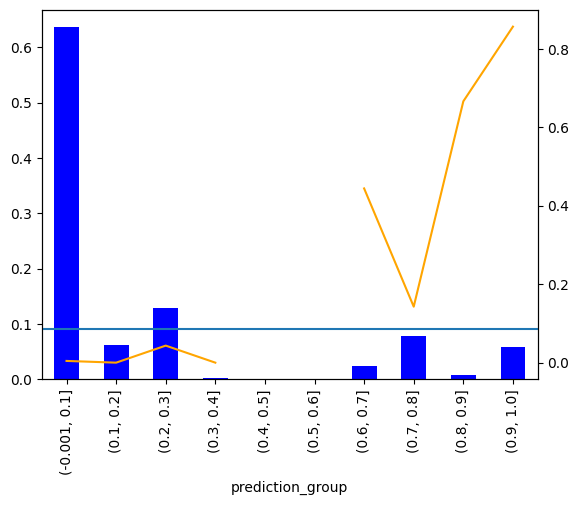

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       326
           1       0.46      0.77      0.58        31

    accuracy                           0.90       357
   macro avg       0.72      0.84      0.76       357
weighted avg       0.93      0.90      0.91       357

AUC Score: 0.9446368493963982


In [37]:
present_scores(y_test, y_pred_proba, n_bins=10)

# Compute confusion matrix

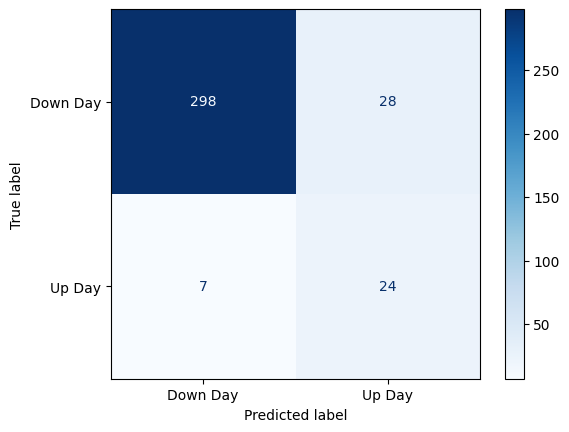

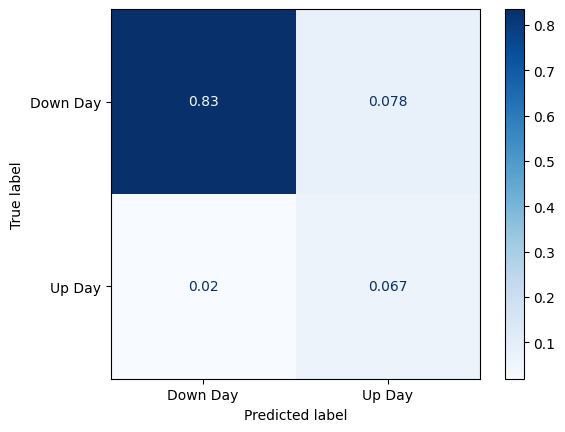

In [38]:
# Compute confusion matrix to evaluate the accuracy of the classification - displaying actual total values numbers per category

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)

plt.show()

# Compute confusion matrix to evaluate the accuracy of the classification - displaying normalized values numbers

cm = confusion_matrix(y_test, y_pred, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)

plt.show()



In [39]:

# הבר (המקל) הכחול מתאר כמה תצפיות יש בכל בין של הסתברות, למשל, בבין של 0.3 עד 0.4 יש 38% מהתצפיות
# הקו הכחול לעומתו, מתאר את המציאות - כמה ״1״-ים יש לנו במציאות
# הקו הכתום, תמיד צריך להיות משווה לקו הכחול, מעיד על אחוז הדיוק בבין
# נשים את הסף כל עוד הקו הכתום מעל הקו הכחול, או במינימום בנק׳ המפגש שלהם
# במודל טוב - ככל שההתסברות גבוהה יותר, כך הוא גם צודק יותר, ולכן בגדול הקו הכתום צריך לעלות, אבל זה לא המצב אצלנו

In [39]:
#create the profit function - based on the percentage of change in the "market cap percentage" column

# create prediction column in the "test" dataframe based on the model results, set it to binary number instead of True / False

test['prediction'] = y_pred.astype(int)
# test = test.reset_index()
test['profit_percentage'] = test['diff_in_mc_perc'] * test['prediction']
profit_perc_sum = round(test['profit_percentage'].sum(), 3)
profit_perc_mean = round(profit_perc_sum / test[test['prediction']==1].shape[0], 3)

print("The total profit in percentage after investing in APH stock is:",profit_perc_mean,"%")

The total profit in percentage after investing in APH stock is: 3.82 %
